In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install category_encoders
# !pip install dacon_submit_api-0.0.4-py3-none-any.whl
# !pip install mljar-supervised

In [3]:
## import 
import pandas as pd
import numpy as np
from supervised.automl import AutoML

# vis
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.family'] = 'Malgun Gothic' # 한글 패치. 코랩에선 주석하셈
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, VotingRegressor 
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.base import ClassifierMixin
# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss,mean_squared_error

# CatBoost
from catboost import CatBoostRegressor

# Utility
import os
import time
import datetime # ⚠️2019년 12월30일과 31일의 week of year가 1인 오류가 있음
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
# import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import holidays

# 시드값 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(2023)

# 데이터프레임 컬럼 전체 보기
pd.set_option('display.max_columns', None)

In [4]:
# 데이터 로드

path = '../data/daegu/automl/'

train_org = pd.read_csv(path+'train.csv')
test_org = pd.read_csv(path+'test.csv')

In [5]:
# 이희원님 코드 그대로 사용
for df in [train_org, test_org]:
    # 날짜 데이터
    time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

    df[['연', '월', '일', '시간']] = df['사고일시'].str.extract(time_pattern)
    df[['연', '월', '일', '시간']] = df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
    df['사고일시'] = pd.to_datetime(df['사고일시'])
    # df= df.drop(columns=['사고일시']) # 일단 냄겨두자

    # 도시/구/동 분리
    location_pattern = r'(\S+) (\S+) (\S+)'

    df[['도시', '구', '동']] = df['시군구'].str.extract(location_pattern)
    # df= df.drop(columns=['시군구']) # 얘도 일단 냄겨놔

    # 도로형태도 분류 코드
    #road_pattern = r'(.+) - (.+)'

    #df[['도로형태1', '도로형태2']] = df['도로형태'].str.extract(road_pattern)
    #df= df.drop(columns=['도로형태']) # 얘는 드롭함

    # 시간 >> 코사인 변환
#     df['cos_hour'] = np.cos(2 * np.pi * df['시간'] / 24)
    # 📢송규헌) 사인-코사인 변환
    df['cos_hour'] = np.sign(np.pi*2*df['시간']/24) + np.cos(np.pi*2*df['시간']/24) + np.sign(np.pi*4*df['시간']/24) + np.cos(np.pi*4*df['시간']/24)

    # 월 >> 코사인 변환
    df['cos_month'] = -np.cos(np.pi*2*df['월']/12) + np.cos(np.pi*2*df['월']/12) - np.cos(np.pi*4*df['월']/12) + np.sign(np.pi*5*df['월']/12) + np.cos(np.pi*1*df['월']/12) + 2

    
    # 공휴일 (주말과 공휴일을 묶음)
    # 공휴일 = 1, 비공휴일 = 0
    holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']
    df['dow'] = df['사고일시'].dt.dayofweek #임시로 만든 컬럼
    df['holiday'] = np.where((df['dow']>=5) | (df['사고일시'].dt.strftime('%Y-%m-%d').isin(holi_weekday)),1,0)
    df.drop('dow',axis=1,inplace=True)
    
    # 계절 >> cos_month 사용할 때는 season은 생략
#     def group_season(df):
#         df.loc[(df['월'] == 3) | (df['월'] == 4) | (df['월'] == 5), 'season'] = '봄'
#         df.loc[(df['월'] == 6) | (df['월'] == 7) | (df['월'] == 8), 'season'] = '여름'
#         df.loc[(df['월'] == 9) | (df['월'] == 10) | (df['월'] == 11), 'season'] = '가을'
#         df.loc[(df['월'] == 12) | (df['월'] == 1) | (df['월'] == 2), 'season'] = '겨울'
#         return df['season']
#     df['season'] = group_season(df)

In [6]:
train_df = train_org
test_df = test_org

In [7]:
# load data
light_df = pd.read_csv(path+'동별_보안등개수.csv').rename(columns={'설치개수':'보안등개수'})
parking_df = pd.read_csv(path+'주차장급지구분별개수.csv')
speed_df = pd.read_csv(path+'동별_제한속도.csv')
cross_walk_df = pd.read_csv(path+'동별_횡단보도개수.csv')
child_area_df = pd.read_csv(path+'동별_어린이보호구역개수.csv')


# merge data
train_df = pd.merge(train_df, light_df, how='left', on=['구','동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['구','동'])
train_df = pd.merge(train_df, speed_df, how='left', on='동')
train_df = pd.merge(train_df, cross_walk_df, how='left', on='동')
train_df = pd.merge(train_df, child_area_df, how='left', on=['구','동'])

test_df = pd.merge(test_df, light_df, how='left', on=['구','동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['구','동'])
test_df = pd.merge(test_df, speed_df, how='left', on='동')
test_df = pd.merge(test_df, cross_walk_df, how='left', on='동')
test_df = pd.merge(test_df, child_area_df, how='left', on=['구','동'])


In [8]:
### 피처 추가...

# 시군구별 사고횟수 >> 기본 코드 사용
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])




In [9]:
###⚠️연도 그냥 타겟 인코딩할래
# # 📢송규헌) 연도값을 연도별 eclo평균값으로 변경
# # 선형추세
# yearly_eclo_avg = train_df.groupby('연')['ECLO'].mean()
# x = np.array(yearly_eclo_avg.index)
# y = yearly_eclo_avg.values
# lr = LinearRegression()
# lr.fit(x.reshape(-1,1),y.reshape(-1,1))
# pred = lr.predict(np.array([2022]).reshape(-1,1))
# yearly_eclo_avg[2022] = pred.reshape(1)[0]

# train_df['연'] =  train_df['연'].map(yearly_eclo_avg)
# test_df['연'] =  test_df['연'].map(yearly_eclo_avg)

In [10]:
# 점검
display(train_df.head(2))
display(test_df.head(2))

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,cos_hour,cos_month,holiday,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수
0,ACCIDENT_00000,2019-01-01,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,2019,1,1,0,대구광역시,중구,대신동,2.0,3.465926,1,391.0,11.0,0.0,0.0,40.0,5929.0,2.0,131
1,ACCIDENT_00001,2019-01-01,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,2019,1,1,0,대구광역시,달서구,감삼동,2.0,3.465926,1,941.0,0.0,1.0,3.0,52.5,10000.0,NaN,678


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,연,월,일,시간,도시,구,동,cos_hour,cos_month,holiday,보안등개수,급지구분_1,급지구분_2,급지구분_3,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수
0,ACCIDENT_39609,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,3.831951,3.465926,1,700.0,NaN,NaN,NaN,52.500000,9025.0,5.0,338
1,ACCIDENT_39610,2022-01-01 01:00:00,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,3.831951,3.465926,1,NaN,0.0,0.0,2.0,47.142857,52441.0,10.0,492


In [11]:
# 불필요 컬럼 제거
drop_columns = ['ID','도시','시간','시군구','사고일시','사고유형 - 세부분류','법규위반','가해운전자 차종','가해운전자 성별','가해운전자 연령',
       '가해운전자 상해정도','사망자수','중상자수','피해운전자 차종','피해운전자 성별',
      '피해운전자 연령','피해운전자 상해정도','경상자수','부상자수',
       '월'
]
train_df.drop(columns = drop_columns,inplace=True)
test_df.drop(columns=['ID','도시','시간','사고일시','시군구','월'
                     
                     
                     
                     ],inplace=True)

### 이상치 처리 및 결측값 처리

In [12]:
# 결측값 확인 
train_df.isnull().sum().sort_values(ascending=False)[:11]

어린이보호구역개수    18426
보안등개수        13813
급지구분_3        6543
급지구분_2        6543
급지구분_1        6543
제한속도          2442
횡단보도개수          62
요일               0
cos_month        0
holiday          0
cos_hour         0
dtype: int64

In [13]:
test_df.isnull().sum().sort_values(ascending=False)[:11]

어린이보호구역개수    4961
보안등개수        4029
급지구분_3       1928
급지구분_2       1928
급지구분_1       1928
제한속도          729
횡단보도개수         21
요일              0
기상상태            0
holiday         0
cos_month       0
dtype: int64

In [14]:
# # 일단 interpolate
# for df in [train_df,test_df]:
#     df['어린이보호구역개수'] = df['어린이보호구역개수'].interpolate()
#     df['급지구분_1'] = df['급지구분_1'].interpolate()
#     df['급지구분_2'] = df['급지구분_2'].interpolate()
#     df['급지구분_3'] = df['급지구분_3'].interpolate()
#     df['제한속도'] = df['제한속도'].interpolate()
#     df['횡단보도개수'] = df['횡단보도개수'].interpolate()
    
# # 급지구분 interpolate하면 안 채워지는 게 1개 있어서 0으로 대체
# test_df['급지구분_1'] = test_df['급지구분_1'].fillna(0)
# test_df['급지구분_2'] = test_df['급지구분_2'].fillna(0)
# test_df['급지구분_3'] = test_df['급지구분_3'].fillna(0)

In [15]:
# 결측값을 '구' 별 평균으로 처리
na_columns = ['어린이보호구역개수','급지구분_1','급지구분_1','급지구분_1'
             ,'제한속도','횡단보도개수','보안등개수']


### 어린이보호구역개수 결측값 처리
child_area_mean = train_df.groupby('구')['어린이보호구역개수'].mean()
# 달서구와 동구가 아예 어린이보호구역개수가 nan임.
child_mean_sum = child_area_mean.sum()/len(child_area_mean)
# 전체평균으로 대체 # 동구와 달성군 모두 면적이 넓음
child_area_mean['달서구'] = child_mean_sum
child_area_mean['동구'] = child_mean_sum
def fillna_with_mean_child(row):
    if np.isnan(row['어린이보호구역개수']):
        row['어린이보호구역개수'] = child_area_mean[row['구']]
    return row
train_df = train_df.apply(fillna_with_mean_child,axis=1)
test_df = test_df.apply(fillna_with_mean_child,axis=1)


### 급지구분 결측값 처리
parking_mean = train_df.groupby('구')[['급지구분_1','급지구분_2',
                          '급지구분_3']].mean()
cols = ['급지구분_1','급지구분_2','급지구분_3']
for col in cols:
    def fillna_with_mean_parking(row):
        if np.isnan(row[col]):
            row[col] = parking_mean.loc[row['구'],col]
        return row
    train_df = train_df.apply(fillna_with_mean_parking,axis=1)
    test_df = test_df.apply(fillna_with_mean_parking,axis=1)
### 급지구분_1,2,3 컬럼을 주차장지수로 변경 >> 1급지*4 + 2급지*2 + 3급지
train_df['주차장지수'] = train_df['급지구분_1']*4+train_df['급지구분_2']*2+train_df['급지구분_3']
test_df['주차장지수'] = test_df['급지구분_1']*4+test_df['급지구분_2']*2+test_df['급지구분_3']    
train_df.drop(columns=['급지구분_1','급지구분_2','급지구분_3'],inplace=True)
test_df.drop(columns=['급지구분_1','급지구분_2','급지구분_3'],inplace=True)
    

### 보안등개수 결측값 처리
light_mean = train_df.groupby('구')['보안등개수'].mean()
# 달성군과 서구가 NaN >> 달성군은 면적이 크므로 전체평균값을 활용, 
# 서구는 작으므로 Q1 사용
light_total_mean = light_mean.sum()/len(light_mean)
light_mean['달성군'] = light_total_mean
light_mean['서구'] = light_total_mean * 0.25
def fillna_with_mean_light(row):
    if np.isnan(row['보안등개수']):
        row['보안등개수'] = light_mean[row['구']]
    return row
train_df = train_df.apply(fillna_with_mean_light,axis=1)
test_df = test_df.apply(fillna_with_mean_light,axis=1)

 
### 제한속도 결측값 처리
speed_mean = train_df.groupby('구')['제한속도'].mean()
def fillna_with_mean_speed(row):
    if np.isnan(row['제한속도']):
        row['제한속도'] = speed_mean[row['구']]
    return row
train_df = train_df.apply(fillna_with_mean_speed,axis=1)
test_df = test_df.apply(fillna_with_mean_speed,axis=1)


### 횡단보도개수 결측값 처리
# cross_mean = train_df.groupby('구')['횡단보도개수'].mean()
# def fillna_with_mean_cross(row):
#     if np.isnan(row['횡단보도개수']):
#         row['횡단보도개수'] = cross_mean[row['구']]
#     return row
# train_df = train_df.apply(fillna_with_mean_cross,axis=1)
# test_df = test_df.apply(fillna_with_mean_cross,axis=1)
bookgu_cross = train_df[train_df['구']=='북구']['횡단보도개수'].mean()
donggu_cross = train_df[train_df['구']=='동구']['횡단보도개수'].mean()
junggu_cross = train_df[train_df['구']=='중구']['횡단보도개수'].mean()

cross_dict = {'중구': junggu_cross, '동구': donggu_cross, '북구': bookgu_cross}

for i in ['중구', '동구', '북구']:
    train_df.loc[(train_df['구']==i) & (train_df['횡단보도개수'].isnull()), '횡단보도개수'] = cross_dict[i]
    test_df.loc[(test_df['구']==i) & (test_df['횡단보도개수'].isnull()), '횡단보도개수'] = cross_dict[i]


In [16]:
# 연습용 코드

# ### 제한속도 결측값 처리
# cross_mean = train_df.groupby('구')['횡단보도개수'].mean()
# def fillna_with_mean_speed(row):
#     if np.isnan(row['횡단보도개수']):
#         row['횡단보도개수'] = light_mean[row['구']]
#     return row
# train_df = train_df.apply(fillna_with_mean_speed,axis=1)
# test_df = test_df.apply(fillna_with_mean_speed,axis=1)



In [17]:
# 결측값 확인 
train_df.isnull().sum().sort_values(ascending=False)[:5]," ---- " , test_df.isnull().sum().sort_values(ascending=False)[:5]

(요일           0
 cos_hour     0
 사고발생횟수       0
 어린이보호구역개수    0
 횡단보도개수       0
 dtype: int64,
 ' ---- ',
 요일           0
 기상상태         0
 사고발생횟수       0
 어린이보호구역개수    0
 횡단보도개수       0
 dtype: int64)

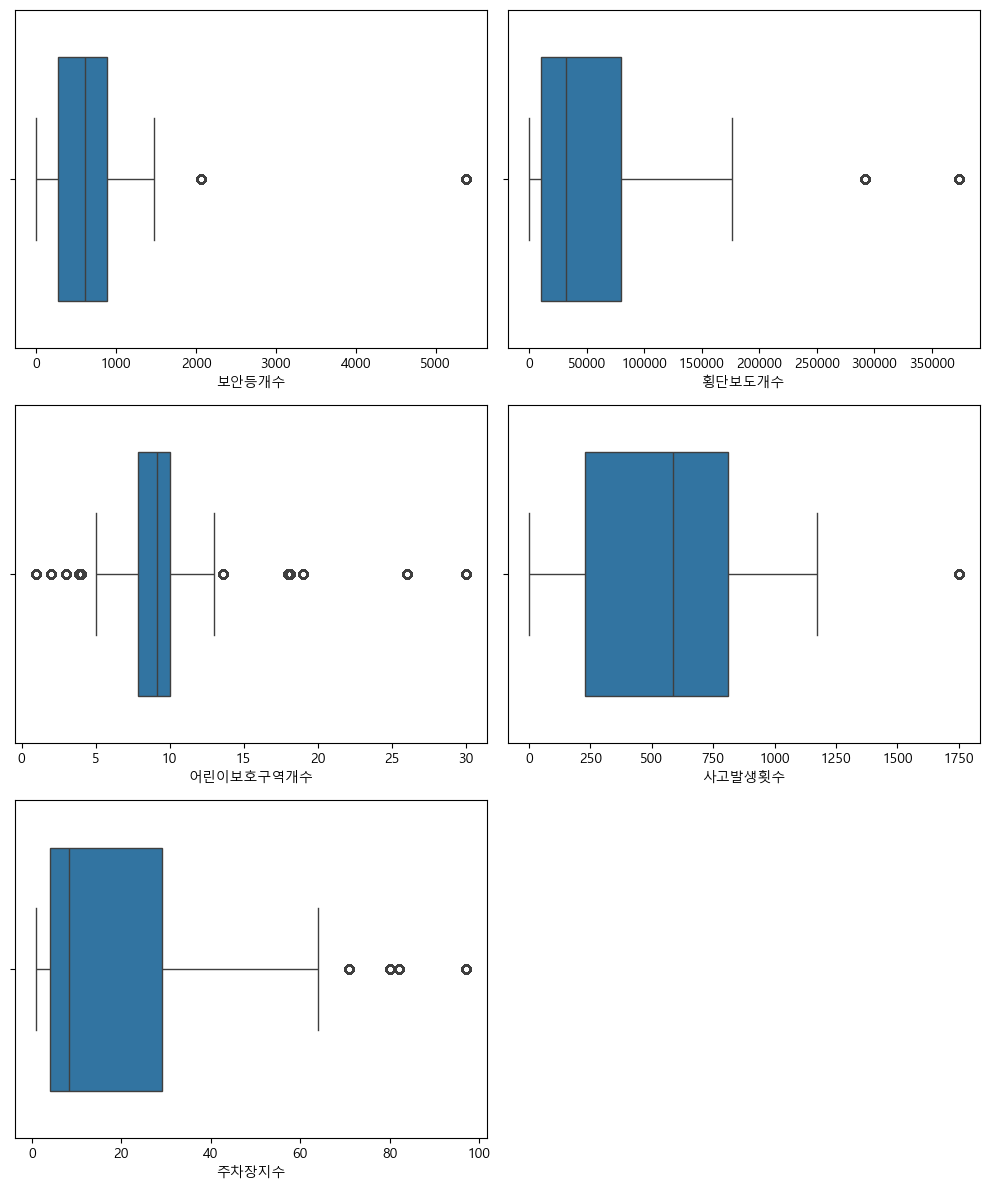

In [18]:
### 이상치 처리 시각화 코드 무지성 boxplot
i = 0 
outlier_columns = ['보안등개수','횡단보도개수','어린이보호구역개수',
           '사고발생횟수','주차장지수'] # 확인하고픈 수치형 컬럼 넣기
sub_cols = 2
sub_rows = (len(outlier_columns)+1) // 2
width = len(outlier_columns) * 2 ### width, height 곱하는 숫자 조정해서 플롯 사이즈 조정
height = sub_rows * 4

plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
for col in outlier_columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.boxplot(data=train_df,x=col,gap=.1)
#     plt.xticks(rotation=45)
plt.tight_layout()

In [19]:
### 이상치 처리 함수 정의
import numpy as np
def tukey_fences(data): # data는 1차원 배열
    q1,q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lf = q1 - (iqr*1.5)
    uf = q3 + (iqr*1.5)
    idxs = np.where((data>uf) | (data<lf))[0] # condition이 True일 때, data의 인덱스를 반환
    return idxs, lf, uf

def outlier_to_lf_uf(data, outlier_function=tukey_fences): # data는 Series객체
    idxs, lf, uf = outlier_function(data)
    for i in idxs:
        if data.iloc[i] <= lf:
            data.iloc[i] = lf
        elif data.iloc[i] >= uf:
            data.iloc[i] = uf
            
    return data

In [20]:
train_df.columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '일', '구', '동',
       'cos_hour', 'cos_month', 'holiday', '보안등개수', '제한속도', '횡단보도개수',
       '어린이보호구역개수', '사고발생횟수', '주차장지수'],
      dtype='object')

In [21]:
### 이상치 처리 수행
for col in outlier_columns:
    train_df[col] = outlier_to_lf_uf(train_df[col], tukey_fences)
    test_df[col] = outlier_to_lf_uf(test_df[col], tukey_fences)

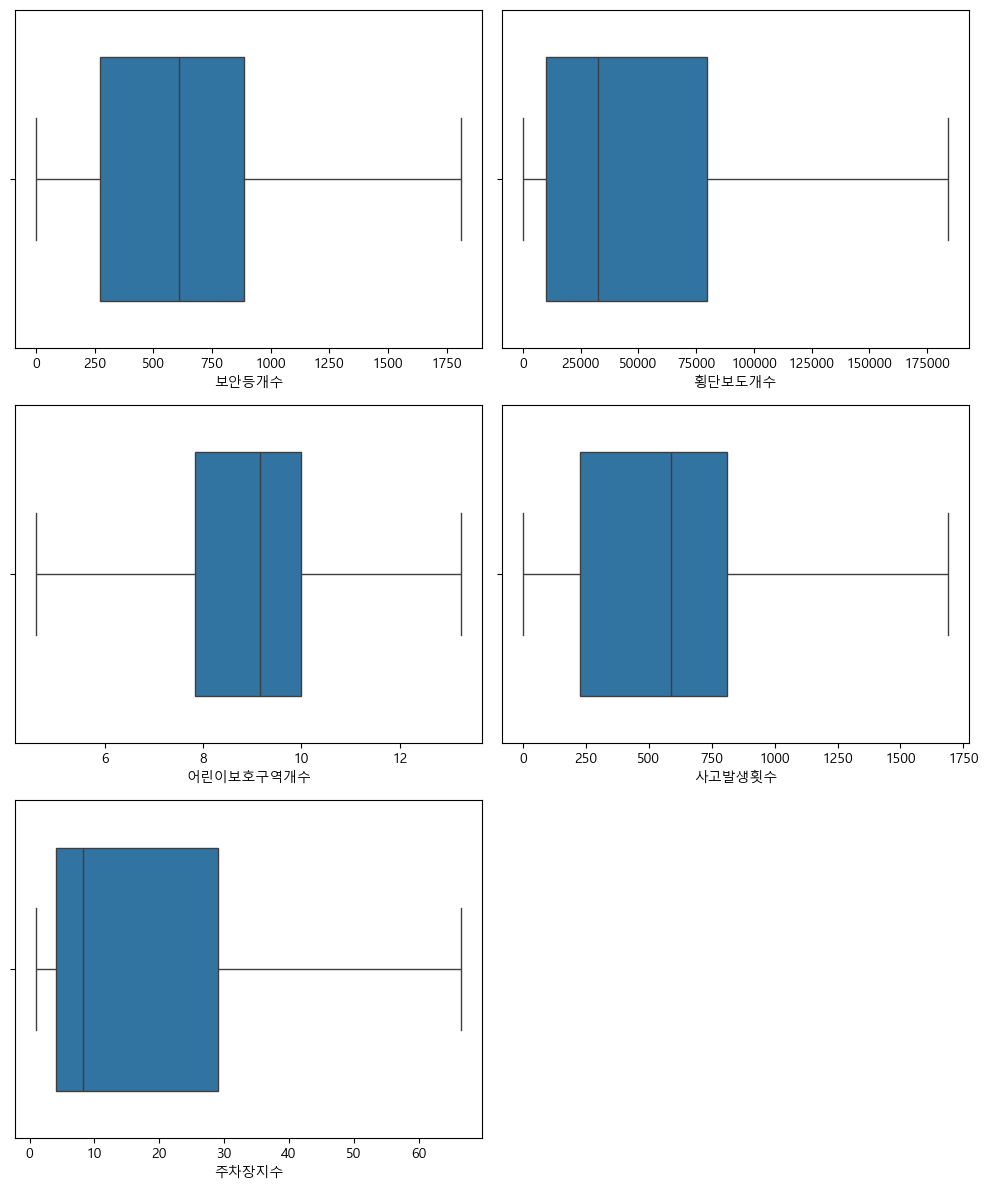

In [22]:
### 이상치 처리가 완료된 데이터 시각화
i = 0 
outlier_columns = ['보안등개수','횡단보도개수','어린이보호구역개수',
           '사고발생횟수','주차장지수'] # 확인하고픈 수치형 컬럼 넣기
sub_cols = 2
sub_rows = (len(outlier_columns)+1) // 2
width = len(outlier_columns) * 2 ### width, height 곱하는 숫자 조정해서 플롯 사이즈 조정
height = sub_rows * 4

plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
for col in outlier_columns:
    i += 1
    plt.subplot(sub_rows,sub_cols,i)
    sns.boxplot(data=train_df,x=col,gap=.1)
#     plt.xticks(rotation=45)
plt.tight_layout()

### 인코딩 및 스케일링

In [23]:
# 원핫 : 구

# train_df와 test_df의 기상상태 및 노면상태 열 선택
train_categorical_data = train_df[['구']]
test_categorical_data = test_df[['구']]

# OneHotEncoder 인스턴스 생성 및 fit_transform 수행
encoder = OneHotEncoder()
train_encoded = encoder.fit_transform(train_categorical_data)
test_encoded = encoder.transform(test_categorical_data)

# OneHotEncoder가 사용한 카테고리 목록을 가져와서 카테고리 이름을 열 이름으로 변환
feature_names = encoder.get_feature_names_out(['구'])

# 밀집 행렬로 변환 (선택 사항)
train_encoded_dense = train_encoded.toarray()
test_encoded_dense = test_encoded.toarray()

# 데이터프레임으로 변환 (선택 사항)
import pandas as pd

train_encoded_df = pd.DataFrame(train_encoded_dense, columns=feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded_dense, columns=feature_names, index=test_df.index)

# 기존 열 제거
train_df = train_df.drop(['구'], axis=1)
test_df = test_df.drop(['구'], axis=1)

# 인코딩된 열 추가
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


In [24]:
# 타겟 인코딩 : 나머지
# Target encoding
from category_encoders.target_encoder import TargetEncoder

### ✔️ 타겟 인코딩하기 전에 eclo 로그 변환해주기
train_df['ECLO'] = np.log1p(train_df['ECLO'])

categorical_features = ['연','요일','도로형태','사고유형','동','기상상태', '노면상태']

for i in categorical_features:
    tr_encoder = TargetEncoder(cols=[i])
    train_df[i] = tr_encoder.fit_transform(train_df[i], train_df['ECLO'])
    test_df[i] = tr_encoder.transform(test_df[i])

In [25]:
train_df

,요일,기상상태,도로형태,노면상태,사고유형,ECLO,연,일,동,cos_hour,cos_month,holiday,보안등개수,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수,주차장지수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구
0,1.620570,1.632169,1.618762,1.6324,1.510543,1.791759,1.647741,1,1.570475,2.000000,3.465926,1,391.000000,40.000000,5929.0,4.606549,131,44.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.620570,1.644549,1.618762,1.6324,1.510543,1.386294,1.647741,1,1.649966,2.000000,3.465926,1,941.000000,52.500000,10000.0,9.162847,678,5.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.620570,1.632169,1.618762,1.6324,1.510543,1.386294,1.647741,1,1.650353,3.831951,3.465926,1,473.000000,55.000000,14641.0,5.000000,604,5.088215,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.620570,1.632169,1.618762,1.6324,1.665521,1.791759,1.647741,1,1.543196,3.366025,3.465926,1,534.000000,38.000000,29929.0,11.000000,426,23.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.620570,1.632169,1.618762,1.6324,1.665521,1.386294,1.647741,1,1.611041,2.000000,3.465926,1,1810.217749,40.000000,58564.0,9.162847,825,2.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,1.617119,1.632169,1.679938,1.6324,1.665521,1.386294,1.620280,31,1.656281,1.392794,1.000000,0,610.885185,40.000000,2809.0,4.606549,104,5.088215,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39605,1.617119,1.632169,1.618762,1.6324,1.665521,1.386294,1.620280,31,1.570879,1.392794,1.000000,0,844.000000,44.444444,100489.0,9.162847,1143,5.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39606,1.617119,1.632169,1.679938,1.6324,1.665521,2.397895,1.620280,31,1.628808,2.707107,1.000000,0,167.000000,41.111111,79524.0,9.162847,618,2.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39607,1.617119,1.632169,1.544846,1.6324,1.665521,1.386294,1.620280,31,1.651521,3.366025,1.000000,0,210.000000,60.000000,7921.0,9.162847,125,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# 스케일링 전 전처리
# 일 필요 없을 듯?
train_df.drop(columns=['일'],inplace=True)
test_df.drop(columns=['일'],inplace=True)

In [27]:
# # 스케일링 전 분포 시각화
# i = 0 
# columns = train_df.columns
# sub_cols = 2
# sub_rows = (len(columns)+1) // 2
# width = len(columns)
# height = sub_rows * 8

# plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
# for col in columns:
#     i += 1
#     plt.subplot(sub_rows,sub_cols,i)
#     sns.histplot(data=train_df,x=col,kde=True)
# plt.tight_layout()

In [28]:
train_df.columns

Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', 'ECLO', '연', '동', 'cos_hour',
       'cos_month', 'holiday', '보안등개수', '제한속도', '횡단보도개수', '어린이보호구역개수',
       '사고발생횟수', '주차장지수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구',
       '구_수성구', '구_중구'],
      dtype='object')

In [29]:
### 스케일링
scaling_columns = [
#     '요일', '기상상태', '도로형태', '노면상태', '사고유형', 
#    '연','동','cos_hour','cos_month',
   '보안등개수','어린이보호구역개수',
   '사고발생횟수',
    '제한속도','주차장지수','횡단보도개수'
]

# log_scaling_columns = ['주차장지수','제한속도','횡단보도개수'] # ECLO는 이미 로그변환 완료

# for c in log_scaling_columns:
#     train_df[c] = np.log1p(train_df[c])
#     test_df[c] = np.log1p(test_df[c])

# mms = MinMaxScaler()
ssc = StandardScaler()
for c in scaling_columns: #+log_scaling_columns:
    train_df[c] = ssc.fit_transform(np.reshape(train_df[c],(-1,1)))
    test_df[c] = ssc.transform(np.reshape(test_df[c],(-1,1)))

In [30]:
# # 스케일링 후 분포 시각화
# i = 0 
# columns = train_df.columns
# sub_cols = 2
# sub_rows = (len(columns)+1) // 2
# width = len(columns)
# height = sub_rows * 8

# plt.figure(figsize=(width, height)) # figure의 width height는 맘대로
# for col in columns:
#     i += 1
#     plt.subplot(sub_rows,sub_cols,i)
#     sns.histplot(data=train_df,x=col,kde=True)
# plt.tight_layout()

### 기타 전처리

In [31]:
train_df

,요일,기상상태,도로형태,노면상태,사고유형,ECLO,연,동,cos_hour,cos_month,holiday,보안등개수,제한속도,횡단보도개수,어린이보호구역개수,사고발생횟수,주차장지수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구
0,1.620570,1.632169,1.618762,1.6324,1.510543,1.791759,1.647741,1.570475,2.000000,3.465926,1,-0.566911,-1.027305,-0.895246,-1.600299,-1.102130,1.199650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.620570,1.644549,1.618762,1.6324,1.510543,1.386294,1.647741,1.649966,2.000000,3.465926,1,0.640717,0.699769,-0.817518,0.028909,0.281504,-0.651262,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.620570,1.632169,1.618762,1.6324,1.510543,1.386294,1.647741,1.650353,3.831951,3.465926,1,-0.386865,1.045183,-0.728907,-1.459612,0.094321,-0.647076,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.620570,1.632169,1.618762,1.6324,1.665521,1.791759,1.647741,1.543196,3.366025,3.465926,1,-0.252928,-1.303636,-0.437011,0.685825,-0.355929,0.203005,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.620570,1.632169,1.618762,1.6324,1.665521,1.386294,1.647741,1.611041,2.000000,3.465926,1,2.549249,-1.027305,0.109720,0.028909,0.653340,-0.793640,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,1.617119,1.632169,1.679938,1.6324,1.665521,1.386294,1.620280,1.656281,1.392794,1.000000,0,-0.084112,-1.027305,-0.954817,-1.600299,-1.170427,-0.647076,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39605,1.617119,1.632169,1.618762,1.6324,1.665521,1.386294,1.620280,1.570879,1.392794,1.000000,0,0.427736,-0.413234,0.910199,0.028909,1.457720,-0.651262,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39606,1.617119,1.632169,1.679938,1.6324,1.665521,2.397895,1.620280,1.628808,2.707107,1.000000,0,-1.058745,-0.873787,0.509912,0.028909,0.129734,-0.793640,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39607,1.617119,1.632169,1.544846,1.6324,1.665521,1.386294,1.620280,1.651521,3.366025,1.000000,0,-0.964331,1.736013,-0.857213,0.028909,-1.117307,-0.841099,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
train_df.to_csv('./train_df.csv',index=False)
test_df.to_csv('./test_df.csv',index=False)

### 데이터셋 분할

In [35]:
# 컬럼명 영어로 바꾸기
kr2eng = {'요일':'dayofweek', '기상상태':'weather', '도로형태':'road_type',
          '노면상태':'road_state', '사고유형':'accident_type', '연':'year',
          '동':'dong', '보안등개수':'light_count', '제한속도':'speed_limit',
          '횡단보도개수':'cross_count', '어린이보호구역개수':'child_count',
          '사고발생횟수':'accident_count', '주차장지수':'parking_index',
          '구_남구':'gu_namgu', '구_달서구':'gu_dalseogu', 
          '구_달성군':'gu_dalsunggun', '구_동구':'gu_donggu', 
          '구_북구':'gu_bookgu', '구_서구':'gu_seogu',
       '구_수성구':'gu_suseonggu', '구_중구':'gu_junggu'}

train_df.rename(columns=kr2eng,inplace=True)
test_df.rename(columns=kr2eng,inplace=True)

In [38]:
train_x = train_df[test_df.columns] # test 셋에만 있는 컬럼만 추출
train_y = np.log1p(train_df['ECLO'])
test_x = test_df

In [39]:
# x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

### AUTOML

In [40]:
import matplotlib
matplotlib.use('Agg')

In [46]:
from supervised.automl import AutoML
automl = AutoML(
                algorithms = ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1,total_time_limit=60000, eval_metric="rmse", ml_task = "regression",
               results_path = './AutoML_004_some_scaling/',
                explain_level=2,
                mode='Optuna',
                random_state=42,
                stack_models=True
               )

In [47]:
automl.fit(train_x, train_y)

AutoML directory: ./AutoML_004_some_scaling/
Expected computing time:
Time for tuning with Optuna: len(algorithms) * optuna_time_budget = 14400 seconds
There is no time limit for ML model training after Optuna tuning (total_time_limit parameter is ignored).
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 4 models


[I 2023-12-08 23:22:17,995] A new study created in memory with name: no-name-1191e14a-b0fd-48cf-ad2f-7e3dc7d88906


Optuna optimizes LightGBM with time budget 3600 seconds eval_metric rmse (minimize)


[I 2023-12-08 23:22:20,518] Trial 0 finished with value: 0.9939194826711822 and parameters: {'learning_rate': 0.025, 'num_leaves': 321, 'lambda_l1': 2.5348407664333426e-07, 'lambda_l2': 3.3323645788192616e-08, 'feature_fraction': 0.9063233107042159, 'bagging_fraction': 0.7207805142313962, 'bagging_freq': 5, 'min_data_in_leaf': 3, 'extra_trees': True}. Best is trial 0 with value: 0.9939194826711822.
[I 2023-12-08 23:22:22,363] Trial 1 finished with value: 0.9892440897714087 and parameters: {'learning_rate': 0.1, 'num_leaves': 1076, 'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06, 'feature_fraction': 0.7282970324241945, 'bagging_fraction': 0.3976457038513679, 'bagging_freq': 3, 'min_data_in_leaf': 37, 'extra_trees': False}. Best is trial 1 with value: 0.9892440897714087.
[I 2023-12-08 23:22:26,900] Trial 2 finished with value: 0.9915050157094544 and parameters: {'learning_rate': 0.05, 'num_leaves': 1245, 'lambda_l1': 3.425445902633376e-07, 'lambda_l2': 3.850031979199

[I 2023-12-08 23:23:10,161] Trial 21 finished with value: 0.984290112506063 and parameters: {'learning_rate': 0.025, 'num_leaves': 977, 'lambda_l1': 1.899679125977724, 'lambda_l2': 7.785245991585323, 'feature_fraction': 0.6265383521722062, 'bagging_fraction': 0.3251380593914981, 'bagging_freq': 7, 'min_data_in_leaf': 99, 'extra_trees': False}. Best is trial 12 with value: 0.9833704303748352.
[I 2023-12-08 23:23:11,442] Trial 22 finished with value: 0.9842251379991 and parameters: {'learning_rate': 0.025, 'num_leaves': 765, 'lambda_l1': 9.851681770927204, 'lambda_l2': 0.12097358441176502, 'feature_fraction': 0.6320566549682821, 'bagging_fraction': 0.32777226479678423, 'bagging_freq': 6, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 12 with value: 0.9833704303748352.
[I 2023-12-08 23:23:12,752] Trial 23 finished with value: 0.98334557232104 and parameters: {'learning_rate': 0.025, 'num_leaves': 575, 'lambda_l1': 9.01520630983993, 'lambda_l2': 0.7058492378872643, 'feature_f

[I 2023-12-08 23:23:49,005] Trial 42 finished with value: 0.9843102906997544 and parameters: {'learning_rate': 0.025, 'num_leaves': 1398, 'lambda_l1': 9.90612456888978, 'lambda_l2': 7.910008514944362, 'feature_fraction': 0.7625483530897122, 'bagging_fraction': 0.5732088347880592, 'bagging_freq': 7, 'min_data_in_leaf': 89, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:23:51,047] Trial 43 finished with value: 0.9836187413916417 and parameters: {'learning_rate': 0.025, 'num_leaves': 1916, 'lambda_l1': 2.788164001240017, 'lambda_l2': 1.2653746654682823, 'feature_fraction': 0.7220977264888141, 'bagging_fraction': 0.44637946231658565, 'bagging_freq': 6, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:23:52,639] Trial 44 finished with value: 0.9841279366255816 and parameters: {'learning_rate': 0.05, 'num_leaves': 1751, 'lambda_l1': 0.8429499530901429, 'lambda_l2': 0.40284321068232837, '

[I 2023-12-08 23:24:21,780] Trial 63 finished with value: 0.9849979894662557 and parameters: {'learning_rate': 0.025, 'num_leaves': 193, 'lambda_l1': 5.230026196352801, 'lambda_l2': 0.12228718596535552, 'feature_fraction': 0.7846759127872104, 'bagging_fraction': 0.36932962734342, 'bagging_freq': 3, 'min_data_in_leaf': 83, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:24:22,797] Trial 64 finished with value: 0.98382466522003 and parameters: {'learning_rate': 0.025, 'num_leaves': 86, 'lambda_l1': 2.292287341851708, 'lambda_l2': 0.2432042104565204, 'feature_fraction': 0.8589894435736938, 'bagging_fraction': 0.322934696880368, 'bagging_freq': 4, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:24:24,413] Trial 65 finished with value: 0.9851178903085059 and parameters: {'learning_rate': 0.025, 'num_leaves': 160, 'lambda_l1': 0.6459955913940175, 'lambda_l2': 0.07930441345985478, 'featur

[I 2023-12-08 23:24:54,876] Trial 84 finished with value: 0.9832557272511069 and parameters: {'learning_rate': 0.025, 'num_leaves': 1178, 'lambda_l1': 4.49478434798636, 'lambda_l2': 0.04760941868824901, 'feature_fraction': 0.818340141560385, 'bagging_fraction': 0.3605800199959087, 'bagging_freq': 7, 'min_data_in_leaf': 83, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:24:56,945] Trial 85 finished with value: 0.9845533709917321 and parameters: {'learning_rate': 0.025, 'num_leaves': 1205, 'lambda_l1': 0.9978155586030154, 'lambda_l2': 0.016986839923803926, 'feature_fraction': 0.8143365909176807, 'bagging_fraction': 0.3116503579270807, 'bagging_freq': 7, 'min_data_in_leaf': 71, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:24:59,848] Trial 86 finished with value: 0.9841252224154347 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1273, 'lambda_l1': 2.320387158404281, 'lambda_l2': 0.0540570177788201

[I 2023-12-08 23:25:35,666] Trial 105 finished with value: 0.9843433617359609 and parameters: {'learning_rate': 0.025, 'num_leaves': 1495, 'lambda_l1': 6.192647702009832, 'lambda_l2': 0.028373335070373568, 'feature_fraction': 0.7848160687651767, 'bagging_fraction': 0.44154885437369884, 'bagging_freq': 4, 'min_data_in_leaf': 85, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:25:37,324] Trial 106 finished with value: 0.9835661060608505 and parameters: {'learning_rate': 0.025, 'num_leaves': 1581, 'lambda_l1': 9.809998982840574, 'lambda_l2': 0.01420107640206131, 'feature_fraction': 0.7380412689073577, 'bagging_fraction': 0.34888814002619883, 'bagging_freq': 6, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:25:40,478] Trial 107 finished with value: 0.9833607357156462 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1739, 'lambda_l1': 4.492613627064193, 'lambda_l2': 0.0359965260

[I 2023-12-08 23:26:19,354] Trial 126 finished with value: 0.9840269175742905 and parameters: {'learning_rate': 0.025, 'num_leaves': 1451, 'lambda_l1': 1.4633786958636, 'lambda_l2': 6.074164448678478, 'feature_fraction': 0.7144256276661548, 'bagging_fraction': 0.44134953778558367, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:26:21,283] Trial 127 finished with value: 0.9833192495394284 and parameters: {'learning_rate': 0.025, 'num_leaves': 1536, 'lambda_l1': 0.5265352409565057, 'lambda_l2': 2.5853215832107166, 'feature_fraction': 0.7393566864671114, 'bagging_fraction': 0.36861202197811394, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:26:22,343] Trial 128 finished with value: 0.9852965232489689 and parameters: {'learning_rate': 0.1, 'num_leaves': 1415, 'lambda_l1': 3.2080403014503482, 'lambda_l2': 3.07344251235039, 

[I 2023-12-08 23:27:02,052] Trial 147 finished with value: 0.9838248447949257 and parameters: {'learning_rate': 0.025, 'num_leaves': 1515, 'lambda_l1': 0.6873666631426736, 'lambda_l2': 1.0880815857960195, 'feature_fraction': 0.802830268635986, 'bagging_fraction': 0.3650709907417216, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:27:03,731] Trial 148 finished with value: 0.9836262164764233 and parameters: {'learning_rate': 0.025, 'num_leaves': 1207, 'lambda_l1': 2.4911573527215367, 'lambda_l2': 5.656895965725122, 'feature_fraction': 0.7312228864992147, 'bagging_fraction': 0.3356936613900989, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:27:05,929] Trial 149 finished with value: 0.9842754077552833 and parameters: {'learning_rate': 0.025, 'num_leaves': 1348, 'lambda_l1': 1.1715112011452764, 'lambda_l2': 0.242689692562124

[I 2023-12-08 23:27:40,248] Trial 168 finished with value: 0.9851405690999243 and parameters: {'learning_rate': 0.025, 'num_leaves': 634, 'lambda_l1': 0.6050142081302008, 'lambda_l2': 0.3700589331755711, 'feature_fraction': 0.7391381237463945, 'bagging_fraction': 0.6209388387998046, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:27:41,864] Trial 169 finished with value: 0.9828268328950266 and parameters: {'learning_rate': 0.025, 'num_leaves': 1567, 'lambda_l1': 0.004325872540250064, 'lambda_l2': 0.07703565665464457, 'feature_fraction': 0.7941098312679498, 'bagging_fraction': 0.36719312821677713, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:27:43,707] Trial 170 finished with value: 0.9835938789269225 and parameters: {'learning_rate': 0.025, 'num_leaves': 1520, 'lambda_l1': 0.004841950218094738, 'lambda_l2': 0.06483908

[I 2023-12-08 23:28:23,895] Trial 189 finished with value: 0.9846518973238304 and parameters: {'learning_rate': 0.025, 'num_leaves': 1074, 'lambda_l1': 0.9856863359838747, 'lambda_l2': 0.011293519429621373, 'feature_fraction': 0.7952476154404571, 'bagging_fraction': 0.4675470232578632, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:28:24,990] Trial 190 finished with value: 0.9909442832328624 and parameters: {'learning_rate': 0.025, 'num_leaves': 1360, 'lambda_l1': 3.7285266461910105, 'lambda_l2': 0.020653360034837153, 'feature_fraction': 0.6645875497705421, 'bagging_fraction': 0.3676856463555311, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': True}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:28:26,322] Trial 191 finished with value: 0.9835036870341332 and parameters: {'learning_rate': 0.025, 'num_leaves': 431, 'lambda_l1': 4.830509549739275, 'lambda_l2': 0.00765587044

[I 2023-12-08 23:29:05,161] Trial 210 finished with value: 0.9824610299486922 and parameters: {'learning_rate': 0.025, 'num_leaves': 1455, 'lambda_l1': 3.6766365250384947, 'lambda_l2': 0.025240191306164828, 'feature_fraction': 0.8009101009742234, 'bagging_fraction': 0.3713241752616766, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:29:07,107] Trial 211 finished with value: 0.9829578294698255 and parameters: {'learning_rate': 0.025, 'num_leaves': 1450, 'lambda_l1': 3.513627902629408, 'lambda_l2': 0.026091485680422244, 'feature_fraction': 0.8261225701481842, 'bagging_fraction': 0.37421058295950477, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:29:08,986] Trial 212 finished with value: 0.9824672498360396 and parameters: {'learning_rate': 0.025, 'num_leaves': 1452, 'lambda_l1': 3.516448056067873, 'lambda_l2': 0.0206206299

[I 2023-12-08 23:29:44,931] Trial 231 finished with value: 0.9844694088687111 and parameters: {'learning_rate': 0.025, 'num_leaves': 1551, 'lambda_l1': 4.532396922091108, 'lambda_l2': 0.5056383212149168, 'feature_fraction': 0.7605798836236562, 'bagging_fraction': 0.7548714336269354, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:29:46,796] Trial 232 finished with value: 0.9835489800184644 and parameters: {'learning_rate': 0.025, 'num_leaves': 1583, 'lambda_l1': 4.75297664709585, 'lambda_l2': 0.32342539069076465, 'feature_fraction': 0.7415214511437888, 'bagging_fraction': 0.34761782821181664, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:29:48,617] Trial 233 finished with value: 0.984041357271006 and parameters: {'learning_rate': 0.025, 'num_leaves': 1496, 'lambda_l1': 1.907471685839889, 'lambda_l2': 0.1859684951058043

[I 2023-12-08 23:30:34,147] Trial 252 finished with value: 0.9855480306736347 and parameters: {'learning_rate': 0.025, 'num_leaves': 1559, 'lambda_l1': 2.839768085715035, 'lambda_l2': 2.02649859939255, 'feature_fraction': 0.7283598910654285, 'bagging_fraction': 0.5987395644877433, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:30:37,954] Trial 253 finished with value: 0.984717590303592 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1501, 'lambda_l1': 0.2600958931777889, 'lambda_l2': 6.3742567076033385, 'feature_fraction': 0.7574357172678083, 'bagging_fraction': 0.5460156532380915, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:30:41,847] Trial 254 finished with value: 0.9843795232504741 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1405, 'lambda_l1': 0.10076507626290443, 'lambda_l2': 3.66356844717576

[I 2023-12-08 23:31:23,201] Trial 273 finished with value: 0.9831858868834038 and parameters: {'learning_rate': 0.025, 'num_leaves': 1105, 'lambda_l1': 0.005532317859769626, 'lambda_l2': 0.00804285946837085, 'feature_fraction': 0.7512742652380042, 'bagging_fraction': 0.3667767057274226, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:31:24,482] Trial 274 finished with value: 0.9841142444154526 and parameters: {'learning_rate': 0.025, 'num_leaves': 907, 'lambda_l1': 0.7126007066208659, 'lambda_l2': 0.004047545554337913, 'feature_fraction': 0.800409117950886, 'bagging_fraction': 0.3044181109293931, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:31:27,671] Trial 275 finished with value: 0.9850158791145447 and parameters: {'learning_rate': 0.025, 'num_leaves': 1540, 'lambda_l1': 0.015131275649087962, 'lambda_l2': 0.04447298

[I 2023-12-08 23:32:09,606] Trial 294 finished with value: 0.982970403377072 and parameters: {'learning_rate': 0.025, 'num_leaves': 1348, 'lambda_l1': 5.982957499790527, 'lambda_l2': 0.0043733539758685595, 'feature_fraction': 0.7468233016234259, 'bagging_fraction': 0.387684901577876, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:32:11,392] Trial 295 finished with value: 0.983648344316503 and parameters: {'learning_rate': 0.025, 'num_leaves': 1590, 'lambda_l1': 6.367940583165857e-08, 'lambda_l2': 9.662114107189149, 'feature_fraction': 0.7839860098697912, 'bagging_fraction': 0.35275445037509706, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:32:14,619] Trial 296 finished with value: 0.9860095530483605 and parameters: {'learning_rate': 0.025, 'num_leaves': 1402, 'lambda_l1': 0.5124801152894437, 'lambda_l2': 0.0158167311

[I 2023-12-08 23:32:52,199] Trial 315 finished with value: 0.9905293561486734 and parameters: {'learning_rate': 0.025, 'num_leaves': 1207, 'lambda_l1': 4.238946040507244, 'lambda_l2': 0.0053211082032080725, 'feature_fraction': 0.8913753153482493, 'bagging_fraction': 0.4156242616138045, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': True}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:32:53,499] Trial 316 finished with value: 0.9858162890106377 and parameters: {'learning_rate': 0.1, 'num_leaves': 1521, 'lambda_l1': 2.5409798395558694, 'lambda_l2': 0.020833773803152794, 'feature_fraction': 0.7522897401178166, 'bagging_fraction': 0.4628401318900161, 'bagging_freq': 7, 'min_data_in_leaf': 89, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:32:56,105] Trial 317 finished with value: 0.9840392932164279 and parameters: {'learning_rate': 0.025, 'num_leaves': 1605, 'lambda_l1': 0.5754299704901571, 'lambda_l2': 0.000361474181

[I 2023-12-08 23:33:34,497] Trial 336 finished with value: 0.9838644802104842 and parameters: {'learning_rate': 0.025, 'num_leaves': 654, 'lambda_l1': 0.00030718977934562924, 'lambda_l2': 0.2389544658136753, 'feature_fraction': 0.8083959909877537, 'bagging_fraction': 0.37655650934381574, 'bagging_freq': 1, 'min_data_in_leaf': 89, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:33:35,729] Trial 337 finished with value: 0.9850147438566098 and parameters: {'learning_rate': 0.05, 'num_leaves': 408, 'lambda_l1': 2.91875107722344, 'lambda_l2': 0.015514906578252767, 'feature_fraction': 0.769316236845542, 'bagging_fraction': 0.39683336919647877, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:33:37,509] Trial 338 finished with value: 0.9831620184765566 and parameters: {'learning_rate': 0.025, 'num_leaves': 1109, 'lambda_l1': 4.969163680676999, 'lambda_l2': 0.001942957913

[I 2023-12-08 23:34:14,101] Trial 357 finished with value: 0.982550655211133 and parameters: {'learning_rate': 0.025, 'num_leaves': 1467, 'lambda_l1': 5.9386336827863335, 'lambda_l2': 0.08695633286463186, 'feature_fraction': 0.8745425231833862, 'bagging_fraction': 0.39089956141267657, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:34:17,196] Trial 358 finished with value: 0.9840195102019319 and parameters: {'learning_rate': 0.025, 'num_leaves': 1563, 'lambda_l1': 6.556058034398345, 'lambda_l2': 0.09370750747275546, 'feature_fraction': 0.8569868959976474, 'bagging_fraction': 0.7475778659164856, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:34:18,781] Trial 359 finished with value: 0.9833763616045212 and parameters: {'learning_rate': 0.025, 'num_leaves': 682, 'lambda_l1': 4.670890823110058, 'lambda_l2': 0.07914355096352

[I 2023-12-08 23:34:58,514] Trial 378 finished with value: 0.9854266291179884 and parameters: {'learning_rate': 0.025, 'num_leaves': 1564, 'lambda_l1': 3.4739789558446974, 'lambda_l2': 4.3451614123669495, 'feature_fraction': 0.6721439735649429, 'bagging_fraction': 0.8178408503804842, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:35:00,861] Trial 379 finished with value: 0.9844247988639059 and parameters: {'learning_rate': 0.025, 'num_leaves': 1703, 'lambda_l1': 0.0021306903663801655, 'lambda_l2': 0.0014610822350146243, 'feature_fraction': 0.759114966844949, 'bagging_fraction': 0.45784378529523945, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:35:03,258] Trial 380 finished with value: 0.9843256972543687 and parameters: {'learning_rate': 0.025, 'num_leaves': 1362, 'lambda_l1': 0.0014811614269680492, 'lambda_l2': 0.1747

[I 2023-12-08 23:35:43,406] Trial 399 finished with value: 0.9839786050733371 and parameters: {'learning_rate': 0.025, 'num_leaves': 1106, 'lambda_l1': 1.1497349680906046, 'lambda_l2': 3.6342178574693293, 'feature_fraction': 0.9218445772479341, 'bagging_fraction': 0.38002645576766425, 'bagging_freq': 7, 'min_data_in_leaf': 89, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:35:48,678] Trial 400 finished with value: 0.9875150333328082 and parameters: {'learning_rate': 0.025, 'num_leaves': 1581, 'lambda_l1': 0.018237792277597347, 'lambda_l2': 0.13762698474006535, 'feature_fraction': 0.7850189625577241, 'bagging_fraction': 0.4037174305523123, 'bagging_freq': 7, 'min_data_in_leaf': 23, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:35:50,561] Trial 401 finished with value: 0.9832595274105994 and parameters: {'learning_rate': 0.025, 'num_leaves': 1538, 'lambda_l1': 0.03053045878957572, 'lambda_l2': 0.51126261

[I 2023-12-08 23:36:31,217] Trial 420 finished with value: 0.9843020284664288 and parameters: {'learning_rate': 0.025, 'num_leaves': 645, 'lambda_l1': 6.657691359865394, 'lambda_l2': 0.0009073510453637328, 'feature_fraction': 0.7307932045506799, 'bagging_fraction': 0.5828956746808063, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:36:33,180] Trial 421 finished with value: 0.9830478899795092 and parameters: {'learning_rate': 0.025, 'num_leaves': 1386, 'lambda_l1': 1.0364691209834953, 'lambda_l2': 1.6857594762625083, 'feature_fraction': 0.8199382135950152, 'bagging_fraction': 0.3708244508419183, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:36:35,352] Trial 422 finished with value: 0.9838527832506587 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1505, 'lambda_l1': 0.016956607514100577, 'lambda_l2': 0.058332531

[I 2023-12-08 23:37:22,655] Trial 441 finished with value: 0.9841072805138197 and parameters: {'learning_rate': 0.025, 'num_leaves': 1497, 'lambda_l1': 2.2842820381544686, 'lambda_l2': 7.018736393874027, 'feature_fraction': 0.7361213711444071, 'bagging_fraction': 0.40703870682920645, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:37:24,716] Trial 442 finished with value: 0.9853925307904531 and parameters: {'learning_rate': 0.025, 'num_leaves': 876, 'lambda_l1': 0.000522396306153333, 'lambda_l2': 4.214729038002676, 'feature_fraction': 0.7790442109043966, 'bagging_fraction': 0.5396378651259507, 'bagging_freq': 7, 'min_data_in_leaf': 79, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:37:26,752] Trial 443 finished with value: 0.9825524885792963 and parameters: {'learning_rate': 0.025, 'num_leaves': 1444, 'lambda_l1': 0.11149520028480892, 'lambda_l2': 1.170265334180

[I 2023-12-08 23:38:11,342] Trial 463 finished with value: 0.984195030268573 and parameters: {'learning_rate': 0.1, 'num_leaves': 1545, 'lambda_l1': 0.6309092631102746, 'lambda_l2': 0.4708108376173172, 'feature_fraction': 0.831150528520033, 'bagging_fraction': 0.4093430273052647, 'bagging_freq': 1, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:38:13,349] Trial 464 finished with value: 0.9832000876925999 and parameters: {'learning_rate': 0.025, 'num_leaves': 1453, 'lambda_l1': 0.2321947682645736, 'lambda_l2': 0.19095191089435148, 'feature_fraction': 0.725395343956048, 'bagging_fraction': 0.3243652713216496, 'bagging_freq': 7, 'min_data_in_leaf': 88, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:38:16,397] Trial 465 finished with value: 0.984299311323082 and parameters: {'learning_rate': 0.025, 'num_leaves': 1586, 'lambda_l1': 2.6717461643352625, 'lambda_l2': 9.321216003641656, '

[I 2023-12-08 23:39:02,888] Trial 484 finished with value: 0.984892831388502 and parameters: {'learning_rate': 0.05, 'num_leaves': 1673, 'lambda_l1': 2.76101936240883, 'lambda_l2': 0.4015202636403994, 'feature_fraction': 0.8308612132532581, 'bagging_fraction': 0.3478876142605977, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:39:05,184] Trial 485 finished with value: 0.9845121405128505 and parameters: {'learning_rate': 0.025, 'num_leaves': 1377, 'lambda_l1': 0.0005434246247687239, 'lambda_l2': 0.08534312904000162, 'feature_fraction': 0.8477774232629512, 'bagging_fraction': 0.5584515239187053, 'bagging_freq': 2, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:39:07,218] Trial 486 finished with value: 0.9840448187050871 and parameters: {'learning_rate': 0.025, 'num_leaves': 1255, 'lambda_l1': 0.3226747425230226, 'lambda_l2': 0.0557837410692

[I 2023-12-08 23:39:56,398] Trial 505 finished with value: 0.9825323011795091 and parameters: {'learning_rate': 0.025, 'num_leaves': 1348, 'lambda_l1': 3.5738227271721335, 'lambda_l2': 0.12188800834922753, 'feature_fraction': 0.8108786366965653, 'bagging_fraction': 0.36497388901557976, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:39:59,696] Trial 506 finished with value: 0.9844554656178374 and parameters: {'learning_rate': 0.025, 'num_leaves': 1278, 'lambda_l1': 4.480568153765646, 'lambda_l2': 0.1261509083323096, 'feature_fraction': 0.8205460275571455, 'bagging_fraction': 0.9972894878608756, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:40:01,620] Trial 507 finished with value: 0.9831183698836449 and parameters: {'learning_rate': 0.025, 'num_leaves': 1342, 'lambda_l1': 3.2403860923420953, 'lambda_l2': 0.000346572275

[I 2023-12-08 23:40:43,437] Trial 526 finished with value: 0.9848525737813622 and parameters: {'learning_rate': 0.025, 'num_leaves': 773, 'lambda_l1': 1.624825536691109e-05, 'lambda_l2': 6.76143314843051e-06, 'feature_fraction': 0.6141529778645272, 'bagging_fraction': 0.3374002262973362, 'bagging_freq': 7, 'min_data_in_leaf': 88, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:40:45,500] Trial 527 finished with value: 0.9833144400850125 and parameters: {'learning_rate': 0.025, 'num_leaves': 1537, 'lambda_l1': 3.4545000010813753, 'lambda_l2': 0.053227641983326156, 'feature_fraction': 0.7728378738762465, 'bagging_fraction': 0.42923410866829187, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:40:47,189] Trial 528 finished with value: 0.9834841794328483 and parameters: {'learning_rate': 0.025, 'num_leaves': 575, 'lambda_l1': 6.971955264490365e-07, 'lambda_l2': 0.2625

[I 2023-12-08 23:41:32,095] Trial 547 finished with value: 0.9840997115949685 and parameters: {'learning_rate': 0.025, 'num_leaves': 576, 'lambda_l1': 6.161314326496795, 'lambda_l2': 0.05794251983499635, 'feature_fraction': 0.811774136916467, 'bagging_fraction': 0.41067563689000164, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:41:34,970] Trial 548 finished with value: 0.986266590262615 and parameters: {'learning_rate': 0.025, 'num_leaves': 546, 'lambda_l1': 6.8211837262675195, 'lambda_l2': 0.10085913929373876, 'feature_fraction': 0.8252962865773237, 'bagging_fraction': 0.7776140129619362, 'bagging_freq': 7, 'min_data_in_leaf': 28, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:41:37,450] Trial 549 finished with value: 0.9847470702080242 and parameters: {'learning_rate': 0.025, 'num_leaves': 522, 'lambda_l1': 1.0302900220956823e-07, 'lambda_l2': 0.033535415867

[I 2023-12-08 23:42:15,676] Trial 568 finished with value: 0.9839137674268187 and parameters: {'learning_rate': 0.025, 'num_leaves': 445, 'lambda_l1': 5.951042898469901e-08, 'lambda_l2': 0.08525282134141268, 'feature_fraction': 0.8288921573766803, 'bagging_fraction': 0.3402008002682632, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:42:17,361] Trial 569 finished with value: 0.9907439741013143 and parameters: {'learning_rate': 0.025, 'num_leaves': 518, 'lambda_l1': 0.00018423044756152415, 'lambda_l2': 0.06177546072982328, 'feature_fraction': 0.8079143354025629, 'bagging_fraction': 0.35602449878336445, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': True}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:42:19,086] Trial 570 finished with value: 0.9844610767270188 and parameters: {'learning_rate': 0.025, 'num_leaves': 463, 'lambda_l1': 0.00015782059814727935, 'lambda_l2': 0.03

[I 2023-12-08 23:42:59,386] Trial 589 finished with value: 0.9849676514916126 and parameters: {'learning_rate': 0.1, 'num_leaves': 1254, 'lambda_l1': 9.683670992249741e-08, 'lambda_l2': 0.012909862908813288, 'feature_fraction': 0.8236484977803032, 'bagging_fraction': 0.3903072947182588, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:43:01,554] Trial 590 finished with value: 0.9837038703766892 and parameters: {'learning_rate': 0.025, 'num_leaves': 1347, 'lambda_l1': 1.2036767332591366e-05, 'lambda_l2': 0.05549606586678234, 'feature_fraction': 0.43116414944587955, 'bagging_fraction': 0.34773212431883993, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:43:03,807] Trial 591 finished with value: 0.9837979871433273 and parameters: {'learning_rate': 0.025, 'num_leaves': 1451, 'lambda_l1': 1.973724415553494e-06, 'lambda_l2': 1.

[I 2023-12-08 23:43:49,025] Trial 610 finished with value: 0.9847213451641674 and parameters: {'learning_rate': 0.025, 'num_leaves': 1403, 'lambda_l1': 9.961456689311386e-06, 'lambda_l2': 1.4332435377346112e-07, 'feature_fraction': 0.8407062332582635, 'bagging_fraction': 0.546836257149702, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:43:51,233] Trial 611 finished with value: 0.9837835788265513 and parameters: {'learning_rate': 0.025, 'num_leaves': 1466, 'lambda_l1': 0.0007265136356593201, 'lambda_l2': 0.18440033637029069, 'feature_fraction': 0.7498804839364038, 'bagging_fraction': 0.35801974643026435, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:43:52,998] Trial 612 finished with value: 0.9833848125700819 and parameters: {'learning_rate': 0.025, 'num_leaves': 1271, 'lambda_l1': 2.5746044625490986e-07, 'lambda_l2': 

[I 2023-12-08 23:44:34,656] Trial 631 finished with value: 0.984222882589601 and parameters: {'learning_rate': 0.025, 'num_leaves': 1589, 'lambda_l1': 7.020786049079727, 'lambda_l2': 0.45409094842628656, 'feature_fraction': 0.7673382595948648, 'bagging_fraction': 0.3558961437781462, 'bagging_freq': 4, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:44:36,817] Trial 632 finished with value: 0.9843879197049151 and parameters: {'learning_rate': 0.025, 'num_leaves': 1480, 'lambda_l1': 0.22116354527204052, 'lambda_l2': 0.04005866930947426, 'feature_fraction': 0.7188259705769093, 'bagging_fraction': 0.392160111886217, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:44:38,904] Trial 633 finished with value: 0.9869846336690212 and parameters: {'learning_rate': 0.05, 'num_leaves': 1398, 'lambda_l1': 0.005404717411064327, 'lambda_l2': 2.086098984135

[I 2023-12-08 23:45:32,420] Trial 652 finished with value: 0.9857801568934837 and parameters: {'learning_rate': 0.025, 'num_leaves': 1468, 'lambda_l1': 4.793426811797244, 'lambda_l2': 0.3729169197626515, 'feature_fraction': 0.39687966272141845, 'bagging_fraction': 0.339484735139002, 'bagging_freq': 6, 'min_data_in_leaf': 9, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:45:35,947] Trial 653 finished with value: 0.9853274113857947 and parameters: {'learning_rate': 0.025, 'num_leaves': 1494, 'lambda_l1': 1.2674925400418086e-07, 'lambda_l2': 0.17165262403147297, 'feature_fraction': 0.8113264904073526, 'bagging_fraction': 0.8124160075855864, 'bagging_freq': 7, 'min_data_in_leaf': 87, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:45:39,193] Trial 654 finished with value: 0.9851186924772131 and parameters: {'learning_rate': 0.025, 'num_leaves': 1532, 'lambda_l1': 2.992057282496753, 'lambda_l2': 0.03306847974

[I 2023-12-08 23:46:25,756] Trial 673 finished with value: 0.9848895860815147 and parameters: {'learning_rate': 0.025, 'num_leaves': 397, 'lambda_l1': 5.542741006290708, 'lambda_l2': 3.482760778550079e-05, 'feature_fraction': 0.37413377639042944, 'bagging_fraction': 0.4712515462741592, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:46:27,541] Trial 674 finished with value: 0.9855821709095172 and parameters: {'learning_rate': 0.025, 'num_leaves': 487, 'lambda_l1': 1.8307300377003104, 'lambda_l2': 1.8825563756361506e-07, 'feature_fraction': 0.7646946075483086, 'bagging_fraction': 0.7149108959610229, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:46:29,829] Trial 675 finished with value: 0.9847224408819366 and parameters: {'learning_rate': 0.025, 'num_leaves': 1352, 'lambda_l1': 6.7826041563134325, 'lambda_l2': 4.32289899

[I 2023-12-08 23:47:17,092] Trial 694 finished with value: 0.9837042302600892 and parameters: {'learning_rate': 0.025, 'num_leaves': 1512, 'lambda_l1': 2.7850369272434773e-08, 'lambda_l2': 7.474446423864817e-08, 'feature_fraction': 0.7811731290001892, 'bagging_fraction': 0.326517880582847, 'bagging_freq': 7, 'min_data_in_leaf': 77, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:47:20,542] Trial 695 finished with value: 0.9857480456394859 and parameters: {'learning_rate': 0.025, 'num_leaves': 1471, 'lambda_l1': 0.7581804457566179, 'lambda_l2': 1.596905803739218e-06, 'feature_fraction': 0.8007965309288544, 'bagging_fraction': 0.8286067805478646, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:47:22,731] Trial 696 finished with value: 0.9840287942783031 and parameters: {'learning_rate': 0.025, 'num_leaves': 1571, 'lambda_l1': 0.20514267673087888, 'lambda_l2': 0.098

[I 2023-12-08 23:48:04,365] Trial 716 finished with value: 0.9835808658789937 and parameters: {'learning_rate': 0.025, 'num_leaves': 1621, 'lambda_l1': 3.2869232659915133e-07, 'lambda_l2': 1.7863135011637534e-08, 'feature_fraction': 0.6551799024502134, 'bagging_fraction': 0.34555535546742117, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:48:09,530] Trial 717 finished with value: 0.9845977543501613 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1561, 'lambda_l1': 4.296638960881074, 'lambda_l2': 0.965786144778022, 'feature_fraction': 0.7795439326121879, 'bagging_fraction': 0.9740101544326487, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:48:11,554] Trial 718 finished with value: 0.9848354947029404 and parameters: {'learning_rate': 0.025, 'num_leaves': 1557, 'lambda_l1': 2.306616671993042, 'lambda_l2': 1.38293

[I 2023-12-08 23:48:55,591] Trial 737 finished with value: 0.9847858052729742 and parameters: {'learning_rate': 0.025, 'num_leaves': 1458, 'lambda_l1': 0.0029374977325641455, 'lambda_l2': 0.0007257187361129984, 'feature_fraction': 0.3572927376582939, 'bagging_fraction': 0.3398814769604466, 'bagging_freq': 3, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:48:56,619] Trial 738 finished with value: 0.9852139682536816 and parameters: {'learning_rate': 0.1, 'num_leaves': 1511, 'lambda_l1': 2.843797815436117, 'lambda_l2': 0.028017247813850222, 'feature_fraction': 0.8194689069802222, 'bagging_fraction': 0.37301533070479115, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:48:59,986] Trial 739 finished with value: 0.9863727974051965 and parameters: {'learning_rate': 0.025, 'num_leaves': 1432, 'lambda_l1': 0.011747027077930489, 'lambda_l2': 1.32538

[I 2023-12-08 23:49:40,774] Trial 758 finished with value: 0.9846890032305274 and parameters: {'learning_rate': 0.025, 'num_leaves': 440, 'lambda_l1': 2.5864740134853654e-08, 'lambda_l2': 0.08692582124272824, 'feature_fraction': 0.42672397449131055, 'bagging_fraction': 0.5125096895059893, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:49:42,203] Trial 759 finished with value: 0.9878247026492124 and parameters: {'learning_rate': 0.1, 'num_leaves': 1286, 'lambda_l1': 1.4089247702487484e-06, 'lambda_l2': 0.0002651676582025966, 'feature_fraction': 0.8771482421653883, 'bagging_fraction': 0.4712916647097649, 'bagging_freq': 7, 'min_data_in_leaf': 87, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:49:45,155] Trial 760 finished with value: 0.9866893788514189 and parameters: {'learning_rate': 0.025, 'num_leaves': 597, 'lambda_l1': 4.933002883853547e-05, 'lambda_l2': 3.5

[I 2023-12-08 23:50:38,346] Trial 779 finished with value: 0.991304234290271 and parameters: {'learning_rate': 0.025, 'num_leaves': 1365, 'lambda_l1': 0.0009462751445283177, 'lambda_l2': 0.09840712209267882, 'feature_fraction': 0.4120981696765802, 'bagging_fraction': 0.374492485357594, 'bagging_freq': 7, 'min_data_in_leaf': 44, 'extra_trees': True}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:50:39,536] Trial 780 finished with value: 0.9847918681346683 and parameters: {'learning_rate': 0.05, 'num_leaves': 365, 'lambda_l1': 0.0022181636129643603, 'lambda_l2': 0.00014430919097411233, 'feature_fraction': 0.8367491568199368, 'bagging_fraction': 0.41111963592352746, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:50:40,860] Trial 781 finished with value: 0.9838642491388557 and parameters: {'learning_rate': 0.025, 'num_leaves': 1279, 'lambda_l1': 6.678500113045756, 'lambda_l2': 0.7040523

[I 2023-12-08 23:51:25,841] Trial 800 finished with value: 0.9842710592767433 and parameters: {'learning_rate': 0.025, 'num_leaves': 1358, 'lambda_l1': 2.8242953956628936e-05, 'lambda_l2': 1.0998011746049046e-08, 'feature_fraction': 0.8134052832967825, 'bagging_fraction': 0.49741375886210704, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:51:28,078] Trial 801 finished with value: 0.9844587414234233 and parameters: {'learning_rate': 0.025, 'num_leaves': 1531, 'lambda_l1': 3.439203409041958e-05, 'lambda_l2': 0.01143637103206588, 'feature_fraction': 0.3731063232079834, 'bagging_fraction': 0.3767802077810707, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:51:30,312] Trial 802 finished with value: 0.9849094030050454 and parameters: {'learning_rate': 0.025, 'num_leaves': 1413, 'lambda_l1': 0.060247508589128966, 'lambda_l2': 

[I 2023-12-08 23:52:12,842] Trial 821 finished with value: 0.9839812649012392 and parameters: {'learning_rate': 0.025, 'num_leaves': 1504, 'lambda_l1': 6.823142721139913, 'lambda_l2': 1.7023036926347433e-05, 'feature_fraction': 0.7721681846940109, 'bagging_fraction': 0.4148832835999881, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:52:15,048] Trial 822 finished with value: 0.984329787689614 and parameters: {'learning_rate': 0.025, 'num_leaves': 1305, 'lambda_l1': 0.3227905122681135, 'lambda_l2': 0.06647685003454155, 'feature_fraction': 0.4877489783267528, 'bagging_fraction': 0.3688614064913883, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:52:16,713] Trial 823 finished with value: 0.9850508243817021 and parameters: {'learning_rate': 0.025, 'num_leaves': 645, 'lambda_l1': 0.00025956708666386623, 'lambda_l2': 0.1037065

[I 2023-12-08 23:53:14,717] Trial 842 finished with value: 0.9828243621308782 and parameters: {'learning_rate': 0.025, 'num_leaves': 1494, 'lambda_l1': 6.587683998600403e-05, 'lambda_l2': 0.3061484319587638, 'feature_fraction': 0.8175424658191156, 'bagging_fraction': 0.3847694400516731, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:53:17,165] Trial 843 finished with value: 0.9837951657734003 and parameters: {'learning_rate': 0.025, 'num_leaves': 388, 'lambda_l1': 6.614673823338767, 'lambda_l2': 2.1158941037566545e-07, 'feature_fraction': 0.7960821128154937, 'bagging_fraction': 0.3444264301831184, 'bagging_freq': 7, 'min_data_in_leaf': 31, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:53:19,296] Trial 844 finished with value: 0.985802418641282 and parameters: {'learning_rate': 0.025, 'num_leaves': 444, 'lambda_l1': 1.736301512896627e-05, 'lambda_l2': 0.0093475

[I 2023-12-08 23:54:02,891] Trial 863 finished with value: 0.986784579169438 and parameters: {'learning_rate': 0.025, 'num_leaves': 468, 'lambda_l1': 2.0602647819649206e-05, 'lambda_l2': 0.005662812784157017, 'feature_fraction': 0.46274225677353875, 'bagging_fraction': 0.6097075444129165, 'bagging_freq': 7, 'min_data_in_leaf': 59, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:54:05,484] Trial 864 finished with value: 0.9845197196469477 and parameters: {'learning_rate': 0.025, 'num_leaves': 1279, 'lambda_l1': 5.172748403105851, 'lambda_l2': 0.6721470061444368, 'feature_fraction': 0.5264801179483042, 'bagging_fraction': 0.5774344631799865, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:54:08,312] Trial 865 finished with value: 0.9856627998901486 and parameters: {'learning_rate': 0.025, 'num_leaves': 830, 'lambda_l1': 0.0006607902036208981, 'lambda_l2': 0.0111429

[I 2023-12-08 23:54:49,959] Trial 884 finished with value: 0.983916880486812 and parameters: {'learning_rate': 0.025, 'num_leaves': 1474, 'lambda_l1': 4.451555000339952, 'lambda_l2': 4.321700862234443e-06, 'feature_fraction': 0.4294744394700116, 'bagging_fraction': 0.3143361955509709, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:54:51,770] Trial 885 finished with value: 0.98357493651566 and parameters: {'learning_rate': 0.025, 'num_leaves': 1398, 'lambda_l1': 6.745326648258299, 'lambda_l2': 5.8201777814830983e-05, 'feature_fraction': 0.7080267508845575, 'bagging_fraction': 0.3971677466577778, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:54:54,888] Trial 886 finished with value: 0.9859181640084028 and parameters: {'learning_rate': 0.025, 'num_leaves': 1518, 'lambda_l1': 2.671485729139177, 'lambda_l2': 3.152742226156

[I 2023-12-08 23:55:37,987] Trial 905 finished with value: 0.9847626017141504 and parameters: {'learning_rate': 0.025, 'num_leaves': 1506, 'lambda_l1': 5.852037783010361e-07, 'lambda_l2': 0.016029296150217424, 'feature_fraction': 0.9613852854496107, 'bagging_fraction': 0.3645978616312713, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:55:39,286] Trial 906 finished with value: 0.9890641322337044 and parameters: {'learning_rate': 0.1, 'num_leaves': 444, 'lambda_l1': 1.4958920090414185, 'lambda_l2': 0.6273805334259056, 'feature_fraction': 0.4372538582754964, 'bagging_fraction': 0.49442763230806186, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:55:41,586] Trial 907 finished with value: 0.9843478680422235 and parameters: {'learning_rate': 0.025, 'num_leaves': 1411, 'lambda_l1': 0.003700445915488318, 'lambda_l2': 0.27032718

[I 2023-12-08 23:56:18,140] Trial 926 finished with value: 0.9860676027728119 and parameters: {'learning_rate': 0.025, 'num_leaves': 374, 'lambda_l1': 4.3293383561535866e-06, 'lambda_l2': 9.65286569398736e-07, 'feature_fraction': 0.5921557020553065, 'bagging_fraction': 0.8423108216865819, 'bagging_freq': 7, 'min_data_in_leaf': 99, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:56:19,985] Trial 927 finished with value: 0.9831522601650377 and parameters: {'learning_rate': 0.025, 'num_leaves': 649, 'lambda_l1': 0.0008997668070030675, 'lambda_l2': 0.7545698819686134, 'feature_fraction': 0.787940430985602, 'bagging_fraction': 0.3871936314349627, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:56:22,014] Trial 928 finished with value: 0.9850289978287009 and parameters: {'learning_rate': 0.025, 'num_leaves': 497, 'lambda_l1': 1.325854774473546e-08, 'lambda_l2': 0.00038

[I 2023-12-08 23:57:02,431] Trial 947 finished with value: 0.9843466803472879 and parameters: {'learning_rate': 0.025, 'num_leaves': 1408, 'lambda_l1': 0.002307401547990949, 'lambda_l2': 7.909294166980407e-06, 'feature_fraction': 0.6664613756770752, 'bagging_fraction': 0.34309890876692517, 'bagging_freq': 7, 'min_data_in_leaf': 84, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:57:04,293] Trial 948 finished with value: 0.983406128304604 and parameters: {'learning_rate': 0.025, 'num_leaves': 903, 'lambda_l1': 0.07867898212416395, 'lambda_l2': 0.00010155059770351312, 'feature_fraction': 0.7317882518182125, 'bagging_fraction': 0.38059790963875956, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:57:05,835] Trial 949 finished with value: 0.9863629240660047 and parameters: {'learning_rate': 0.05, 'num_leaves': 513, 'lambda_l1': 0.016267420015066078, 'lambda_l2': 1.511

[I 2023-12-08 23:57:48,181] Trial 968 finished with value: 0.9823224587797639 and parameters: {'learning_rate': 0.025, 'num_leaves': 606, 'lambda_l1': 0.0006925761982478726, 'lambda_l2': 4.988238571571246e-06, 'feature_fraction': 0.6483554997837601, 'bagging_fraction': 0.36751947685526093, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:57:49,665] Trial 969 finished with value: 0.9908913902045008 and parameters: {'learning_rate': 0.025, 'num_leaves': 650, 'lambda_l1': 0.39124116803369513, 'lambda_l2': 0.0006374414558276689, 'feature_fraction': 0.6749207638871645, 'bagging_fraction': 0.607871978607998, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': True}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:57:51,938] Trial 970 finished with value: 0.9846745785252764 and parameters: {'learning_rate': 0.025, 'num_leaves': 582, 'lambda_l1': 0.0007317504466852069, 'lambda_l2': 2.936

[I 2023-12-08 23:58:29,090] Trial 989 finished with value: 0.9837914622482049 and parameters: {'learning_rate': 0.025, 'num_leaves': 513, 'lambda_l1': 0.14217442302584518, 'lambda_l2': 5.779053720424134e-05, 'feature_fraction': 0.5478228645053849, 'bagging_fraction': 0.36416864663250986, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:58:31,760] Trial 990 finished with value: 0.9830532334866249 and parameters: {'learning_rate': 0.025, 'num_leaves': 606, 'lambda_l1': 0.03767895826677019, 'lambda_l2': 0.006314554890621682, 'feature_fraction': 0.5695080420190926, 'bagging_fraction': 0.3896936263846857, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:58:33,959] Trial 991 finished with value: 0.9846445478910009 and parameters: {'learning_rate': 0.025, 'num_leaves': 558, 'lambda_l1': 0.0007986871097989982, 'lambda_l2': 6.55642

[I 2023-12-08 23:59:14,764] Trial 1010 finished with value: 0.9852753007977926 and parameters: {'learning_rate': 0.025, 'num_leaves': 632, 'lambda_l1': 0.38432692216105074, 'lambda_l2': 7.545043475517945e-05, 'feature_fraction': 0.5803344866859939, 'bagging_fraction': 0.7370254845410401, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:59:16,172] Trial 1011 finished with value: 0.982752738149591 and parameters: {'learning_rate': 0.025, 'num_leaves': 486, 'lambda_l1': 0.00014904266791697173, 'lambda_l2': 1.659938646445649e-05, 'feature_fraction': 0.7575132257561604, 'bagging_fraction': 0.3342310299695341, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:59:17,929] Trial 1012 finished with value: 0.9836062835405933 and parameters: {'learning_rate': 0.025, 'num_leaves': 538, 'lambda_l1': 0.0001919011328268094, 'lambda_l2': 1.

[I 2023-12-08 23:59:55,527] Trial 1031 finished with value: 0.9833998384665447 and parameters: {'learning_rate': 0.025, 'num_leaves': 1010, 'lambda_l1': 0.0007915799817495294, 'lambda_l2': 0.0003120798544998373, 'feature_fraction': 0.7078820852696822, 'bagging_fraction': 0.3997765731145581, 'bagging_freq': 6, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-08 23:59:57,993] Trial 1032 finished with value: 0.9852051571062943 and parameters: {'learning_rate': 0.025, 'num_leaves': 918, 'lambda_l1': 0.05225374804182514, 'lambda_l2': 9.87184451347794e-08, 'feature_fraction': 0.36671742702875654, 'bagging_fraction': 0.579486439032603, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-09 00:00:00,785] Trial 1033 finished with value: 0.9856226776638468 and parameters: {'learning_rate': 0.025, 'num_leaves': 812, 'lambda_l1': 7.060249723248923e-05, 'lambda_l2': 6.

[I 2023-12-09 00:00:44,821] Trial 1052 finished with value: 0.9865366109343779 and parameters: {'learning_rate': 0.1, 'num_leaves': 1398, 'lambda_l1': 0.005925982842096083, 'lambda_l2': 3.023015128810326, 'feature_fraction': 0.6142759954039376, 'bagging_fraction': 0.3706925865128803, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-09 00:00:46,416] Trial 1053 finished with value: 0.98386281301797 and parameters: {'learning_rate': 0.025, 'num_leaves': 535, 'lambda_l1': 1.2242149845972103, 'lambda_l2': 1.4991114726005816e-05, 'feature_fraction': 0.700052696096353, 'bagging_fraction': 0.3459182251312804, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 33 with value: 0.9820268580286041.
[I 2023-12-09 00:00:48,664] Trial 1054 finished with value: 0.9840436315713045 and parameters: {'learning_rate': 0.025, 'num_leaves': 1350, 'lambda_l1': 2.1927870745884768, 'lambda_l2': 5.42214642448

[I 2023-12-09 00:01:27,807] Trial 1073 finished with value: 0.9861995552001653 and parameters: {'learning_rate': 0.05, 'num_leaves': 362, 'lambda_l1': 1.555244480364474, 'lambda_l2': 1.3262237563943315, 'feature_fraction': 0.4122566176424488, 'bagging_fraction': 0.8630612293921369, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:01:29,783] Trial 1074 finished with value: 0.9859275062133581 and parameters: {'learning_rate': 0.025, 'num_leaves': 399, 'lambda_l1': 1.1946843627492594, 'lambda_l2': 3.234759365137157, 'feature_fraction': 0.9878540671681528, 'bagging_fraction': 0.738925898290254, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:01:31,371] Trial 1075 finished with value: 0.9846884084338289 and parameters: {'learning_rate': 0.025, 'num_leaves': 433, 'lambda_l1': 0.6118801756373724, 'lambda_l2': 5.758335363624

[I 2023-12-09 00:02:05,297] Trial 1094 finished with value: 0.985197746228952 and parameters: {'learning_rate': 0.025, 'num_leaves': 344, 'lambda_l1': 2.255144549545765e-06, 'lambda_l2': 4.4663589445125985e-05, 'feature_fraction': 0.7632254923043913, 'bagging_fraction': 0.5978924101504802, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:02:07,380] Trial 1095 finished with value: 0.9852618037852532 and parameters: {'learning_rate': 0.025, 'num_leaves': 180, 'lambda_l1': 1.1248560987992963e-05, 'lambda_l2': 0.010377977349930952, 'feature_fraction': 0.7849296366683933, 'bagging_fraction': 0.9605786670770984, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:02:09,773] Trial 1096 finished with value: 0.9870153136939296 and parameters: {'learning_rate': 0.025, 'num_leaves': 396, 'lambda_l1': 0.3793504003433199, 'lambda_l2':

[I 2023-12-09 00:02:54,219] Trial 1115 finished with value: 0.9853010194511621 and parameters: {'learning_rate': 0.025, 'num_leaves': 1135, 'lambda_l1': 3.1421315210010156e-07, 'lambda_l2': 1.5885945056351891, 'feature_fraction': 0.8950312155116084, 'bagging_fraction': 0.5721952178274485, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:02:56,049] Trial 1116 finished with value: 0.9842736986339518 and parameters: {'learning_rate': 0.025, 'num_leaves': 1441, 'lambda_l1': 1.3101475406272312, 'lambda_l2': 5.538668676556467e-05, 'feature_fraction': 0.8358680508772934, 'bagging_fraction': 0.4663146596846138, 'bagging_freq': 3, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:02:57,843] Trial 1117 finished with value: 0.9834551919859075 and parameters: {'learning_rate': 0.025, 'num_leaves': 251, 'lambda_l1': 3.2979264049777792, 'lambda_l2': 0

[I 2023-12-09 00:03:42,902] Trial 1136 finished with value: 0.9832948460223715 and parameters: {'learning_rate': 0.025, 'num_leaves': 673, 'lambda_l1': 6.692850189323499, 'lambda_l2': 0.0001720751245284177, 'feature_fraction': 0.8086690297561282, 'bagging_fraction': 0.3527529236256585, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:03:45,453] Trial 1137 finished with value: 0.9849015885195392 and parameters: {'learning_rate': 0.025, 'num_leaves': 1570, 'lambda_l1': 0.006635320266761872, 'lambda_l2': 0.0009076273396248377, 'feature_fraction': 0.8309366628950637, 'bagging_fraction': 0.4187119870049857, 'bagging_freq': 7, 'min_data_in_leaf': 76, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:03:47,127] Trial 1138 finished with value: 0.983461062219729 and parameters: {'learning_rate': 0.025, 'num_leaves': 589, 'lambda_l1': 2.8282128827579356e-07, 'lambda_l2': 

[I 2023-12-09 00:04:28,296] Trial 1158 finished with value: 0.98387568792211 and parameters: {'learning_rate': 0.025, 'num_leaves': 1505, 'lambda_l1': 0.025452376330043408, 'lambda_l2': 5.231834919387161e-05, 'feature_fraction': 0.6132804844324118, 'bagging_fraction': 0.35892498689337604, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:04:32,654] Trial 1159 finished with value: 0.9862611002230647 and parameters: {'learning_rate': 0.025, 'num_leaves': 1103, 'lambda_l1': 3.968384672718413, 'lambda_l2': 0.01717317390304713, 'feature_fraction': 0.4910566988417415, 'bagging_fraction': 0.3435146757807813, 'bagging_freq': 7, 'min_data_in_leaf': 8, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:04:34,397] Trial 1160 finished with value: 0.9848241908575216 and parameters: {'learning_rate': 0.025, 'num_leaves': 493, 'lambda_l1': 1.739271549024687e-06, 'lambda_l2': 0.0

[I 2023-12-09 00:05:09,053] Trial 1179 finished with value: 0.987673901511951 and parameters: {'learning_rate': 0.025, 'num_leaves': 461, 'lambda_l1': 3.222064821649863e-06, 'lambda_l2': 2.804506271281721e-06, 'feature_fraction': 0.7232572048525027, 'bagging_fraction': 0.5288924269604073, 'bagging_freq': 7, 'min_data_in_leaf': 42, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:05:10,582] Trial 1180 finished with value: 0.9844581177681273 and parameters: {'learning_rate': 0.025, 'num_leaves': 547, 'lambda_l1': 2.1071530188281504e-05, 'lambda_l2': 0.0018421363670765648, 'feature_fraction': 0.8358060037310903, 'bagging_fraction': 0.30041695209825264, 'bagging_freq': 7, 'min_data_in_leaf': 82, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:05:13,943] Trial 1181 finished with value: 0.9841392970684887 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1412, 'lambda_l1': 2.006002276142511e-05, 'lambd

[I 2023-12-09 00:05:56,517] Trial 1200 finished with value: 0.9835004156787346 and parameters: {'learning_rate': 0.025, 'num_leaves': 1312, 'lambda_l1': 1.2656739575812892e-06, 'lambda_l2': 0.036014424338612884, 'feature_fraction': 0.7699306391595953, 'bagging_fraction': 0.3825734737684483, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:05:58,421] Trial 1201 finished with value: 0.9829059826214741 and parameters: {'learning_rate': 0.025, 'num_leaves': 1383, 'lambda_l1': 0.8421633679463034, 'lambda_l2': 1.4116240374287217, 'feature_fraction': 0.8013933736575571, 'bagging_fraction': 0.36672814746772997, 'bagging_freq': 7, 'min_data_in_leaf': 86, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:06:01,127] Trial 1202 finished with value: 0.9847528452274165 and parameters: {'learning_rate': 0.025, 'num_leaves': 1431, 'lambda_l1': 0.00043527154080503063, 'lambda_l2

[I 2023-12-09 00:06:43,725] Trial 1221 finished with value: 0.9855458464382362 and parameters: {'learning_rate': 0.025, 'num_leaves': 483, 'lambda_l1': 4.3201969496201675, 'lambda_l2': 0.0032101774145991352, 'feature_fraction': 0.8869133947477942, 'bagging_fraction': 0.7979208627572871, 'bagging_freq': 7, 'min_data_in_leaf': 88, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:06:45,090] Trial 1222 finished with value: 0.9886133966150767 and parameters: {'learning_rate': 0.1, 'num_leaves': 528, 'lambda_l1': 8.586673304631101e-06, 'lambda_l2': 1.3167937498731811e-05, 'feature_fraction': 0.7774135311845107, 'bagging_fraction': 0.6295863615077023, 'bagging_freq': 7, 'min_data_in_leaf': 54, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:06:47,510] Trial 1223 finished with value: 0.9834880733772933 and parameters: {'learning_rate': 0.025, 'num_leaves': 1312, 'lambda_l1': 0.0006789929526941077, 'lambda_l2':

[I 2023-12-09 00:07:32,932] Trial 1242 finished with value: 0.9835825398558617 and parameters: {'learning_rate': 0.05, 'num_leaves': 1386, 'lambda_l1': 9.917687375865498, 'lambda_l2': 4.6756678040544064e-05, 'feature_fraction': 0.8190387733627331, 'bagging_fraction': 0.6152481998094311, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:07:34,594] Trial 1243 finished with value: 0.9839734447588754 and parameters: {'learning_rate': 0.025, 'num_leaves': 474, 'lambda_l1': 5.876010023322289e-06, 'lambda_l2': 0.0409043401969953, 'feature_fraction': 0.949101360488998, 'bagging_fraction': 0.3579496950140991, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:07:36,642] Trial 1244 finished with value: 0.9841861066256617 and parameters: {'learning_rate': 0.025, 'num_leaves': 1481, 'lambda_l1': 0.004541823504194931, 'lambda_l2': 0.1

[I 2023-12-09 00:08:22,165] Trial 1263 finished with value: 0.9854892715480561 and parameters: {'learning_rate': 0.025, 'num_leaves': 1450, 'lambda_l1': 1.0166213863701475e-08, 'lambda_l2': 0.00011779967606203206, 'feature_fraction': 0.7088397916859909, 'bagging_fraction': 0.8702579660609617, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:08:23,791] Trial 1264 finished with value: 0.9839635782696016 and parameters: {'learning_rate': 0.025, 'num_leaves': 736, 'lambda_l1': 1.229381136304007, 'lambda_l2': 7.478816537677834e-05, 'feature_fraction': 0.9270459061194303, 'bagging_fraction': 0.37034701404075066, 'bagging_freq': 7, 'min_data_in_leaf': 92, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:08:26,393] Trial 1265 finished with value: 0.9853846964956261 and parameters: {'learning_rate': 0.025, 'num_leaves': 1327, 'lambda_l1': 1.7822948371917434e-06, 'lambda

[I 2023-12-09 00:09:05,325] Trial 1284 finished with value: 0.9843172100945423 and parameters: {'learning_rate': 0.025, 'num_leaves': 1313, 'lambda_l1': 2.2646058375474096e-06, 'lambda_l2': 1.4969621329735848e-06, 'feature_fraction': 0.7288419064719491, 'bagging_fraction': 0.4061039376006721, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:09:07,553] Trial 1285 finished with value: 0.9852143609903673 and parameters: {'learning_rate': 0.025, 'num_leaves': 1004, 'lambda_l1': 0.0029937752111022613, 'lambda_l2': 0.10978648530045823, 'feature_fraction': 0.7673691675688454, 'bagging_fraction': 0.6543403841097829, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:09:09,236] Trial 1286 finished with value: 0.9831058109949614 and parameters: {'learning_rate': 0.025, 'num_leaves': 184, 'lambda_l1': 2.396879419178066e-07, 'lambda

[I 2023-12-09 00:09:45,814] Trial 1305 finished with value: 0.9854406666616556 and parameters: {'learning_rate': 0.025, 'num_leaves': 844, 'lambda_l1': 0.30831934640435527, 'lambda_l2': 0.10055544448349694, 'feature_fraction': 0.647846265736092, 'bagging_fraction': 0.7557662504821885, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:09:47,356] Trial 1306 finished with value: 0.9842577607208697 and parameters: {'learning_rate': 0.025, 'num_leaves': 418, 'lambda_l1': 0.006580346968247358, 'lambda_l2': 1.1331927544393953e-05, 'feature_fraction': 0.9335975831655057, 'bagging_fraction': 0.38989393251288545, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:09:49,334] Trial 1307 finished with value: 0.9837560970497156 and parameters: {'learning_rate': 0.025, 'num_leaves': 1342, 'lambda_l1': 0.15345005329307645, 'lambda_l2': 

[I 2023-12-09 00:10:34,856] Trial 1326 finished with value: 0.9866701096524672 and parameters: {'learning_rate': 0.0125, 'num_leaves': 511, 'lambda_l1': 2.242710671288313, 'lambda_l2': 0.07526951937833647, 'feature_fraction': 0.7817589034506676, 'bagging_fraction': 0.8487514101824645, 'bagging_freq': 7, 'min_data_in_leaf': 64, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:10:38,078] Trial 1327 finished with value: 0.9848323541227796 and parameters: {'learning_rate': 0.025, 'num_leaves': 1363, 'lambda_l1': 6.674842161580644e-05, 'lambda_l2': 0.0001280193462621702, 'feature_fraction': 0.7585552998867616, 'bagging_fraction': 0.7693635691817085, 'bagging_freq': 7, 'min_data_in_leaf': 99, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:10:39,600] Trial 1328 finished with value: 0.9834438686774254 and parameters: {'learning_rate': 0.025, 'num_leaves': 794, 'lambda_l1': 3.156968176947535, 'lambda_l2': 0.84

[I 2023-12-09 00:11:20,947] Trial 1347 finished with value: 0.9839795177153968 and parameters: {'learning_rate': 0.025, 'num_leaves': 1412, 'lambda_l1': 9.912484641358105, 'lambda_l2': 4.757675760551259, 'feature_fraction': 0.6525188059887571, 'bagging_fraction': 0.6262692577510861, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:11:22,868] Trial 1348 finished with value: 0.9908642685923463 and parameters: {'learning_rate': 0.025, 'num_leaves': 509, 'lambda_l1': 8.062899805759326e-08, 'lambda_l2': 0.015748701826115038, 'feature_fraction': 0.8070582174938377, 'bagging_fraction': 0.5781250068466157, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': True}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:11:25,415] Trial 1349 finished with value: 0.9848596759846202 and parameters: {'learning_rate': 0.0125, 'num_leaves': 422, 'lambda_l1': 0.0001417490078231279, 'lambda_l2': 0.11

[I 2023-12-09 00:12:07,166] Trial 1368 finished with value: 0.9842230620771659 and parameters: {'learning_rate': 0.025, 'num_leaves': 1147, 'lambda_l1': 1.681305586599428e-05, 'lambda_l2': 5.961598467873599e-08, 'feature_fraction': 0.8375194661501165, 'bagging_fraction': 0.3861488498423504, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:12:09,565] Trial 1369 finished with value: 0.9840157713679283 and parameters: {'learning_rate': 0.025, 'num_leaves': 1016, 'lambda_l1': 2.025815533836016e-07, 'lambda_l2': 0.000480141424377013, 'feature_fraction': 0.765714380159156, 'bagging_fraction': 0.36281513333073045, 'bagging_freq': 7, 'min_data_in_leaf': 83, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:12:10,890] Trial 1370 finished with value: 0.9871285971395495 and parameters: {'learning_rate': 0.1, 'num_leaves': 1048, 'lambda_l1': 0.0005309310052538719, 'lambda_l

[I 2023-12-09 00:12:55,110] Trial 1389 finished with value: 0.9829558005664245 and parameters: {'learning_rate': 0.025, 'num_leaves': 589, 'lambda_l1': 6.547184491774222e-08, 'lambda_l2': 0.032214957365396195, 'feature_fraction': 0.6495269777540633, 'bagging_fraction': 0.36386818223592643, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:12:56,900] Trial 1390 finished with value: 0.9843522694523252 and parameters: {'learning_rate': 0.025, 'num_leaves': 502, 'lambda_l1': 5.341194999361862e-06, 'lambda_l2': 0.022509596942669984, 'feature_fraction': 0.8291740361729398, 'bagging_fraction': 0.4092472014681367, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:12:58,114] Trial 1391 finished with value: 0.9869730580505428 and parameters: {'learning_rate': 0.1, 'num_leaves': 532, 'lambda_l1': 2.0705253660883534, 'lambda_l2': 1

[I 2023-12-09 00:13:41,655] Trial 1410 finished with value: 0.9842864836720534 and parameters: {'learning_rate': 0.025, 'num_leaves': 947, 'lambda_l1': 2.6276056991082934, 'lambda_l2': 6.58802830246307e-06, 'feature_fraction': 0.7131258842859579, 'bagging_fraction': 0.3999649168806276, 'bagging_freq': 7, 'min_data_in_leaf': 81, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:13:43,229] Trial 1411 finished with value: 0.9826391380571002 and parameters: {'learning_rate': 0.025, 'num_leaves': 921, 'lambda_l1': 0.02532780456540089, 'lambda_l2': 3.070174389207821e-06, 'feature_fraction': 0.7341595950192845, 'bagging_fraction': 0.3324174113302384, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:13:44,413] Trial 1412 finished with value: 0.9835105265760001 and parameters: {'learning_rate': 0.05, 'num_leaves': 983, 'lambda_l1': 9.981573000757678, 'lambda_l2': 0.00258

[I 2023-12-09 00:14:24,051] Trial 1431 finished with value: 0.9854350158107179 and parameters: {'learning_rate': 0.025, 'num_leaves': 539, 'lambda_l1': 3.5095030755574234e-07, 'lambda_l2': 6.459993812469909, 'feature_fraction': 0.8329021060950853, 'bagging_fraction': 0.6126287826739075, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:14:25,906] Trial 1432 finished with value: 0.9829313091880192 and parameters: {'learning_rate': 0.025, 'num_leaves': 845, 'lambda_l1': 0.01227738989654253, 'lambda_l2': 1.0377094915265049e-05, 'feature_fraction': 0.8085898490211784, 'bagging_fraction': 0.3878576050248117, 'bagging_freq': 7, 'min_data_in_leaf': 91, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:14:28,304] Trial 1433 finished with value: 0.9835731861607644 and parameters: {'learning_rate': 0.025, 'num_leaves': 1039, 'lambda_l1': 4.28413413530533e-06, 'lambda_l2': 

[I 2023-12-09 00:15:10,854] Trial 1452 finished with value: 0.9845306807193985 and parameters: {'learning_rate': 0.025, 'num_leaves': 1008, 'lambda_l1': 4.8764107374619545, 'lambda_l2': 0.003651852813318051, 'feature_fraction': 0.7393885073117507, 'bagging_fraction': 0.8945794368621223, 'bagging_freq': 7, 'min_data_in_leaf': 86, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:15:12,868] Trial 1453 finished with value: 0.9830911899602778 and parameters: {'learning_rate': 0.025, 'num_leaves': 1250, 'lambda_l1': 2.0066982473855512, 'lambda_l2': 3.252895364190954, 'feature_fraction': 0.7203946182130191, 'bagging_fraction': 0.376654342435769, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:15:15,192] Trial 1454 finished with value: 0.983357872045105 and parameters: {'learning_rate': 0.025, 'num_leaves': 1072, 'lambda_l1': 3.248395156231636, 'lambda_l2': 3.04928986

[I 2023-12-09 00:15:58,507] Trial 1473 finished with value: 0.9851244756196116 and parameters: {'learning_rate': 0.025, 'num_leaves': 382, 'lambda_l1': 3.16021246642532e-07, 'lambda_l2': 0.659893182101927, 'feature_fraction': 0.8326871312649576, 'bagging_fraction': 0.60582914815932, 'bagging_freq': 7, 'min_data_in_leaf': 89, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:16:00,290] Trial 1474 finished with value: 0.9840333960491133 and parameters: {'learning_rate': 0.025, 'num_leaves': 262, 'lambda_l1': 2.473604896821364e-08, 'lambda_l2': 0.07090784752321261, 'feature_fraction': 0.7516473910820508, 'bagging_fraction': 0.3749970268873236, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:16:02,799] Trial 1475 finished with value: 0.9851262473936919 and parameters: {'learning_rate': 0.025, 'num_leaves': 664, 'lambda_l1': 0.9213945805394471, 'lambda_l2': 8.826875

[I 2023-12-09 00:16:46,456] Trial 1494 finished with value: 0.982771901324493 and parameters: {'learning_rate': 0.025, 'num_leaves': 1566, 'lambda_l1': 2.9466492991936345e-05, 'lambda_l2': 7.636121562159562e-07, 'feature_fraction': 0.7728450298577019, 'bagging_fraction': 0.3426841408732551, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:16:49,709] Trial 1495 finished with value: 0.9838529908465612 and parameters: {'learning_rate': 0.025, 'num_leaves': 1300, 'lambda_l1': 1.5321862203536727, 'lambda_l2': 0.000875891965403139, 'feature_fraction': 0.7500083930008581, 'bagging_fraction': 0.5257535296720156, 'bagging_freq': 7, 'min_data_in_leaf': 97, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:16:54,911] Trial 1496 finished with value: 0.9847775502154916 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1146, 'lambda_l1': 1.8301457576275463e-06, 'lambda_

[I 2023-12-09 00:17:31,548] Trial 1515 finished with value: 0.9835571273954122 and parameters: {'learning_rate': 0.025, 'num_leaves': 359, 'lambda_l1': 0.02345560667927318, 'lambda_l2': 0.010987275008668855, 'feature_fraction': 0.7794609780383679, 'bagging_fraction': 0.3842316396720338, 'bagging_freq': 7, 'min_data_in_leaf': 94, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:17:33,713] Trial 1516 finished with value: 0.9843837482771964 and parameters: {'learning_rate': 0.025, 'num_leaves': 281, 'lambda_l1': 0.0012749478770875343, 'lambda_l2': 0.0025834609546366715, 'feature_fraction': 0.6653612269330751, 'bagging_fraction': 0.47777711830207836, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:17:36,254] Trial 1517 finished with value: 0.9855844681785112 and parameters: {'learning_rate': 0.025, 'num_leaves': 456, 'lambda_l1': 0.0033250768259830573, 'lambda_l2'

[I 2023-12-09 00:18:17,165] Trial 1536 finished with value: 0.9839031940702693 and parameters: {'learning_rate': 0.025, 'num_leaves': 1017, 'lambda_l1': 1.4989021617314556e-06, 'lambda_l2': 0.006112407393354971, 'feature_fraction': 0.7840314922879006, 'bagging_fraction': 0.4390280401140652, 'bagging_freq': 7, 'min_data_in_leaf': 93, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:18:18,527] Trial 1537 finished with value: 0.9876985028900507 and parameters: {'learning_rate': 0.1, 'num_leaves': 544, 'lambda_l1': 0.03473857173597281, 'lambda_l2': 0.00977585430886766, 'feature_fraction': 0.4450137210729711, 'bagging_fraction': 0.6076503584935813, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:18:21,008] Trial 1538 finished with value: 0.9865164953228075 and parameters: {'learning_rate': 0.025, 'num_leaves': 497, 'lambda_l1': 1.1992648091584757e-06, 'lambda_l2': 

[I 2023-12-09 00:19:03,449] Trial 1557 finished with value: 0.9861323974625488 and parameters: {'learning_rate': 0.025, 'num_leaves': 1037, 'lambda_l1': 1.144401270311975e-05, 'lambda_l2': 0.0021821178470177, 'feature_fraction': 0.30642908968088356, 'bagging_fraction': 0.3380907013034543, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:19:05,101] Trial 1558 finished with value: 0.9912835169452675 and parameters: {'learning_rate': 0.025, 'num_leaves': 256, 'lambda_l1': 2.23258749944059e-05, 'lambda_l2': 0.0550895382277753, 'feature_fraction': 0.708480203611641, 'bagging_fraction': 0.4047417578595, 'bagging_freq': 6, 'min_data_in_leaf': 100, 'extra_trees': True}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:19:06,572] Trial 1559 finished with value: 0.9854657370257762 and parameters: {'learning_rate': 0.05, 'num_leaves': 1070, 'lambda_l1': 9.564921313060256e-08, 'lambda_l2': 0.005

[I 2023-12-09 00:19:50,185] Trial 1578 finished with value: 0.9839169792630772 and parameters: {'learning_rate': 0.025, 'num_leaves': 583, 'lambda_l1': 0.01622847837469905, 'lambda_l2': 3.2401612216622004e-06, 'feature_fraction': 0.7636256788436314, 'bagging_fraction': 0.397128030165393, 'bagging_freq': 7, 'min_data_in_leaf': 90, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:19:52,048] Trial 1579 finished with value: 0.985667253516367 and parameters: {'learning_rate': 0.025, 'num_leaves': 1384, 'lambda_l1': 1.1484378987341786e-06, 'lambda_l2': 2.4288445950925752e-05, 'feature_fraction': 0.9961350489787397, 'bagging_fraction': 0.5821308240062613, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:19:53,936] Trial 1580 finished with value: 0.9836511026423649 and parameters: {'learning_rate': 0.025, 'num_leaves': 487, 'lambda_l1': 2.3996700751066906e-06, 'lambda_

[I 2023-12-09 00:20:42,101] Trial 1599 finished with value: 0.9886190132007668 and parameters: {'learning_rate': 0.025, 'num_leaves': 1286, 'lambda_l1': 0.02267739887113109, 'lambda_l2': 0.039890198698545244, 'feature_fraction': 0.7443459065776598, 'bagging_fraction': 0.4431079051264553, 'bagging_freq': 7, 'min_data_in_leaf': 30, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:20:43,882] Trial 1600 finished with value: 0.9837394718666954 and parameters: {'learning_rate': 0.025, 'num_leaves': 656, 'lambda_l1': 7.0755465760256785e-06, 'lambda_l2': 1.0425438960799565, 'feature_fraction': 0.767637060173407, 'bagging_fraction': 0.40023490414584906, 'bagging_freq': 7, 'min_data_in_leaf': 98, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:20:45,999] Trial 1601 finished with value: 0.9839292850148976 and parameters: {'learning_rate': 0.025, 'num_leaves': 881, 'lambda_l1': 0.0011037315448451887, 'lambda_l2': 

[I 2023-12-09 00:21:29,155] Trial 1620 finished with value: 0.9878287677604158 and parameters: {'learning_rate': 0.025, 'num_leaves': 268, 'lambda_l1': 1.2624137262304073e-08, 'lambda_l2': 0.0609815387912925, 'feature_fraction': 0.7717940784905659, 'bagging_fraction': 0.668183306295195, 'bagging_freq': 7, 'min_data_in_leaf': 23, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:21:30,789] Trial 1621 finished with value: 0.9838057141064694 and parameters: {'learning_rate': 0.025, 'num_leaves': 396, 'lambda_l1': 0.0002699424689319185, 'lambda_l2': 0.23210772032258545, 'feature_fraction': 0.6393199555477377, 'bagging_fraction': 0.3275000083587377, 'bagging_freq': 7, 'min_data_in_leaf': 95, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:21:32,635] Trial 1622 finished with value: 0.9833866059700085 and parameters: {'learning_rate': 0.025, 'num_leaves': 460, 'lambda_l1': 0.5125905849837183, 'lambda_l2': 0.00

[I 2023-12-09 00:22:17,012] Trial 1641 finished with value: 0.983704102752497 and parameters: {'learning_rate': 0.0125, 'num_leaves': 1482, 'lambda_l1': 2.1840474926875307e-05, 'lambda_l2': 6.459145631112407, 'feature_fraction': 0.8413952214250191, 'bagging_fraction': 0.32229453687034515, 'bagging_freq': 7, 'min_data_in_leaf': 96, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.
[I 2023-12-09 00:22:18,977] Trial 1642 finished with value: 0.985116545816729 and parameters: {'learning_rate': 0.025, 'num_leaves': 1003, 'lambda_l1': 0.0010778765786652877, 'lambda_l2': 0.0007819752795418974, 'feature_fraction': 0.7469584976992621, 'bagging_fraction': 0.6547990061505773, 'bagging_freq': 7, 'min_data_in_leaf': 100, 'extra_trees': False}. Best is trial 1070 with value: 0.9819562846560972.


1_Optuna_LightGBM rmse 0.170217 trained in 111.4 seconds


[I 2023-12-09 00:27:01,074] A new study created in memory with name: no-name-ed6c63e4-f8c0-4f95-9caf-48c93a52e224


Optuna optimizes Xgboost with time budget 3600 seconds eval_metric rmse (minimize)


[I 2023-12-09 00:27:02,118] Trial 0 finished with value: 0.9833602577903691 and parameters: {'eta': 0.025, 'max_depth': 3, 'lambda': 2.5348407664333426e-07, 'alpha': 3.3323645788192616e-08, 'colsample_bytree': 0.9063233107042159, 'subsample': 0.7207805142313962, 'min_child_weight': 71}. Best is trial 0 with value: 0.9833602577903691.
[I 2023-12-09 00:27:03,443] Trial 1 finished with value: 0.9828554244429597 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 4.4734294104626844e-07, 'alpha': 5.472429642032198e-06, 'colsample_bytree': 0.6673295073901307, 'subsample': 0.6023615173689312, 'min_child_weight': 30}. Best is trial 1 with value: 0.9828554244429597.
[I 2023-12-09 00:27:05,277] Trial 2 finished with value: 0.9830967535984213 and parameters: {'eta': 0.0125, 'max_depth': 7, 'lambda': 0.1165691561324743, 'alpha': 6.267062696005991e-07, 'colsample_bytree': 0.6599641120318724, 'subsample': 0.7146902041275753, 'min_child_weight': 5}. Best is trial 1 with value: 0.9828554244429597

[I 2023-12-09 00:27:37,725] Trial 27 finished with value: 0.9837471463529899 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 4.38604203274917e-08, 'alpha': 1.2700315077336075e-07, 'colsample_bytree': 0.6978800985810686, 'subsample': 0.7678439877751038, 'min_child_weight': 86}. Best is trial 26 with value: 0.982568361136567.
[I 2023-12-09 00:27:38,677] Trial 28 finished with value: 0.983302908820819 and parameters: {'eta': 0.05, 'max_depth': 4, 'lambda': 1.2505541655590047e-07, 'alpha': 1.5796676894171255e-07, 'colsample_bytree': 0.6298449053349847, 'subsample': 0.7495873427509372, 'min_child_weight': 60}. Best is trial 26 with value: 0.982568361136567.
[I 2023-12-09 00:27:39,935] Trial 29 finished with value: 0.9846895278320199 and parameters: {'eta': 0.025, 'max_depth': 8, 'lambda': 1.479883129040994e-07, 'alpha': 1.0485167057649729e-08, 'colsample_bytree': 0.5632862720972432, 'subsample': 0.6986061927498822, 'min_child_weight': 66}. Best is trial 26 with value: 0.9825683611365

[I 2023-12-09 00:28:05,585] Trial 52 finished with value: 0.9835934217967242 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 5.39421041153495e-07, 'alpha': 2.3260906122275217e-08, 'colsample_bytree': 0.6151483117087164, 'subsample': 0.5677125962499652, 'min_child_weight': 38}. Best is trial 39 with value: 0.9824864784650684.
[I 2023-12-09 00:28:06,681] Trial 53 finished with value: 0.983037791317407 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 2.508968638925627e-07, 'alpha': 6.60127483389585e-08, 'colsample_bytree': 0.5957535818603694, 'subsample': 0.6479489298956053, 'min_child_weight': 26}. Best is trial 39 with value: 0.9824864784650684.
[I 2023-12-09 00:28:07,415] Trial 54 finished with value: 0.9832118771956572 and parameters: {'eta': 0.1, 'max_depth': 3, 'lambda': 7.728718336923705e-08, 'alpha': 3.95864983309634e-07, 'colsample_bytree': 0.5458053961754624, 'subsample': 0.5857015371273223, 'min_child_weight': 32}. Best is trial 39 with value: 0.98248647846506

[I 2023-12-09 00:28:35,904] Trial 78 finished with value: 0.9831819405110707 and parameters: {'eta': 0.025, 'max_depth': 6, 'lambda': 3.2181139351697895e-07, 'alpha': 1.30701418867441e-06, 'colsample_bytree': 0.6554661052654994, 'subsample': 0.6765923664775101, 'min_child_weight': 48}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:28:37,632] Trial 79 finished with value: 0.9827922886099449 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 8.989280366318701e-08, 'alpha': 2.261063463715106e-06, 'colsample_bytree': 0.5280221764933983, 'subsample': 0.6610419861022879, 'min_child_weight': 21}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:28:38,776] Trial 80 finished with value: 0.9830010271698162 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 1.0095470305578264e-06, 'alpha': 6.723705979022516e-08, 'colsample_bytree': 0.6313125119838208, 'subsample': 0.6944805589758394, 'min_child_weight': 100}. Best is trial 61 with value: 0.9820915

[I 2023-12-09 00:29:31,734] Trial 113 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:29:33,783] Trial 114 finished with value: 0.9823688073226686 and parameters: {'eta': 0.0125, 'max_depth': 4, 'lambda': 1.80572373916067e-06, 'alpha': 8.925568746456152e-08, 'colsample_bytree': 0.5634429787674082, 'subsample': 0.6752494475178965, 'min_child_weight': 13}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:29:35,867] Trial 115 pruned. Trial was pruned at iteration 658.
[I 2023-12-09 00:29:37,552] Trial 116 finished with value: 0.9826279569096767 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 6.8146183398851355e-06, 'alpha': 1.025516753438261e-07, 'colsample_bytree': 0.5740558306713807, 'subsample': 0.6581280766981157, 'min_child_weight': 7}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:29:39,268] Trial 117 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:29:40,953] Trial 118 finished with value: 0.9828052996568698 and 

[I 2023-12-09 00:30:39,617] Trial 155 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:30:40,729] Trial 156 finished with value: 0.9827698832540209 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 7.455839490922484e-07, 'alpha': 7.613302714416542e-08, 'colsample_bytree': 0.591969754525929, 'subsample': 0.6484395658957682, 'min_child_weight': 14}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:30:42,501] Trial 157 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:30:44,143] Trial 158 pruned. Trial was pruned at iteration 503.
[I 2023-12-09 00:30:45,597] Trial 159 finished with value: 0.9823353301162953 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 3.1142342154150782e-06, 'alpha': 1.919271871613726e-06, 'colsample_bytree': 0.6612413448487348, 'subsample': 0.7033523221340593, 'min_child_weight': 12}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:30:47,376] Trial 160 finished with value: 0.9826146955391761 and p

[I 2023-12-09 00:31:23,311] Trial 186 finished with value: 0.9832944833648953 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 2.9768951006195964e-06, 'alpha': 1.3457204109067467e-06, 'colsample_bytree': 0.4480429974419979, 'subsample': 0.6654700757563722, 'min_child_weight': 7}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:31:25,152] Trial 187 finished with value: 0.9849314852477997 and parameters: {'eta': 0.0125, 'max_depth': 8, 'lambda': 5.0977441637663985e-06, 'alpha': 2.145280400736027e-06, 'colsample_bytree': 0.5118093674730925, 'subsample': 0.650500943775126, 'min_child_weight': 22}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:31:26,660] Trial 188 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:31:27,768] Trial 189 finished with value: 0.9826521103908173 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 8.315930295750419e-07, 'alpha': 3.8357273241783034e-07, 'colsample_bytree': 0.5851218776780243, 'subsample':

[I 2023-12-09 00:32:01,692] Trial 212 finished with value: 0.9827103053844183 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 3.9210357190548347e-07, 'alpha': 8.757022989330714e-06, 'colsample_bytree': 0.5436350419002982, 'subsample': 0.7051382214631267, 'min_child_weight': 4}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:32:02,915] Trial 213 finished with value: 0.9829034360392974 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 1.9567583756700182e-07, 'alpha': 8.904387795134204e-06, 'colsample_bytree': 0.5578889894377941, 'subsample': 0.6721971628673651, 'min_child_weight': 5}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:32:04,200] Trial 214 finished with value: 0.983430164165476 and parameters: {'eta': 0.025, 'max_depth': 6, 'lambda': 5.175577370131641e-07, 'alpha': 5.754031254593447e-06, 'colsample_bytree': 0.5843463764353958, 'subsample': 0.6924875192109814, 'min_child_weight': 3}. Best is trial 61 with value: 0.982091552

[I 2023-12-09 00:32:33,872] Trial 237 finished with value: 0.9830855864497925 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 5.845117742065127e-07, 'alpha': 2.5784951712322773e-08, 'colsample_bytree': 0.5539597063552394, 'subsample': 0.9398090897325004, 'min_child_weight': 5}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:32:35,145] Trial 238 finished with value: 0.9833181203306756 and parameters: {'eta': 0.025, 'max_depth': 6, 'lambda': 2.5093911391350965e-06, 'alpha': 0.05509517897263011, 'colsample_bytree': 0.5401773002993945, 'subsample': 0.7082019198579057, 'min_child_weight': 1}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:32:35,938] Trial 239 finished with value: 0.9826321136339129 and parameters: {'eta': 0.1, 'max_depth': 4, 'lambda': 1.382663991565918e-06, 'alpha': 6.156438480012503e-08, 'colsample_bytree': 0.5723496642141707, 'subsample': 0.6734136773522448, 'min_child_weight': 8}. Best is trial 61 with value: 0.982091552701

[I 2023-12-09 00:33:10,619] Trial 263 finished with value: 0.9831032649890764 and parameters: {'eta': 0.025, 'max_depth': 3, 'lambda': 1.017715251873866e-06, 'alpha': 5.088058363109745e-07, 'colsample_bytree': 0.6169729205915735, 'subsample': 0.7444520530491704, 'min_child_weight': 7}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:33:12,297] Trial 264 finished with value: 0.9824347102530595 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 1.9172154640208703e-06, 'alpha': 5.936017362555412e-08, 'colsample_bytree': 0.5935042458162747, 'subsample': 0.811733438103499, 'min_child_weight': 33}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:33:13,496] Trial 265 finished with value: 0.9825040744646221 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 1.6594485668296058e-06, 'alpha': 6.706085206390834e-08, 'colsample_bytree': 0.5898990502638831, 'subsample': 0.8233992440033092, 'min_child_weight': 36}. Best is trial 61 with value: 0.9820915

[I 2023-12-09 00:33:45,712] Trial 289 finished with value: 0.9831616593363226 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 0.40000818474866984, 'alpha': 1.2413193703200021e-05, 'colsample_bytree': 0.5209365767401856, 'subsample': 0.8396734091485883, 'min_child_weight': 46}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:33:46,863] Trial 290 finished with value: 0.9833512202061537 and parameters: {'eta': 0.025, 'max_depth': 6, 'lambda': 3.6076449364279765e-06, 'alpha': 2.8736577420683695e-06, 'colsample_bytree': 0.5760569975158949, 'subsample': 0.8103155896504426, 'min_child_weight': 3}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:33:48,327] Trial 291 finished with value: 0.9888026758314941 and parameters: {'eta': 0.025, 'max_depth': 12, 'lambda': 0.006508822884485493, 'alpha': 7.425621920684164e-06, 'colsample_bytree': 0.630023476845879, 'subsample': 0.8749388986725907, 'min_child_weight': 14}. Best is trial 61 with value: 0.98209155

[I 2023-12-09 00:34:20,692] Trial 315 finished with value: 0.9823716435207909 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 0.0027514222392413107, 'alpha': 9.464449703153504e-07, 'colsample_bytree': 0.5764157492928279, 'subsample': 0.6837779598516559, 'min_child_weight': 5}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:34:21,902] Trial 316 finished with value: 0.9830151080374867 and parameters: {'eta': 0.05, 'max_depth': 3, 'lambda': 0.007801278357503101, 'alpha': 1.1229486530399127e-06, 'colsample_bytree': 0.5808036314474085, 'subsample': 0.6800590219468783, 'min_child_weight': 17}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:34:23,585] Trial 317 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:34:24,923] Trial 318 finished with value: 0.9824717069933823 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 0.004945077374582816, 'alpha': 1.8877443509590491e-06, 'colsample_bytree': 0.6010778519078628, 'subsample': 0.86

[I 2023-12-09 00:34:58,803] Trial 344 finished with value: 0.9825854059085751 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 9.7317666141926e-07, 'alpha': 1.70874830837379e-07, 'colsample_bytree': 0.6069854368992436, 'subsample': 0.8984711673082202, 'min_child_weight': 6}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:35:00,591] Trial 345 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:35:01,805] Trial 346 finished with value: 0.9821984451044636 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 0.0001348686592819365, 'alpha': 3.190147421553686e-06, 'colsample_bytree': 0.7377731367524889, 'subsample': 0.6560013592685746, 'min_child_weight': 1}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:35:03,048] Trial 347 finished with value: 0.9824882505982682 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 0.00010497770807328046, 'alpha': 2.711417637703062e-06, 'colsample_bytree': 0.7220315225612803, 'subsample': 0.6334

[I 2023-12-09 00:35:39,904] Trial 370 finished with value: 0.9822730082081732 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0001877652374047545, 'alpha': 4.640923260061376e-06, 'colsample_bytree': 0.766354140956699, 'subsample': 0.8772824956610782, 'min_child_weight': 3}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:35:42,125] Trial 371 finished with value: 0.982293068637992 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00023248167573675747, 'alpha': 4.683135638498973e-06, 'colsample_bytree': 0.7583527335803737, 'subsample': 0.8782770465597717, 'min_child_weight': 3}. Best is trial 61 with value: 0.9820915527018457.
[I 2023-12-09 00:35:44,043] Trial 372 finished with value: 0.9824498044904997 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00021660352623316742, 'alpha': 5.159221469855671e-06, 'colsample_bytree': 0.7808696165274301, 'subsample': 0.8800522005545943, 'min_child_weight': 3}. Best is trial 61 with value: 0.9820915

[I 2023-12-09 00:36:26,942] Trial 395 finished with value: 0.9825064576754899 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00011711046484484095, 'alpha': 3.1814036883269466e-06, 'colsample_bytree': 0.7398578899217423, 'subsample': 0.8362865179808122, 'min_child_weight': 3}. Best is trial 382 with value: 0.9819698645639849.
[I 2023-12-09 00:36:29,000] Trial 396 finished with value: 0.9823289581761595 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00033242350876732724, 'alpha': 5.2135460388740573e-05, 'colsample_bytree': 0.820909030218385, 'subsample': 0.8768447941377642, 'min_child_weight': 5}. Best is trial 382 with value: 0.9819698645639849.
[I 2023-12-09 00:36:30,746] Trial 397 finished with value: 0.9824544644512855 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0004573318781268245, 'alpha': 1.1905307362300212e-05, 'colsample_bytree': 0.7520327347608613, 'subsample': 0.848207013276223, 'min_child_weight': 1}. Best is trial 382 with value: 0.9

[I 2023-12-09 00:37:12,778] Trial 420 finished with value: 0.9824418804995305 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.6560892802894064e-08, 'alpha': 1.540479880756644e-06, 'colsample_bytree': 0.7847040612984472, 'subsample': 0.8188215779028253, 'min_child_weight': 8}. Best is trial 382 with value: 0.9819698645639849.
[I 2023-12-09 00:37:14,713] Trial 421 finished with value: 0.982533651422377 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.3124882861915906e-08, 'alpha': 3.4606100835219284e-06, 'colsample_bytree': 0.827026468724211, 'subsample': 0.8400056674948959, 'min_child_weight': 1}. Best is trial 382 with value: 0.9819698645639849.
[I 2023-12-09 00:37:16,556] Trial 422 finished with value: 0.9820059929625277 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.1520849999417198e-08, 'alpha': 0.0010316793361256696, 'colsample_bytree': 0.8033160558296518, 'subsample': 0.8566049479740907, 'min_child_weight': 3}. Best is trial 382 with value: 0.98

[I 2023-12-09 00:37:57,202] Trial 445 finished with value: 0.9826866915658914 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 1.67936502082078e-08, 'alpha': 0.00434648797337296, 'colsample_bytree': 0.8187477469478709, 'subsample': 0.861049785913595, 'min_child_weight': 3}. Best is trial 382 with value: 0.9819698645639849.
[I 2023-12-09 00:37:58,809] Trial 446 finished with value: 0.9830700617748052 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 1.0114092402463213e-08, 'alpha': 0.005977267708894879, 'colsample_bytree': 0.8007188621760531, 'subsample': 0.8321889966540529, 'min_child_weight': 1}. Best is trial 382 with value: 0.9819698645639849.
[I 2023-12-09 00:38:00,597] Trial 447 finished with value: 0.9836479256049296 and parameters: {'eta': 0.0125, 'max_depth': 7, 'lambda': 3.479480851111676e-08, 'alpha': 0.0014455146089259715, 'colsample_bytree': 0.8121207804083668, 'subsample': 0.7868789317716843, 'min_child_weight': 6}. Best is trial 382 with value: 0.98196986

[I 2023-12-09 00:38:35,120] Trial 471 finished with value: 0.9830908666840572 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.12347828532960425, 'alpha': 0.0003116833679788827, 'colsample_bytree': 0.7941670420900099, 'subsample': 0.5412305929194566, 'min_child_weight': 8}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:38:35,877] Trial 472 finished with value: 0.9825695012698651 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 1.1857088914530532e-07, 'alpha': 0.0011568818404640987, 'colsample_bytree': 0.7588297194265649, 'subsample': 0.6066443282780057, 'min_child_weight': 6}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:38:36,696] Trial 473 finished with value: 0.9840115633685729 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 1.0713484971945687e-08, 'alpha': 0.0002484275204429988, 'colsample_bytree': 0.4243036834002812, 'subsample': 0.5771396510299069, 'min_child_weight': 4}. Best is trial 464 with value: 0.9818985364131

[I 2023-12-09 00:39:14,213] Trial 498 finished with value: 0.9825758308695304 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00250821144045342, 'alpha': 0.0004402615928555253, 'colsample_bytree': 0.7509544236967811, 'subsample': 0.5662548846022375, 'min_child_weight': 1}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:39:15,916] Trial 499 finished with value: 0.9827294033963658 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.02448310571213681, 'alpha': 0.0005734554385309383, 'colsample_bytree': 0.7378600835368256, 'subsample': 0.8430217616906545, 'min_child_weight': 1}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:39:18,151] Trial 500 finished with value: 0.9855705687154689 and parameters: {'eta': 0.0125, 'max_depth': 10, 'lambda': 0.06978694595999439, 'alpha': 0.0003953946652289707, 'colsample_bytree': 0.7656053628777032, 'subsample': 0.5468612494294427, 'min_child_weight': 5}. Best is trial 464 with value: 0.981898536

[I 2023-12-09 00:40:03,256] Trial 527 finished with value: 0.9824755697951995 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 3.428721914628645e-05, 'alpha': 5.764763877350003e-06, 'colsample_bytree': 0.793016970099502, 'subsample': 0.6214698493691753, 'min_child_weight': 5}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:40:05,336] Trial 528 pruned. Trial was pruned at iteration 502.
[I 2023-12-09 00:40:07,233] Trial 529 finished with value: 0.9843483674945629 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 1.389281729882996e-05, 'alpha': 0.0006498054213152253, 'colsample_bytree': 0.3996961351784577, 'subsample': 0.7397085482691284, 'min_child_weight': 1}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:40:09,441] Trial 530 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:40:11,834] Trial 531 finished with value: 0.9830883350153171 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.7439126484367624e-08, 'al

[I 2023-12-09 00:40:59,428] Trial 559 finished with value: 0.9829381110239982 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.14285949731421368, 'alpha': 2.0304941716115303e-06, 'colsample_bytree': 0.5097504559249595, 'subsample': 0.7280399597757188, 'min_child_weight': 3}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:41:01,169] Trial 560 finished with value: 0.9826406012588979 and parameters: {'eta': 0.0125, 'max_depth': 4, 'lambda': 0.002436509440654728, 'alpha': 1.0005659591023988, 'colsample_bytree': 0.7454444155797247, 'subsample': 0.49235669341809585, 'min_child_weight': 8}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:41:01,892] Trial 561 finished with value: 0.9855463302825114 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.0007054655857260468, 'alpha': 0.015335688478485309, 'colsample_bytree': 0.8479010061088772, 'subsample': 0.33460714550256765, 'min_child_weight': 1}. Best is trial 464 with value: 0.98189853641

[I 2023-12-09 00:41:44,176] Trial 588 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:41:46,128] Trial 589 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:41:47,316] Trial 590 finished with value: 0.9835652881827173 and parameters: {'eta': 0.025, 'max_depth': 3, 'lambda': 0.00031510912662045283, 'alpha': 1.6649073923674703e-05, 'colsample_bytree': 0.956738585023766, 'subsample': 0.5008063406048537, 'min_child_weight': 1}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:41:49,223] Trial 591 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:41:50,436] Trial 592 finished with value: 0.9829878055239294 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 1.006741330914782e-07, 'alpha': 2.9841075602569087e-06, 'colsample_bytree': 0.8713655945062597, 'subsample': 0.4039520048095408, 'min_child_weight': 3}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:41:52,462] Trial 593 finished with value: 0.9823778868411154 and

[I 2023-12-09 00:42:28,289] Trial 617 finished with value: 0.9836201447896757 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 0.0002488026531363308, 'alpha': 4.15372062918547, 'colsample_bytree': 0.7271631984131295, 'subsample': 0.8880047043659227, 'min_child_weight': 4}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:42:30,076] Trial 618 finished with value: 0.9828451402343619 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 5.9029367067955144e-08, 'alpha': 5.485184367680812e-05, 'colsample_bytree': 0.7048657595891387, 'subsample': 0.8236528129425718, 'min_child_weight': 28}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:42:31,845] Trial 619 finished with value: 0.9824664821614763 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.07145718545815583, 'alpha': 6.411308936667059e-06, 'colsample_bytree': 0.8054341397037499, 'subsample': 0.9318677860438557, 'min_child_weight': 1}. Best is trial 464 with value: 0.981898536413

[I 2023-12-09 00:43:11,985] Trial 645 finished with value: 0.982900405378493 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 3.201455619115788e-07, 'alpha': 0.019587842577029897, 'colsample_bytree': 0.6252370763023554, 'subsample': 0.4884022855422885, 'min_child_weight': 8}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:43:13,216] Trial 646 finished with value: 0.9827213906668001 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 5.8906953613382746e-05, 'alpha': 0.002453879653784843, 'colsample_bytree': 0.8347556388954235, 'subsample': 0.8877326794028054, 'min_child_weight': 3}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:43:15,180] Trial 647 finished with value: 0.9823614349500537 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.26029387582244e-07, 'alpha': 0.028000999004767504, 'colsample_bytree': 0.760214660435381, 'subsample': 0.6172808813130641, 'min_child_weight': 5}. Best is trial 464 with value: 0.9818985364

[I 2023-12-09 00:44:00,744] Trial 676 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:44:02,556] Trial 677 finished with value: 0.9822970558243651 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0008417980649030555, 'alpha': 0.1460320076117449, 'colsample_bytree': 0.7133659125408367, 'subsample': 0.8634341250099349, 'min_child_weight': 3}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:44:03,697] Trial 678 finished with value: 0.9833435168366511 and parameters: {'eta': 0.05, 'max_depth': 4, 'lambda': 5.750458730062155e-05, 'alpha': 1.0542463585805883, 'colsample_bytree': 0.7999841726673567, 'subsample': 0.9999441923689008, 'min_child_weight': 92}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:44:04,875] Trial 679 finished with value: 0.983951934684549 and parameters: {'eta': 0.025, 'max_depth': 7, 'lambda': 2.421743550899717e-08, 'alpha': 0.008331764280740155, 'colsample_bytree': 0.8380410309933479, 'subsample': 0.3091173

[I 2023-12-09 00:44:48,035] Trial 706 finished with value: 0.9829069095697102 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 4.022609518740781e-08, 'alpha': 2.6110243560873528e-08, 'colsample_bytree': 0.8050950224349893, 'subsample': 0.7009182061929955, 'min_child_weight': 6}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:44:50,051] Trial 707 finished with value: 0.9841621139750003 and parameters: {'eta': 0.0125, 'max_depth': 8, 'lambda': 1.536785455786194e-08, 'alpha': 0.02234013229961098, 'colsample_bytree': 0.7696039910516819, 'subsample': 0.6415438719148439, 'min_child_weight': 3}. Best is trial 464 with value: 0.9818985364131023.
[I 2023-12-09 00:44:51,328] Trial 708 finished with value: 0.9827898819562417 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 5.854811957007193, 'alpha': 0.0001123848888206262, 'colsample_bytree': 0.8513828117186409, 'subsample': 0.8624831267591458, 'min_child_weight': 3}. Best is trial 464 with value: 0.9818985364

[I 2023-12-09 00:45:11,479] Trial 731 finished with value: 0.9827002179153889 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.02525207228713813, 'alpha': 8.789549279937833e-07, 'colsample_bytree': 0.5171052852981284, 'subsample': 0.8818866761942264, 'min_child_weight': 8}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:45:12,408] Trial 732 finished with value: 0.9839991958134603 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 4.437603628357122e-06, 'alpha': 0.06327187681763263, 'colsample_bytree': 0.4793305177962412, 'subsample': 0.8960919516322806, 'min_child_weight': 72}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:45:13,269] Trial 733 finished with value: 0.9835482621271134 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 6.471091826488235e-08, 'alpha': 0.123068533970611, 'colsample_bytree': 0.4922475350023762, 'subsample': 0.9622043312018486, 'min_child_weight': 5}. Best is trial 709 with value: 0.9818180887543769.
[I

[I 2023-12-09 00:45:33,434] Trial 756 finished with value: 0.9835252463900777 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.07372771237318157, 'alpha': 0.003038502711073607, 'colsample_bytree': 0.308576045024712, 'subsample': 0.8678193413887648, 'min_child_weight': 5}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:45:34,571] Trial 757 finished with value: 0.9836952197193776 and parameters: {'eta': 0.1, 'max_depth': 2, 'lambda': 4.085298697520057, 'alpha': 0.0049356443869387305, 'colsample_bytree': 0.3656231371752236, 'subsample': 0.8267950340187867, 'min_child_weight': 1}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:45:35,473] Trial 758 finished with value: 0.9830458399126119 and parameters: {'eta': 0.1, 'max_depth': 4, 'lambda': 0.004349448765186115, 'alpha': 3.532951200466599e-07, 'colsample_bytree': 0.3467410198544274, 'subsample': 0.6761440067655736, 'min_child_weight': 9}. Best is trial 709 with value: 0.9818180887543769.
[I 2

[I 2023-12-09 00:46:13,545] Trial 786 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:46:15,513] Trial 787 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:46:16,367] Trial 788 finished with value: 0.9829379423736 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 1.7628975493337535, 'alpha': 6.163330499394205e-06, 'colsample_bytree': 0.5490355310326337, 'subsample': 0.9021993729296216, 'min_child_weight': 50}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:46:18,289] Trial 789 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:46:20,055] Trial 790 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:46:22,156] Trial 791 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:46:22,976] Trial 792 finished with value: 0.9862558592472234 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 4.529089538643152e-08, 'alpha': 3.457149285051304e-06, 'colsample_bytree': 0.5765044464067789, 'subsample': 0.3002139240830273, 'min

[I 2023-12-09 00:47:14,335] Trial 825 finished with value: 0.9825732168914825 and parameters: {'eta': 0.025, 'max_depth': 4, 'lambda': 8.87097849101301e-08, 'alpha': 0.03410776661744678, 'colsample_bytree': 0.3694842597539897, 'subsample': 0.5716860856482595, 'min_child_weight': 15}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:47:15,207] Trial 826 finished with value: 0.9828333734950853 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 3.183916639683013e-08, 'alpha': 1.7721844963162608e-08, 'colsample_bytree': 0.4292918394056734, 'subsample': 0.9816248023907701, 'min_child_weight': 3}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:47:17,070] Trial 827 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:47:19,014] Trial 828 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:47:20,032] Trial 829 finished with value: 0.9840029060899103 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 0.24197859286512982, 'alpha': 0.0

[I 2023-12-09 00:48:06,823] Trial 854 finished with value: 0.9825366275354785 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 4.2167511359250235e-08, 'alpha': 1.5237069745578555, 'colsample_bytree': 0.7992366297605417, 'subsample': 0.8572769476458906, 'min_child_weight': 3}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:48:07,910] Trial 855 finished with value: 0.9832832595766386 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.44897712208507334, 'alpha': 1.5437985015122936e-07, 'colsample_bytree': 0.5236455690844665, 'subsample': 0.648683598394241, 'min_child_weight': 1}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:48:09,982] Trial 856 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:48:12,128] Trial 857 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:48:13,075] Trial 858 finished with value: 0.9833625501213974 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 0.0008102494646758611, 'alpha': 2.24

[I 2023-12-09 00:48:55,610] Trial 884 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:48:56,479] Trial 885 finished with value: 0.9832063455301835 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 9.611106963215397e-08, 'alpha': 0.0005264720670521296, 'colsample_bytree': 0.5623950084732531, 'subsample': 0.7490152583306657, 'min_child_weight': 3}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:48:58,380] Trial 886 finished with value: 0.9827186414023895 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00014048542869486648, 'alpha': 1.7342154660819837, 'colsample_bytree': 0.8112912011179625, 'subsample': 0.8785523014654726, 'min_child_weight': 5}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:49:00,392] Trial 887 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:49:02,037] Trial 888 finished with value: 0.9826948825515052 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00025027728488450794, 'alpha'

[I 2023-12-09 00:49:40,352] Trial 913 finished with value: 0.9831052464755464 and parameters: {'eta': 0.025, 'max_depth': 3, 'lambda': 0.0013166700102893794, 'alpha': 3.383075708741563e-06, 'colsample_bytree': 0.4474733848009832, 'subsample': 0.4651784040022556, 'min_child_weight': 3}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:49:41,348] Trial 914 finished with value: 0.9832924884588256 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 1.1262393601958216e-05, 'alpha': 0.014448483523493691, 'colsample_bytree': 0.5284372924545244, 'subsample': 0.8514230832679986, 'min_child_weight': 11}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:49:43,172] Trial 915 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:49:44,906] Trial 916 finished with value: 0.9823065023378756 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 4.590871687661273e-07, 'alpha': 0.0006911694650857598, 'colsample_bytree': 0.9832403860792538, 'subsample': 0.

[I 2023-12-09 00:50:20,351] Trial 941 finished with value: 0.9833354859461545 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 5.93148765376009e-06, 'alpha': 1.667107504746052e-05, 'colsample_bytree': 0.5178027817891565, 'subsample': 0.8811689353318866, 'min_child_weight': 5}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:50:21,286] Trial 942 finished with value: 0.9835268822087315 and parameters: {'eta': 0.1, 'max_depth': 4, 'lambda': 0.0005108916183671284, 'alpha': 7.205492851437098e-06, 'colsample_bytree': 0.864271455199025, 'subsample': 0.6004988088348282, 'min_child_weight': 3}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:50:22,610] Trial 943 finished with value: 0.9830412284562936 and parameters: {'eta': 0.025, 'max_depth': 6, 'lambda': 0.05864737063714245, 'alpha': 0.0006568582366283378, 'colsample_bytree': 0.9359337293547414, 'subsample': 0.8035101882835851, 'min_child_weight': 9}. Best is trial 709 with value: 0.9818180887543

[I 2023-12-09 00:51:01,206] Trial 969 finished with value: 0.9833903151860051 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 0.00013087488678482266, 'alpha': 1.3466134324295907e-06, 'colsample_bytree': 0.3362899225367272, 'subsample': 0.6482007391266971, 'min_child_weight': 14}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:51:03,352] Trial 970 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:51:05,124] Trial 971 finished with value: 0.9821670837016703 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.5413628398600963e-07, 'alpha': 0.005569168984355926, 'colsample_bytree': 0.6538520740891783, 'subsample': 0.6001888723624175, 'min_child_weight': 2}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:51:06,699] Trial 972 finished with value: 0.9832138674511606 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.317145423329303e-07, 'alpha': 0.005122347484712876, 'colsample_bytree': 0.7122424648368921, 'subsample'

[I 2023-12-09 00:52:00,065] Trial 1001 finished with value: 0.9837600087988564 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.08635620873641842, 'alpha': 0.00026628005611596407, 'colsample_bytree': 0.4736324151286816, 'subsample': 0.7793958949176456, 'min_child_weight': 1}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:52:01,838] Trial 1002 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:52:03,679] Trial 1003 finished with value: 0.9832575882793068 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.167011127497617e-07, 'alpha': 3.350554010384213e-07, 'colsample_bytree': 0.510540449652609, 'subsample': 0.30688196220572145, 'min_child_weight': 4}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:52:05,555] Trial 1004 finished with value: 0.9834460226614572 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0080659415598979, 'alpha': 0.014737912835755363, 'colsample_bytree': 0.5400788462042398, 'subsample': 0.3

[I 2023-12-09 00:52:49,190] Trial 1031 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:52:50,053] Trial 1032 finished with value: 0.9828105213552069 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.01671240255177421, 'alpha': 0.0015155306009548744, 'colsample_bytree': 0.7164092775801884, 'subsample': 0.5923872372369614, 'min_child_weight': 1}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:52:52,006] Trial 1033 finished with value: 0.9825094447280942 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.9030026819237182, 'alpha': 0.020635993431844447, 'colsample_bytree': 0.9864514793713348, 'subsample': 0.8594502029308951, 'min_child_weight': 5}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:52:53,820] Trial 1034 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:52:54,623] Trial 1035 finished with value: 0.9855651840364407 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 9.93199861805047e-07, 'alpha': 2.

[I 2023-12-09 00:53:45,379] Trial 1066 finished with value: 0.9825075333928401 and parameters: {'eta': 0.025, 'max_depth': 5, 'lambda': 1.6228853156331874e-06, 'alpha': 4.93622821875121e-06, 'colsample_bytree': 0.49610685817989764, 'subsample': 0.8347690595922932, 'min_child_weight': 5}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:53:47,625] Trial 1067 finished with value: 0.9824669491617002 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00219650216277114, 'alpha': 0.0036693390881530827, 'colsample_bytree': 0.7909576616646957, 'subsample': 0.8698349744075011, 'min_child_weight': 3}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:53:49,660] Trial 1068 finished with value: 0.9843837251096976 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.15357263405290403, 'alpha': 2.2352656986520044e-07, 'colsample_bytree': 0.36992729179563155, 'subsample': 0.43387532648909116, 'min_child_weight': 1}. Best is trial 709 with value: 0.98

[I 2023-12-09 00:54:34,536] Trial 1095 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:54:36,443] Trial 1096 finished with value: 0.9821298589903479 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.004439418203064524, 'alpha': 0.04234382718899137, 'colsample_bytree': 0.9967882723620904, 'subsample': 0.6937146394175584, 'min_child_weight': 1}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:54:38,559] Trial 1097 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 00:54:39,633] Trial 1098 finished with value: 0.9827664623977119 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 0.002000572346214971, 'alpha': 0.0947493968805099, 'colsample_bytree': 0.8992842800674039, 'subsample': 0.6715984699661023, 'min_child_weight': 4}. Best is trial 709 with value: 0.9818180887543769.
[I 2023-12-09 00:54:40,673] Trial 1099 finished with value: 0.9828644755366808 and parameters: {'eta': 0.1, 'max_depth': 4, 'lambda': 0.007850399701245988, 'alpha': 0.

[I 2023-12-09 00:55:27,553] Trial 1123 finished with value: 0.9826754717281304 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00973170903092172, 'alpha': 0.1022046582568644, 'colsample_bytree': 0.8718148655947204, 'subsample': 0.675512865145165, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:55:29,357] Trial 1124 finished with value: 0.9824704339823573 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 9.23953255620474e-06, 'alpha': 0.059246452080375364, 'colsample_bytree': 0.7613060540467638, 'subsample': 0.6872945372618455, 'min_child_weight': 15}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:55:31,253] Trial 1125 finished with value: 0.9827122973609952 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.022147635792740216, 'alpha': 0.16306528521229466, 'colsample_bytree': 0.876759805524131, 'subsample': 0.7201700086739821, 'min_child_weight': 20}. Best is trial 1118 with value: 0.9816876

[I 2023-12-09 00:56:17,460] Trial 1148 finished with value: 0.9823989539442897 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.023037013788691142, 'alpha': 0.43144547006829514, 'colsample_bytree': 0.9833671868824403, 'subsample': 0.6712596113714855, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:56:19,648] Trial 1149 finished with value: 0.9824014646543778 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.006192993770820574, 'alpha': 0.9629506661181206, 'colsample_bytree': 0.9767776242130987, 'subsample': 0.7051234318650631, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:56:21,747] Trial 1150 finished with value: 0.9821805232786252 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.014667195160702784, 'alpha': 0.4226465569585227, 'colsample_bytree': 0.9741557449386941, 'subsample': 0.660522994847987, 'min_child_weight': 19}. Best is trial 1118 with value: 0.9816876

[I 2023-12-09 00:57:07,596] Trial 1173 finished with value: 0.9823920747326854 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.05196423849895891, 'alpha': 0.7912205857326355, 'colsample_bytree': 0.9823603112102595, 'subsample': 0.6636652126615261, 'min_child_weight': 23}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:57:09,339] Trial 1174 finished with value: 0.9825670559751674 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.005939353243368351, 'alpha': 0.5624011498271938, 'colsample_bytree': 0.9542662763710797, 'subsample': 0.7026840033795337, 'min_child_weight': 15}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:57:11,545] Trial 1175 finished with value: 0.9821190695621964 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0341623414699617, 'alpha': 0.1787410355291608, 'colsample_bytree': 0.9871573866625801, 'subsample': 0.6797342985228765, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918

[I 2023-12-09 00:58:00,366] Trial 1199 finished with value: 0.9825131562986577 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.040083095358214436, 'alpha': 0.10930925010980912, 'colsample_bytree': 0.8830322940337404, 'subsample': 0.6705227896359542, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:58:02,477] Trial 1200 finished with value: 0.9817890592027461 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.016538974165182168, 'alpha': 0.2688152968459091, 'colsample_bytree': 0.8980149086664201, 'subsample': 0.6871476797841314, 'min_child_weight': 20}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:58:04,619] Trial 1201 finished with value: 0.9820594282422438 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.017853754262999413, 'alpha': 0.34767406564760966, 'colsample_bytree': 0.9109029075456853, 'subsample': 0.6854895427251063, 'min_child_weight': 21}. Best is trial 1118 with value: 0.98168

[I 2023-12-09 00:58:51,347] Trial 1224 finished with value: 0.982290983536299 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.008527577222886669, 'alpha': 0.19916678234528254, 'colsample_bytree': 0.8938933037396094, 'subsample': 0.6617022754778077, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:58:54,017] Trial 1225 finished with value: 0.9830735287326365 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.273748809241032, 'alpha': 1.2549018822417606, 'colsample_bytree': 0.8780264475758884, 'subsample': 0.3638684194504748, 'min_child_weight': 23}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:58:56,354] Trial 1226 finished with value: 0.9826332023683026 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.03587919856523641, 'alpha': 0.08080146931929424, 'colsample_bytree': 0.8655338464094471, 'subsample': 0.7002828805998926, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9816876918

[I 2023-12-09 00:59:45,238] Trial 1250 finished with value: 0.9833793221995025 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 0.0687766997534374, 'alpha': 0.13760084591099506, 'colsample_bytree': 0.8948793208715989, 'subsample': 0.6707657117438173, 'min_child_weight': 24}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:59:47,108] Trial 1251 finished with value: 0.9829895648077234 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.2837568478346982e-05, 'alpha': 1.4415729699031687, 'colsample_bytree': 0.8589904622026254, 'subsample': 0.49905190892334406, 'min_child_weight': 16}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 00:59:49,244] Trial 1252 finished with value: 0.9822180593633029 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 6.898431775367134e-06, 'alpha': 0.7881595775203829, 'colsample_bytree': 0.9491574144561412, 'subsample': 0.684124591472789, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876

[I 2023-12-09 01:00:38,855] Trial 1276 finished with value: 0.982934791651815 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.04506220315065825, 'alpha': 0.5736623126884687, 'colsample_bytree': 0.8866345687228193, 'subsample': 0.6993262920772726, 'min_child_weight': 16}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:00:40,488] Trial 1277 finished with value: 0.9834015488583775 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.018147276929066668, 'alpha': 0.26716077881430045, 'colsample_bytree': 0.8660939183078178, 'subsample': 0.41632692924176207, 'min_child_weight': 20}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:00:42,110] Trial 1278 finished with value: 0.983332940222372 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.026140053129447345, 'alpha': 0.09534210077171013, 'colsample_bytree': 0.9765506373704993, 'subsample': 0.44452534452501025, 'min_child_weight': 17}. Best is trial 1118 with value: 0.981687

[I 2023-12-09 01:01:31,606] Trial 1302 finished with value: 0.9823332947086048 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.0139877170539808e-05, 'alpha': 7.570123776040332e-05, 'colsample_bytree': 0.9723575149800131, 'subsample': 0.674882292267805, 'min_child_weight': 13}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:01:33,262] Trial 1303 finished with value: 0.9831831972624165 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 3.932837340730812e-06, 'alpha': 3.238159933921172, 'colsample_bytree': 0.9900114209421869, 'subsample': 0.3726219495553853, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:01:35,227] Trial 1304 finished with value: 0.9830348609737359 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 4.3899433143230655e-06, 'alpha': 1.6769907802874697, 'colsample_bytree': 0.8500591176347426, 'subsample': 0.5317891142334266, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9

[I 2023-12-09 01:02:21,551] Trial 1328 finished with value: 0.983087801589571 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 0.29443127745076253, 'alpha': 0.46820794745154953, 'colsample_bytree': 0.9381013339060965, 'subsample': 0.6432138235170431, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:02:23,669] Trial 1329 finished with value: 0.9821259582597768 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0027769676708191424, 'alpha': 2.872994987582172e-05, 'colsample_bytree': 0.9776221594030532, 'subsample': 0.695281938389394, 'min_child_weight': 16}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:02:25,511] Trial 1330 finished with value: 0.9829400073609986 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.14200202676388474, 'alpha': 4.699790960947089, 'colsample_bytree': 0.9884579282041843, 'subsample': 0.5272665021431354, 'min_child_weight': 19}. Best is trial 1118 with value: 0.981687691

[I 2023-12-09 01:03:13,638] Trial 1354 finished with value: 0.9823241576454542 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 7.37665847134045e-06, 'alpha': 0.8888557237668483, 'colsample_bytree': 0.9888843403242211, 'subsample': 0.9456097001662169, 'min_child_weight': 14}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:03:15,586] Trial 1355 finished with value: 0.9821750774957576 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.54085705144117, 'alpha': 0.2778431871308161, 'colsample_bytree': 0.8530407397849982, 'subsample': 0.6982140734459628, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:03:17,492] Trial 1356 finished with value: 0.9826085306975384 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.829879366418525e-08, 'alpha': 0.5575637534418174, 'colsample_bytree': 0.8920454030973828, 'subsample': 0.5798817936045711, 'min_child_weight': 12}. Best is trial 1118 with value: 0.9816876918

[I 2023-12-09 01:04:01,630] Trial 1380 finished with value: 0.9830600294959655 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 1.3618031683101855e-06, 'alpha': 0.020903490481479447, 'colsample_bytree': 0.9434470915561919, 'subsample': 0.7229048043996712, 'min_child_weight': 24}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:04:03,381] Trial 1381 finished with value: 0.9827071898931409 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.632328175957865e-06, 'alpha': 0.038385855094223424, 'colsample_bytree': 0.9553904820645276, 'subsample': 0.7076160785121018, 'min_child_weight': 19}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:04:05,320] Trial 1382 finished with value: 0.9823932333174953 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.4447073104240191e-05, 'alpha': 0.050206166737196405, 'colsample_bytree': 0.92703299447167, 'subsample': 0.6986114780044163, 'min_child_weight': 25}. Best is trial 1118 with value: 

[I 2023-12-09 01:04:47,883] Trial 1405 finished with value: 0.9826164540186881 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 3.7250812016545778e-06, 'alpha': 0.11608245817880475, 'colsample_bytree': 0.9009003113160664, 'subsample': 0.9605786670770984, 'min_child_weight': 13}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:04:49,789] Trial 1406 finished with value: 0.9827237599047494 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.5414716640491062, 'alpha': 3.44642878449338, 'colsample_bytree': 0.8210933805467954, 'subsample': 0.7108471575931167, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:04:50,864] Trial 1407 finished with value: 0.9833178089264608 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 1.7079381371290027e-05, 'alpha': 1.8796666978025358, 'colsample_bytree': 0.9571087685089041, 'subsample': 0.6673964474225569, 'min_child_weight': 20}. Best is trial 1118 with value: 0.98168769

[I 2023-12-09 01:05:31,906] Trial 1430 finished with value: 0.9822972800256025 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.0596093483450437, 'alpha': 1.2406378261697752, 'colsample_bytree': 0.9576481222403718, 'subsample': 0.6950224360059966, 'min_child_weight': 15}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:05:33,881] Trial 1431 finished with value: 0.9830241556183317 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 9.421412594533118e-08, 'alpha': 0.6224877370222821, 'colsample_bytree': 0.7812531374250783, 'subsample': 0.45055731171449137, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:05:35,938] Trial 1432 finished with value: 0.9823438893032372 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.06744174063598034, 'alpha': 3.823217540388828e-05, 'colsample_bytree': 0.8751226595001603, 'subsample': 0.6603230077984465, 'min_child_weight': 18}. Best is trial 1118 with value: 0.98168

[I 2023-12-09 01:06:22,821] Trial 1460 finished with value: 0.9826009180017373 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.06249234947191684, 'alpha': 0.0006942009137393189, 'colsample_bytree': 0.9538581539162538, 'subsample': 0.9023807452454882, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:06:24,851] Trial 1461 finished with value: 0.9823545655285791 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0024025903550555414, 'alpha': 0.00011828365357502623, 'colsample_bytree': 0.876315428896954, 'subsample': 0.7086844960625098, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:06:26,948] Trial 1462 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:06:28,774] Trial 1463 finished with value: 0.9828712607898478 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 3.181656284149562, 'alpha': 5.9878477741700466e-05, 'colsample_bytree': 0.9205302250968964, 'subsample':

[I 2023-12-09 01:07:13,065] Trial 1489 finished with value: 0.9823978066227737 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 6.942022448610051e-05, 'alpha': 0.0006111126610324058, 'colsample_bytree': 0.7401574055442834, 'subsample': 0.9012811463000533, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:07:15,319] Trial 1490 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:07:17,402] Trial 1491 finished with value: 0.9825948139418123 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.1547252969744515e-06, 'alpha': 0.023884448074884188, 'colsample_bytree': 0.8810672517791927, 'subsample': 0.6257040251535164, 'min_child_weight': 13}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:07:19,564] Trial 1492 finished with value: 0.9824112989819372 and parameters: {'eta': 0.0125, 'max_depth': 4, 'lambda': 0.02624581602510075, 'alpha': 2.7027260784055616e-05, 'colsample_bytree': 0.9148503177886023, 'subs

[I 2023-12-09 01:08:06,035] Trial 1518 finished with value: 0.9821213400780872 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0015790413360348475, 'alpha': 4.857648660441547e-08, 'colsample_bytree': 0.9247307336686712, 'subsample': 0.684579686734514, 'min_child_weight': 23}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:08:08,104] Trial 1519 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:08:09,029] Trial 1520 finished with value: 0.9839249865438403 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.01466045365781269, 'alpha': 1.4689467035340648e-07, 'colsample_bytree': 0.94341910819473, 'subsample': 0.9884605238987685, 'min_child_weight': 19}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:08:10,172] Trial 1521 finished with value: 0.982960704319919 and parameters: {'eta': 0.05, 'max_depth': 4, 'lambda': 1.3619340405674188e-05, 'alpha': 0.564159542816895, 'colsample_bytree': 0.7728835780586321, 'subsample': 0.50

[I 2023-12-09 01:08:58,354] Trial 1548 finished with value: 0.9844597754204469 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 2.145655532199835e-08, 'alpha': 1.9497256000840162e-05, 'colsample_bytree': 0.9457654174076641, 'subsample': 0.5713695963074416, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:09:00,272] Trial 1549 finished with value: 0.9832956962338975 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 5.798075516420963e-07, 'alpha': 0.000383378107546539, 'colsample_bytree': 0.8491842896297694, 'subsample': 0.6600952254136662, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:09:02,051] Trial 1550 finished with value: 0.9824786129592286 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.01628112907301381, 'alpha': 0.24651992888768123, 'colsample_bytree': 0.8818308178476422, 'subsample': 0.5598949277522697, 'min_child_weight': 20}. Best is trial 1118 with value: 0.98

[I 2023-12-09 01:09:37,991] Trial 1576 finished with value: 0.9834979440973247 and parameters: {'eta': 0.1, 'max_depth': 6, 'lambda': 2.3550378153323867e-05, 'alpha': 0.10698852513495878, 'colsample_bytree': 0.464403039402824, 'subsample': 0.8312295069420546, 'min_child_weight': 15}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:09:38,989] Trial 1577 finished with value: 0.9838494075054325 and parameters: {'eta': 0.1, 'max_depth': 7, 'lambda': 0.3587742844440396, 'alpha': 0.0065234191016801885, 'colsample_bytree': 0.5574213841028617, 'subsample': 0.7132232540545319, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:09:39,946] Trial 1578 finished with value: 0.9838905265244889 and parameters: {'eta': 0.1, 'max_depth': 4, 'lambda': 0.0447600645039026, 'alpha': 2.448252117773729e-07, 'colsample_bytree': 0.5259450252366826, 'subsample': 0.35931815983657706, 'min_child_weight': 24}. Best is trial 1118 with value: 0.98168769188

[I 2023-12-09 01:10:13,480] Trial 1602 finished with value: 0.9827808661770123 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0008434815599878222, 'alpha': 0.001662224832430274, 'colsample_bytree': 0.7804160260782814, 'subsample': 0.7143020625187638, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:10:15,442] Trial 1603 finished with value: 0.9827685115292453 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.047462058966196444, 'alpha': 0.059163593392490776, 'colsample_bytree': 0.8680226462688906, 'subsample': 0.5223123276374089, 'min_child_weight': 11}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:10:17,620] Trial 1604 finished with value: 0.982777235638304 and parameters: {'eta': 0.0125, 'max_depth': 4, 'lambda': 4.043505438261111e-07, 'alpha': 0.021234154176731808, 'colsample_bytree': 0.8921940248882579, 'subsample': 0.6704315912563832, 'min_child_weight': 16}. Best is trial 1118 with value: 0.

[I 2023-12-09 01:11:09,164] Trial 1631 finished with value: 0.9826653707835636 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0002849359260215785, 'alpha': 0.024510047223462447, 'colsample_bytree': 0.8203398260370429, 'subsample': 0.5824634506069124, 'min_child_weight': 23}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:11:11,318] Trial 1632 finished with value: 0.9831576947807629 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 7.510610868375604e-05, 'alpha': 0.12482286713731726, 'colsample_bytree': 0.8824463051767905, 'subsample': 0.47317049104765885, 'min_child_weight': 14}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:11:12,996] Trial 1633 finished with value: 0.9836261063203142 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.03547656463930772, 'alpha': 0.07159542158145858, 'colsample_bytree': 0.7306345564625537, 'subsample': 0.3969673956091546, 'min_child_weight': 19}. Best is trial 1118 with value: 0.9

[I 2023-12-09 01:12:05,517] Trial 1659 finished with value: 0.9829780161601477 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.0006461615779635621, 'alpha': 0.00036221468302616706, 'colsample_bytree': 0.8332105106919292, 'subsample': 0.7199445561446375, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:12:08,300] Trial 1660 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:12:09,510] Trial 1661 finished with value: 0.9837163382259506 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 1.844054400435319e-07, 'alpha': 1.698575939256173e-05, 'colsample_bytree': 0.8592908458397005, 'subsample': 0.6760462533519092, 'min_child_weight': 14}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:12:10,491] Trial 1662 finished with value: 0.9823147567927365 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.07174439922372372, 'alpha': 0.015813423684573474, 'colsample_bytree': 0.9876778616485837, 'subsample'

[I 2023-12-09 01:13:07,657] Trial 1691 finished with value: 0.9832337415487789 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.0192988687723566e-05, 'alpha': 7.53912280754651e-06, 'colsample_bytree': 0.9119301955029594, 'subsample': 0.33504170450973375, 'min_child_weight': 39}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:13:09,555] Trial 1692 finished with value: 0.9829613305321289 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.0016855925424950338, 'alpha': 7.369806884670599e-05, 'colsample_bytree': 0.5880408994641445, 'subsample': 0.655311358858044, 'min_child_weight': 13}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:13:11,553] Trial 1693 finished with value: 0.9828595553429105 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.029845566478889186, 'alpha': 1.039042917160725, 'colsample_bytree': 0.7954308535997071, 'subsample': 0.8024090903142412, 'min_child_weight': 8}. Best is trial 1118 with value: 0.9

[I 2023-12-09 01:14:01,966] Trial 1720 finished with value: 0.9837920061799348 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.035052856490124816, 'alpha': 0.3498126448693207, 'colsample_bytree': 0.886932005287158, 'subsample': 0.5333115760782362, 'min_child_weight': 16}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:14:04,605] Trial 1721 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:14:05,770] Trial 1722 finished with value: 0.9839961486913192 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 2.1605146934614895e-07, 'alpha': 0.09498511651034777, 'colsample_bytree': 0.7585150477538549, 'subsample': 0.8442580320380336, 'min_child_weight': 8}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:14:08,343] Trial 1723 finished with value: 0.9820927698480311 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00045278045277482486, 'alpha': 0.01175259969651734, 'colsample_bytree': 0.9531379209161409, 'subsample': 0.

[I 2023-12-09 01:15:03,298] Trial 1752 finished with value: 0.9841512211542731 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 1.5096675575162114e-08, 'alpha': 0.00020288209364824867, 'colsample_bytree': 0.9421207097019093, 'subsample': 0.44822088069510585, 'min_child_weight': 15}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:15:05,564] Trial 1753 finished with value: 0.9821704171136492 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00011836118218201583, 'alpha': 0.664292869108712, 'colsample_bytree': 0.9100504624113467, 'subsample': 0.6829927449332122, 'min_child_weight': 12}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:15:07,560] Trial 1754 finished with value: 0.9827598169836153 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.06031817267996403, 'alpha': 0.07105443917945728, 'colsample_bytree': 0.7484821695855833, 'subsample': 0.7129714578655327, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9

[I 2023-12-09 01:16:01,396] Trial 1782 finished with value: 0.9826669081474543 and parameters: {'eta': 0.1, 'max_depth': 4, 'lambda': 1.5032420054840589e-05, 'alpha': 5.633505876982666e-06, 'colsample_bytree': 0.967577411496631, 'subsample': 0.48241063397755735, 'min_child_weight': 13}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:16:03,597] Trial 1783 finished with value: 0.9824120767761996 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.02879775846668189, 'alpha': 0.0002143262070913632, 'colsample_bytree': 0.7829381072371858, 'subsample': 0.6865211629992476, 'min_child_weight': 16}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:16:05,575] Trial 1784 finished with value: 0.9824517442749258 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.012347955828149557, 'alpha': 2.922069823035305, 'colsample_bytree': 0.8523276838099249, 'subsample': 0.8662454759638647, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9816

[I 2023-12-09 01:16:56,730] Trial 1811 finished with value: 0.9824792527266858 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.009457660379883685, 'alpha': 0.07895019720246352, 'colsample_bytree': 0.7695757334336852, 'subsample': 0.7620891628865892, 'min_child_weight': 20}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:16:59,127] Trial 1812 finished with value: 0.982965874313452 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.00338687551073163, 'alpha': 0.1621016135840001, 'colsample_bytree': 0.896271990593731, 'subsample': 0.6126554466348849, 'min_child_weight': 6}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:17:01,092] Trial 1813 finished with value: 0.982996438427929 and parameters: {'eta': 0.0125, 'max_depth': 4, 'lambda': 0.05061983330114416, 'alpha': 0.00038925404764422874, 'colsample_bytree': 0.8795939477546446, 'subsample': 0.9282458450143897, 'min_child_weight': 18}. Best is trial 1118 with value: 0.98168769

[I 2023-12-09 01:17:56,338] Trial 1841 finished with value: 0.9823885206002007 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.01095430589085067, 'alpha': 0.17191152623461695, 'colsample_bytree': 0.783699184397085, 'subsample': 0.6814677067765765, 'min_child_weight': 21}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:17:57,469] Trial 1842 finished with value: 0.9836289372717002 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 8.300924750566617e-07, 'alpha': 0.30538773513661366, 'colsample_bytree': 0.699386870440315, 'subsample': 0.6999717688896072, 'min_child_weight': 9}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:17:59,904] Trial 1843 finished with value: 0.9823513366508985 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 3.7862002787941993, 'alpha': 0.00028207349538086755, 'colsample_bytree': 0.9483910128890021, 'subsample': 0.7451978106088303, 'min_child_weight': 19}. Best is trial 1118 with value: 0.981687691

[I 2023-12-09 01:18:53,941] Trial 1871 finished with value: 0.9828099894053431 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.0002808862660547736, 'alpha': 0.10934219120165524, 'colsample_bytree': 0.5188509187035559, 'subsample': 0.5713004033110499, 'min_child_weight': 10}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:18:56,210] Trial 1872 finished with value: 0.9828268271357316 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.0024935073386123433, 'alpha': 0.5821940113679372, 'colsample_bytree': 0.9058106027015601, 'subsample': 0.554008179941826, 'min_child_weight': 32}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:18:58,325] Trial 1873 finished with value: 0.9826745796570404 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.1919037353858617e-05, 'alpha': 0.00039260912598757685, 'colsample_bytree': 0.7895937029680229, 'subsample': 0.8565041435771027, 'min_child_weight': 37}. Best is trial 1118 with value: 0

[I 2023-12-09 01:19:47,809] Trial 1900 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:19:49,559] Trial 1901 finished with value: 0.9832797584420162 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 5.051020043613094e-06, 'alpha': 2.525471638333492e-06, 'colsample_bytree': 0.7401380982800932, 'subsample': 0.31738412169519015, 'min_child_weight': 11}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:19:51,630] Trial 1902 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:19:52,864] Trial 1903 finished with value: 0.9887378803899908 and parameters: {'eta': 0.1, 'max_depth': 12, 'lambda': 1.88273064215847e-08, 'alpha': 2.9349205604163716e-05, 'colsample_bytree': 0.8710192678873899, 'subsample': 0.6528127734630635, 'min_child_weight': 19}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:19:54,943] Trial 1904 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:19:56,940] Trial 1905 finished with value: 0.98307106466

[I 2023-12-09 01:20:42,572] Trial 1931 finished with value: 0.9823205569014952 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 7.521171697609483e-08, 'alpha': 0.00011107122639345126, 'colsample_bytree': 0.8969610683150447, 'subsample': 0.8499224729926627, 'min_child_weight': 8}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:20:44,406] Trial 1932 finished with value: 0.9826079932366447 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.09036632263397726, 'alpha': 0.06221232566737967, 'colsample_bytree': 0.9269170371328798, 'subsample': 0.6698796215170388, 'min_child_weight': 16}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:20:46,214] Trial 1933 finished with value: 0.9823395609407124 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.6903076917054084e-08, 'alpha': 0.004924266874304077, 'colsample_bytree': 0.8415338217450874, 'subsample': 0.6885341300323549, 'min_child_weight': 4}. Best is trial 1118 with value: 0.

[I 2023-12-09 01:21:35,605] Trial 1960 finished with value: 0.9834460130323167 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 3.846163051704232e-08, 'alpha': 1.0467964011780463e-07, 'colsample_bytree': 0.7739820472599647, 'subsample': 0.6477695753201815, 'min_child_weight': 4}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:21:37,666] Trial 1961 finished with value: 0.9829352393894465 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 3.664270654796617e-05, 'alpha': 1.071123795354877, 'colsample_bytree': 0.903497421898178, 'subsample': 0.7020659692257686, 'min_child_weight': 19}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:21:40,013] Trial 1962 finished with value: 0.9824437270301585 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.016352684015665257, 'alpha': 0.08090231256010158, 'colsample_bytree': 0.7502185732305034, 'subsample': 0.6749408821121459, 'min_child_weight': 22}. Best is trial 1118 with value: 0.98168

[I 2023-12-09 01:22:29,945] Trial 1989 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:22:32,096] Trial 1990 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:22:33,068] Trial 1991 finished with value: 0.9849047552781242 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 0.013136063876706593, 'alpha': 0.08015032227945841, 'colsample_bytree': 0.8588437528241321, 'subsample': 0.34227997359311557, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:22:34,802] Trial 1992 finished with value: 0.9830065102099772 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.000835937428839676, 'alpha': 0.001523550814801526, 'colsample_bytree': 0.9083177927039489, 'subsample': 0.6537745121468136, 'min_child_weight': 9}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:22:36,873] Trial 1993 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:22:38,901] Trial 1994 finished with value: 0.9827755314725904 a

[I 2023-12-09 01:23:25,396] Trial 2020 finished with value: 0.9831870732373795 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.01075123675231285, 'alpha': 1.0358821488992633e-07, 'colsample_bytree': 0.8996838389433909, 'subsample': 0.3527683341750662, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:23:27,139] Trial 2021 finished with value: 0.9835532947782976 and parameters: {'eta': 0.0125, 'max_depth': 7, 'lambda': 0.023329709329997866, 'alpha': 0.04777289670621764, 'colsample_bytree': 0.985231313791297, 'subsample': 0.9256911384395562, 'min_child_weight': 12}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:23:29,111] Trial 2022 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:23:30,147] Trial 2023 finished with value: 0.983998219211373 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 2.283105652860476, 'alpha': 1.824955822324814e-06, 'colsample_bytree': 0.7952845924171688, 'subsample': 0.75

[I 2023-12-09 01:24:24,324] Trial 2052 finished with value: 0.9826742365814042 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 0.03534502301289584, 'alpha': 0.009961613127837983, 'colsample_bytree': 0.6120053157471783, 'subsample': 0.6594797564062551, 'min_child_weight': 17}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:24:26,497] Trial 2053 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:24:28,665] Trial 2054 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:24:29,929] Trial 2055 finished with value: 0.983301882489079 and parameters: {'eta': 0.05, 'max_depth': 5, 'lambda': 0.0001198021830198752, 'alpha': 6.1567675917409505e-06, 'colsample_bytree': 0.9251828200509796, 'subsample': 0.9140549971220885, 'min_child_weight': 3}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:24:31,063] Trial 2056 finished with value: 0.9829213886025565 and parameters: {'eta': 0.1, 'max_depth': 5, 'lambda': 8.391653790511056e-05, 'al

[I 2023-12-09 01:25:22,437] Trial 2081 finished with value: 0.9832836685920641 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.1676180715291202e-06, 'alpha': 1.1013437415641499e-08, 'colsample_bytree': 0.6575708907374599, 'subsample': 0.41692036977967006, 'min_child_weight': 7}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:25:24,199] Trial 2082 finished with value: 0.982799510358413 and parameters: {'eta': 0.0125, 'max_depth': 6, 'lambda': 0.05029286035116174, 'alpha': 4.6405170895610286e-08, 'colsample_bytree': 0.9024785805836565, 'subsample': 0.9336570970674555, 'min_child_weight': 18}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:25:26,219] Trial 2083 finished with value: 0.982600508355538 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 3.7111772559833216e-05, 'alpha': 0.21894343298950986, 'colsample_bytree': 0.7498463495786359, 'subsample': 0.6752742903798795, 'min_child_weight': 11}. Best is trial 1118 with value:

[I 2023-12-09 01:26:17,877] Trial 2112 finished with value: 0.9827955812571668 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 1.8509025761232465e-07, 'alpha': 0.008707740615348713, 'colsample_bytree': 0.728934406344828, 'subsample': 0.4914437125223341, 'min_child_weight': 22}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:26:19,836] Trial 2113 finished with value: 0.9825945870478665 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 2.607726230401396e-08, 'alpha': 0.4165419469162591, 'colsample_bytree': 0.9183740808992965, 'subsample': 0.7136653622293497, 'min_child_weight': 20}. Best is trial 1118 with value: 0.9816876918890389.
[I 2023-12-09 01:26:21,810] Trial 2114 pruned. Trial was pruned at iteration 500.
[I 2023-12-09 01:26:23,800] Trial 2115 finished with value: 0.9825373040735645 and parameters: {'eta': 0.0125, 'max_depth': 5, 'lambda': 3.891444442733042e-05, 'alpha': 0.00021549047741282727, 'colsample_bytree': 0.8520847059287622, 'subsam

2_Optuna_Xgboost rmse 0.169971 trained in 81.31 seconds


[I 2023-12-09 01:31:50,976] A new study created in memory with name: no-name-74cd37b6-58af-44de-a887-6acd1b744d8b


Optuna optimizes CatBoost with time budget 3600 seconds eval_metric rmse (minimize)


[I 2023-12-09 01:31:51,947] Trial 0 finished with value: 0.9831514034451969 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1.560270802560321, 'random_strength': 1.5599452118020811, 'rsm': 0.15227525095137953, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.9831514034451969.
[I 2023-12-09 01:31:53,703] Trial 1 finished with value: 0.9829808918144178 and parameters: {'learning_rate': 0.1, 'depth': 9, 'l2_leaf_reg': 8.324443163740137, 'random_strength': 2.1233911146593702, 'rsm': 0.26364247048639056, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.9829808918144178.
[I 2023-12-09 01:31:55,265] Trial 2 finished with value: 0.9820070898171821 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6.118567761934322, 'random_strength': 1.3949386151254795, 'rsm': 0.3629301836816964, 'min_data_in_leaf': 37}. Best is trial 2 with value: 0.9820070898171821.
[I 2023-12-09 01:31:56,476] Trial 3 finished with value: 0.983196930259781 and parameters: {'learn

[I 2023-12-09 01:32:46,258] Trial 28 finished with value: 0.9825086954781074 and parameters: {'learning_rate': 0.2, 'depth': 3, 'l2_leaf_reg': 2.8922139379002187, 'random_strength': 4.940496736226995, 'rsm': 0.9899189044341014, 'min_data_in_leaf': 58}. Best is trial 17 with value: 0.9813020882418738.
[I 2023-12-09 01:32:48,436] Trial 29 finished with value: 0.9831754043722466 and parameters: {'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 3.652783009235337, 'random_strength': 1.6538185930130331, 'rsm': 0.7903075588396739, 'min_data_in_leaf': 75}. Best is trial 17 with value: 0.9813020882418738.
[I 2023-12-09 01:32:50,177] Trial 30 finished with value: 0.9822019754735818 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.5402551638914335, 'random_strength': 3.8773339796387236, 'rsm': 0.8480205285369553, 'min_data_in_leaf': 71}. Best is trial 17 with value: 0.9813020882418738.
[I 2023-12-09 01:32:53,124] Trial 31 finished with value: 0.981949713271249 and parameters: 

[I 2023-12-09 01:33:43,439] Trial 56 finished with value: 0.9820634304593238 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.0850151980050815, 'random_strength': 4.6494175431448355, 'rsm': 0.9079066112030627, 'min_data_in_leaf': 49}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:33:44,977] Trial 57 finished with value: 0.9823585311082286 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.372800610452801, 'random_strength': 3.4597187819022666, 'rsm': 0.7945329056580339, 'min_data_in_leaf': 19}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:33:46,820] Trial 58 finished with value: 0.9831067538585414 and parameters: {'learning_rate': 0.05, 'depth': 6, 'l2_leaf_reg': 4.057244995810914, 'random_strength': 5.006686590435532, 'rsm': 0.8214119229800366, 'min_data_in_leaf': 37}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:33:48,121] Trial 59 finished with value: 0.9825687155551044 and parameters: {'

[I 2023-12-09 01:34:42,096] Trial 84 finished with value: 0.9822643827658225 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.2360961309499474, 'random_strength': 3.582343346767018, 'rsm': 0.83405191042942, 'min_data_in_leaf': 31}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:34:43,623] Trial 85 finished with value: 0.9824156033259202 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 2.198983155573268, 'random_strength': 4.749834637416719, 'rsm': 0.7991743023369653, 'min_data_in_leaf': 39}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:34:45,321] Trial 86 finished with value: 0.9815305131605884 and parameters: {'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 1.3974165918557861, 'random_strength': 5.112677460089642, 'rsm': 0.9329142748478156, 'min_data_in_leaf': 17}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:34:46,962] Trial 87 finished with value: 0.9819558283141336 and parameters: {'learn

[I 2023-12-09 01:35:38,992] Trial 112 finished with value: 0.9824796838684136 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 1.997795293980772, 'random_strength': 4.2129967469857075, 'rsm': 0.7265319462747762, 'min_data_in_leaf': 23}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:35:41,439] Trial 113 finished with value: 0.981979824891664 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 0.4941321880997514, 'random_strength': 4.815413420171076, 'rsm': 0.9211444893573832, 'min_data_in_leaf': 29}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:35:45,215] Trial 114 finished with value: 0.9818681850577136 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 1.4900316283588215, 'random_strength': 4.3892574299897, 'rsm': 0.7816015296278207, 'min_data_in_leaf': 35}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:35:47,739] Trial 115 finished with value: 0.9824263271278014 and parameters: 

[I 2023-12-09 01:36:34,403] Trial 140 finished with value: 0.9823791694526187 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 2.58904230319266, 'random_strength': 4.5807606064330235, 'rsm': 0.9116544314179935, 'min_data_in_leaf': 52}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:36:36,322] Trial 141 finished with value: 0.9826681483141911 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1.8502825217411045, 'random_strength': 4.206183441550597, 'rsm': 0.7426830824115338, 'min_data_in_leaf': 45}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:36:37,925] Trial 142 finished with value: 0.9839009390593093 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 5.503704688903078, 'random_strength': 3.4977119459213446, 'rsm': 0.6540825344922433, 'min_data_in_leaf': 41}. Best is trial 50 with value: 0.981291603067878.
[I 2023-12-09 01:36:39,489] Trial 143 finished with value: 0.9830885152979099 and parameters: {

[I 2023-12-09 01:37:31,610] Trial 168 finished with value: 0.9810159535995255 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.4575300220268925, 'random_strength': 3.840159550116073, 'rsm': 0.7554972642874112, 'min_data_in_leaf': 14}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:37:33,871] Trial 169 finished with value: 0.9829476109576801 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 2.7255254045492423, 'random_strength': 3.8071797345270073, 'rsm': 0.7824376421046095, 'min_data_in_leaf': 16}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:37:36,888] Trial 170 finished with value: 0.9825873942298203 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 2.187552959961346, 'random_strength': 4.197372703204686, 'rsm': 0.8278602380290306, 'min_data_in_leaf': 35}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:37:39,678] Trial 171 finished with value: 0.9818664045672444 and parame

[I 2023-12-09 01:38:25,322] Trial 195 finished with value: 0.9819846342096442 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 4.512046415128623, 'random_strength': 3.934503562366631, 'rsm': 0.8782119734797263, 'min_data_in_leaf': 45}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:38:27,149] Trial 196 finished with value: 0.9820684944185692 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1.3087345970392634, 'random_strength': 3.2640788645927397, 'rsm': 0.8919902144820511, 'min_data_in_leaf': 50}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:38:28,901] Trial 197 finished with value: 0.9819281126422895 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.090172408013039, 'random_strength': 4.415481067928444, 'rsm': 0.8420387026831117, 'min_data_in_leaf': 32}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:38:30,985] Trial 198 finished with value: 0.9828081450400264 and paramet

[I 2023-12-09 01:39:13,786] Trial 222 finished with value: 0.9822477193074363 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.414809347257743, 'random_strength': 5.191244429030485, 'rsm': 0.8868670553463587, 'min_data_in_leaf': 9}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:39:15,593] Trial 223 finished with value: 0.9823587882567799 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 4.619032031431407, 'random_strength': 4.817992563303918, 'rsm': 0.854960361694447, 'min_data_in_leaf': 14}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:39:17,506] Trial 224 finished with value: 0.9820773303786603 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.6533044544626323, 'random_strength': 4.720665742542608, 'rsm': 0.5141718588223093, 'min_data_in_leaf': 16}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:39:19,646] Trial 225 finished with value: 0.9825672023639641 and parameters

[I 2023-12-09 01:40:11,788] Trial 250 finished with value: 0.9830408744592721 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 0.7609557538718746, 'random_strength': 4.192038347667945, 'rsm': 0.7821488249640587, 'min_data_in_leaf': 70}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:40:13,350] Trial 251 finished with value: 0.9829236975942846 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 1.9879204458332609, 'random_strength': 4.837041559477034, 'rsm': 0.8813575983401154, 'min_data_in_leaf': 32}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:40:15,233] Trial 252 finished with value: 0.9816365657498454 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.616795157965452, 'random_strength': 1.8810535472439343, 'rsm': 0.9233741468000322, 'min_data_in_leaf': 53}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:40:18,185] Trial 253 finished with value: 0.9820364732772427 and parame

[I 2023-12-09 01:41:12,562] Trial 277 finished with value: 0.9817071558938307 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.3608833017157282, 'random_strength': 4.040356390868217, 'rsm': 0.5201332094015837, 'min_data_in_leaf': 56}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:41:15,588] Trial 278 finished with value: 0.9822238027934661 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.427608530444855, 'random_strength': 8.004568125606038, 'rsm': 0.5188208937837732, 'min_data_in_leaf': 53}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:41:19,006] Trial 279 finished with value: 0.9826836970419957 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.301386120040752, 'random_strength': 1.3491805065801956, 'rsm': 0.5080784512883071, 'min_data_in_leaf': 58}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:41:22,496] Trial 280 finished with value: 0.981966459714417 and param

[I 2023-12-09 01:42:31,556] Trial 304 finished with value: 0.9824687669806618 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.273151024521881, 'random_strength': 4.753877567907091, 'rsm': 0.7187428671771519, 'min_data_in_leaf': 55}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:42:35,041] Trial 305 finished with value: 0.9824543051327469 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.6306020322705645, 'random_strength': 9.312986290546718, 'rsm': 0.7054291886776666, 'min_data_in_leaf': 48}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:42:37,011] Trial 306 finished with value: 0.9827804118541622 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 3.5969898324871123, 'random_strength': 4.089533878579898, 'rsm': 0.8198626505367441, 'min_data_in_leaf': 32}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:42:39,347] Trial 307 finished with value: 0.9833318696783738 and parame

[I 2023-12-09 01:43:30,711] Trial 331 finished with value: 0.9816780282913556 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.3661205594725234, 'random_strength': 0.5791352094951551, 'rsm': 0.6711765106525794, 'min_data_in_leaf': 45}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:43:32,198] Trial 332 finished with value: 0.9826188559988063 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.8126187995822924, 'random_strength': 0.5606131845197875, 'rsm': 0.7135281492587745, 'min_data_in_leaf': 47}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:43:34,855] Trial 333 finished with value: 0.9818254609550962 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.631924169271172, 'random_strength': 5.438258019397317, 'rsm': 0.7244231708409163, 'min_data_in_leaf': 50}. Best is trial 168 with value: 0.9810159535995255.
[I 2023-12-09 01:43:36,871] Trial 334 finished with value: 0.9820927381894032 and param

[I 2023-12-09 01:44:18,371] Trial 358 finished with value: 0.9829336098799285 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 2.3245869754405266, 'random_strength': 0.3828503936535799, 'rsm': 0.8728150822017702, 'min_data_in_leaf': 29}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:44:19,882] Trial 359 finished with value: 0.9817090543353957 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 3.2434061890908916, 'random_strength': 2.4897452247486624, 'rsm': 0.7982252251116496, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:44:21,081] Trial 360 finished with value: 0.9827567969968162 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.7965065853888575, 'random_strength': 0.6134285578476179, 'rsm': 0.825098422647849, 'min_data_in_leaf': 23}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:44:22,637] Trial 361 finished with value: 0.9825187068971771 and para

[I 2023-12-09 01:45:12,296] Trial 385 finished with value: 0.9838348167819506 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.35327393233863, 'random_strength': 2.1752607067540506, 'rsm': 0.7346962362468015, 'min_data_in_leaf': 30}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:45:15,289] Trial 386 finished with value: 0.9817450562052334 and parameters: {'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 1.8451925637724602, 'random_strength': 9.083987100458787, 'rsm': 0.9641446248947008, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:45:17,623] Trial 387 finished with value: 0.9813615752614725 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.0847108052260084, 'random_strength': 8.64971678348915, 'rsm': 0.7607363535921513, 'min_data_in_leaf': 33}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:45:19,747] Trial 388 finished with value: 0.9820437304673683 and paramet

[I 2023-12-09 01:46:10,513] Trial 412 finished with value: 0.9824185540829734 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.3683006821470174, 'random_strength': 7.824425884723174, 'rsm': 0.7943277312654936, 'min_data_in_leaf': 15}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:46:12,614] Trial 413 finished with value: 0.9821945894598955 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.495235645215143, 'random_strength': 7.836032466702612, 'rsm': 0.7594105317950113, 'min_data_in_leaf': 14}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:46:14,914] Trial 414 finished with value: 0.9819814158541448 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 1.1725938864854875, 'random_strength': 8.180113261252277, 'rsm': 0.7677213472162798, 'min_data_in_leaf': 17}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:46:16,726] Trial 415 finished with value: 0.982091754846534 and paramete

[I 2023-12-09 01:47:10,551] Trial 440 finished with value: 0.98203567228504 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 0.5397587020401597, 'random_strength': 8.280480524237648, 'rsm': 0.9115737052089913, 'min_data_in_leaf': 12}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:47:12,618] Trial 441 finished with value: 0.9819633102436821 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.144570254757311, 'random_strength': 7.751410865552535, 'rsm': 0.7523554981356979, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:47:14,897] Trial 442 finished with value: 0.9830575834014277 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.7602622927097459, 'random_strength': 3.0040343219647525, 'rsm': 0.811646006569089, 'min_data_in_leaf': 38}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:47:17,250] Trial 443 finished with value: 0.9821588843454924 and parameter

[I 2023-12-09 01:48:19,772] Trial 467 finished with value: 0.9818970786907614 and parameters: {'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 1.3067759305530884, 'random_strength': 7.641794927644587, 'rsm': 0.31555964247558355, 'min_data_in_leaf': 5}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:48:21,583] Trial 468 finished with value: 0.9824143988862728 and parameters: {'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 3.5401432470270517, 'random_strength': 3.1863006336501716, 'rsm': 0.9367323247654449, 'min_data_in_leaf': 12}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:48:23,715] Trial 469 finished with value: 0.9825380015483702 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.239543398437144, 'random_strength': 4.444159512612857, 'rsm': 0.37991528649113004, 'min_data_in_leaf': 30}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:48:25,190] Trial 470 finished with value: 0.9816949376929133 and para

[I 2023-12-09 01:49:14,368] Trial 494 finished with value: 0.9829878404239843 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.894734227362198, 'random_strength': 7.872165676604628, 'rsm': 0.28206315202215954, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:49:16,988] Trial 495 finished with value: 0.9828883455213517 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.911612829894555, 'random_strength': 8.10437271053325, 'rsm': 0.1935551335984251, 'min_data_in_leaf': 11}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:49:18,983] Trial 496 finished with value: 0.9824914569602928 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.9037092288356772, 'random_strength': 4.957404320148676, 'rsm': 0.2980990445809254, 'min_data_in_leaf': 38}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:49:22,258] Trial 497 finished with value: 0.982330708815409 and parameter

[I 2023-12-09 01:50:18,660] Trial 521 finished with value: 0.981388653988089 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.017476875225239, 'random_strength': 4.7966731165543495, 'rsm': 0.44722592599690947, 'min_data_in_leaf': 43}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:50:20,722] Trial 522 finished with value: 0.9826062895416711 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 4.839518327523244, 'random_strength': 2.093573186426812, 'rsm': 0.3635626813458337, 'min_data_in_leaf': 45}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:50:22,612] Trial 523 finished with value: 0.9825976487664376 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.197880659662443, 'random_strength': 4.7569716372005235, 'rsm': 0.43633867950433985, 'min_data_in_leaf': 42}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:50:24,617] Trial 524 finished with value: 0.9825782028397939 and parame

[I 2023-12-09 01:51:12,193] Trial 548 finished with value: 0.9833732509363521 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1.5174219003262346, 'random_strength': 2.633695052896773, 'rsm': 0.1734125360239958, 'min_data_in_leaf': 31}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:51:13,530] Trial 549 finished with value: 0.9831740513119425 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 4.899111223629772, 'random_strength': 7.248421487893234, 'rsm': 0.7871787600277171, 'min_data_in_leaf': 46}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:51:15,343] Trial 550 finished with value: 0.9831593226490194 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.283952621333131, 'random_strength': 3.65705545387296, 'rsm': 0.10406797276021382, 'min_data_in_leaf': 12}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:51:17,592] Trial 551 finished with value: 0.9828177765146116 and paramete

[I 2023-12-09 01:52:07,284] Trial 575 finished with value: 0.9814588852269475 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 0.7881474246913318, 'random_strength': 4.764740954836162, 'rsm': 0.9142133796643246, 'min_data_in_leaf': 13}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:52:09,331] Trial 576 finished with value: 0.9835239912694228 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 0.8295648875524684, 'random_strength': 4.470939886597754, 'rsm': 0.7495585071785805, 'min_data_in_leaf': 13}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:52:13,106] Trial 577 finished with value: 0.9816514897560898 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 0.6241336899379375, 'random_strength': 8.085890417878765, 'rsm': 0.9120972702766414, 'min_data_in_leaf': 12}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:52:16,719] Trial 578 finished with value: 0.9829646044881835 and par

[I 2023-12-09 01:53:15,832] Trial 602 finished with value: 0.9819412233187887 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 7.618973027157996, 'random_strength': 3.8662876386082097, 'rsm': 0.9448264292118033, 'min_data_in_leaf': 40}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:53:17,726] Trial 603 finished with value: 0.9823622251161082 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.2215386287447827, 'random_strength': 4.459288324292999, 'rsm': 0.2443134350016123, 'min_data_in_leaf': 47}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:53:20,144] Trial 604 finished with value: 0.9817125190575913 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.5638018687905126, 'random_strength': 3.5407913949903413, 'rsm': 0.6560818950643119, 'min_data_in_leaf': 37}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:53:22,505] Trial 605 finished with value: 0.9830618813192085 and param

[I 2023-12-09 01:54:12,576] Trial 629 finished with value: 0.9824244591481255 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 9.599991964973817, 'random_strength': 4.508118910591862, 'rsm': 0.37606273943225565, 'min_data_in_leaf': 18}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:54:13,850] Trial 630 finished with value: 0.9823910265293644 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 2.502293823472301, 'random_strength': 9.275193422251991, 'rsm': 0.49805558616793355, 'min_data_in_leaf': 13}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:54:15,452] Trial 631 finished with value: 0.9823479571383418 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 2.698256971080574, 'random_strength': 8.440288049574184, 'rsm': 0.40177010206717934, 'min_data_in_leaf': 19}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:54:16,908] Trial 632 finished with value: 0.9830439727039499 and parame

[I 2023-12-09 01:54:55,495] Trial 657 finished with value: 0.9821452534129587 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 6.609382756338113, 'random_strength': 0.6214915506695897, 'rsm': 0.6791895070978413, 'min_data_in_leaf': 29}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:54:57,757] Trial 658 finished with value: 0.9823727352828355 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.9388438108244352, 'random_strength': 4.181976734210182, 'rsm': 0.7742045989126101, 'min_data_in_leaf': 9}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:54:59,953] Trial 659 finished with value: 0.9823409438707557 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.042062656467009, 'random_strength': 3.8097568420885324, 'rsm': 0.26670834020098416, 'min_data_in_leaf': 6}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:55:02,088] Trial 660 finished with value: 0.982382904085878 and paramete

[I 2023-12-09 01:55:52,000] Trial 684 finished with value: 0.981865999132846 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 7.007113773375562, 'random_strength': 8.882773764824417, 'rsm': 0.8871504668226978, 'min_data_in_leaf': 33}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:55:55,042] Trial 685 finished with value: 0.9832555135065666 and parameters: {'learning_rate': 0.05, 'depth': 6, 'l2_leaf_reg': 7.4352822661920275, 'random_strength': 4.805047915210505, 'rsm': 0.4865756649712509, 'min_data_in_leaf': 42}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:55:56,523] Trial 686 finished with value: 0.9815144864291737 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 4.691890326797333, 'random_strength': 4.092592346511894, 'rsm': 0.929072022431768, 'min_data_in_leaf': 11}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:55:58,649] Trial 687 finished with value: 0.9822770400654197 and parameter

[I 2023-12-09 01:56:53,536] Trial 712 finished with value: 0.9825041114925905 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 4.891440064420123, 'random_strength': 5.930680489154803, 'rsm': 0.9342885205628467, 'min_data_in_leaf': 28}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:56:56,611] Trial 713 finished with value: 0.9819442954063775 and parameters: {'learning_rate': 0.05, 'depth': 4, 'l2_leaf_reg': 0.7986050691753526, 'random_strength': 8.20752390579752, 'rsm': 0.9119519188594751, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:56:58,895] Trial 714 finished with value: 0.982612913840207 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 1.414689129265629, 'random_strength': 7.548299990866847, 'rsm': 0.5291100916750756, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:57:00,286] Trial 715 finished with value: 0.98266880087863 and parameters:

[I 2023-12-09 01:57:50,840] Trial 739 finished with value: 0.9824580174583591 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 6.0311129011475835, 'random_strength': 3.8079976520346186, 'rsm': 0.9071635883838751, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:57:54,265] Trial 740 finished with value: 0.9822983690093857 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.4997832765057835, 'random_strength': 5.711503991082729, 'rsm': 0.3149044643792759, 'min_data_in_leaf': 32}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:57:56,391] Trial 741 finished with value: 0.9824049204430386 and parameters: {'learning_rate': 0.1, 'depth': 4, 'l2_leaf_reg': 7.126070019717469, 'random_strength': 6.692874014215827, 'rsm': 0.791483278267315, 'min_data_in_leaf': 29}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:57:58,836] Trial 742 finished with value: 0.9819120113265436 and parame

[I 2023-12-09 01:58:51,128] Trial 766 finished with value: 0.9820950078445536 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 3.8032905436051014, 'random_strength': 4.611240464772154, 'rsm': 0.4396765112898978, 'min_data_in_leaf': 25}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:58:53,122] Trial 767 finished with value: 0.9817140170276737 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.346487975833855, 'random_strength': 1.0307759157685918, 'rsm': 0.5067698247219602, 'min_data_in_leaf': 10}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:58:55,891] Trial 768 finished with value: 0.9825504396205904 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 1.042149024095902, 'random_strength': 4.2478444058908, 'rsm': 0.9621595509804428, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:58:57,673] Trial 769 finished with value: 0.9826129834976313 and paramete

[I 2023-12-09 01:59:53,796] Trial 793 finished with value: 0.9827879113678927 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 1.0179128483292066, 'random_strength': 3.2377688377796585, 'rsm': 0.8475623918080413, 'min_data_in_leaf': 72}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:59:55,176] Trial 794 finished with value: 0.982182196986214 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 2.561543647244422, 'random_strength': 1.7140613650165641, 'rsm': 0.8989839045261035, 'min_data_in_leaf': 26}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 01:59:58,104] Trial 795 finished with value: 0.9826140507545335 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.899670559402165, 'random_strength': 8.728151782729146, 'rsm': 0.5210819341341024, 'min_data_in_leaf': 51}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:00:00,536] Trial 796 finished with value: 0.9829672359785955 and paramet

[I 2023-12-09 02:00:53,469] Trial 820 finished with value: 0.9827297323322726 and parameters: {'learning_rate': 0.1, 'depth': 2, 'l2_leaf_reg': 5.092944258942246, 'random_strength': 8.493377497186705, 'rsm': 0.9138192178908172, 'min_data_in_leaf': 5}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:00:54,952] Trial 821 finished with value: 0.9823495847587839 and parameters: {'learning_rate': 0.2, 'depth': 4, 'l2_leaf_reg': 3.0641814024591647, 'random_strength': 5.46003880513227, 'rsm': 0.42183052163896884, 'min_data_in_leaf': 44}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:00:57,391] Trial 822 finished with value: 0.9828691938495411 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 7.496660699422164, 'random_strength': 9.079352898294507, 'rsm': 0.691486484573538, 'min_data_in_leaf': 39}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:01:01,355] Trial 823 finished with value: 0.9822785522702799 and parameters

[I 2023-12-09 02:01:54,145] Trial 848 finished with value: 0.9824275592191315 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.572372087163746, 'random_strength': 7.936195188301126, 'rsm': 0.2495468401000412, 'min_data_in_leaf': 27}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:01:56,063] Trial 849 finished with value: 0.9817996028064877 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.9339621632640642, 'random_strength': 7.721245605435607, 'rsm': 0.8405643571853468, 'min_data_in_leaf': 30}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:01:58,301] Trial 850 finished with value: 0.9822896075188011 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.238553988803817, 'random_strength': 7.466805496934196, 'rsm': 0.47163900898616706, 'min_data_in_leaf': 25}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:02:00,962] Trial 851 finished with value: 0.9820800062401466 and paramet

[I 2023-12-09 02:02:48,039] Trial 875 finished with value: 0.9828935074309456 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 6.750893702626845, 'random_strength': 3.1402780887780724, 'rsm': 0.6210367489756256, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:02:49,882] Trial 876 finished with value: 0.9828320711940353 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.28248809912394, 'random_strength': 5.159629360950375, 'rsm': 0.7082381078654555, 'min_data_in_leaf': 32}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:02:51,296] Trial 877 finished with value: 0.9826445914659427 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 2.1647375669203273, 'random_strength': 0.4819910635410796, 'rsm': 0.8692524780007628, 'min_data_in_leaf': 38}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:02:53,636] Trial 878 finished with value: 0.9817821712561632 and paramet

[I 2023-12-09 02:03:42,641] Trial 902 finished with value: 0.9842013822454261 and parameters: {'learning_rate': 0.1, 'depth': 8, 'l2_leaf_reg': 0.09964517221102542, 'random_strength': 5.966444012294878, 'rsm': 0.7197722672665533, 'min_data_in_leaf': 43}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:03:45,871] Trial 903 finished with value: 0.9808309986611935 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.11838543595555749, 'random_strength': 5.373538789890407, 'rsm': 0.4740679467251735, 'min_data_in_leaf': 40}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:03:48,083] Trial 904 finished with value: 0.9829034731368945 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.05508195844977504, 'random_strength': 7.147866169062698, 'rsm': 0.4536548585923053, 'min_data_in_leaf': 40}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:03:49,852] Trial 905 finished with value: 0.9828353646613129 and par

[I 2023-12-09 02:04:34,293] Trial 929 finished with value: 0.9819425286331882 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.3705620723027866, 'random_strength': 8.13027443712815, 'rsm': 0.5116215765087196, 'min_data_in_leaf': 44}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:04:35,781] Trial 930 finished with value: 0.9831406431826296 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.2204155024329441, 'random_strength': 8.306059879094132, 'rsm': 0.1399027873688565, 'min_data_in_leaf': 41}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:04:37,197] Trial 931 finished with value: 0.9828268905231798 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.750001484144637, 'random_strength': 8.484976252033237, 'rsm': 0.5382553738970575, 'min_data_in_leaf': 41}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:04:38,894] Trial 932 finished with value: 0.9828889211978822 and paramete

[I 2023-12-09 02:05:28,908] Trial 956 finished with value: 0.982875601730654 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.825082537645489, 'random_strength': 6.201800322131105, 'rsm': 0.4908165543868681, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:05:30,630] Trial 957 finished with value: 0.9830455269960192 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 2.3801794502553157, 'random_strength': 8.12972996279542, 'rsm': 0.5414754245980593, 'min_data_in_leaf': 38}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:05:32,724] Trial 958 finished with value: 0.9818504472570105 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 0.4923008269732258, 'random_strength': 5.050301567039342, 'rsm': 0.7542136412336821, 'min_data_in_leaf': 44}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:05:35,036] Trial 959 finished with value: 0.98205342998866 and parameters:

[I 2023-12-09 02:06:25,217] Trial 984 finished with value: 0.982417939321121 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 5.394468841092162, 'random_strength': 0.1314618578991551, 'rsm': 0.8909680761418669, 'min_data_in_leaf': 5}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:06:27,429] Trial 985 finished with value: 0.9828349904280056 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.997109909564113, 'random_strength': 7.334812424884559, 'rsm': 0.9254355974249799, 'min_data_in_leaf': 42}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:06:29,851] Trial 986 finished with value: 0.9822205621392304 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.5546887242592664, 'random_strength': 6.948376625720848, 'rsm': 0.954415019556991, 'min_data_in_leaf': 92}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:06:31,519] Trial 987 finished with value: 0.9816274615973528 and parameters

[I 2023-12-09 02:07:20,959] Trial 1011 finished with value: 0.9836811929176635 and parameters: {'learning_rate': 0.2, 'depth': 9, 'l2_leaf_reg': 7.474245368128243, 'random_strength': 8.588111990620945, 'rsm': 0.8709545988088103, 'min_data_in_leaf': 41}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:07:23,176] Trial 1012 finished with value: 0.982448064547018 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 7.172898321598119, 'random_strength': 7.797358396290893, 'rsm': 0.7625330196481465, 'min_data_in_leaf': 32}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:07:24,841] Trial 1013 finished with value: 0.9826975785024996 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.714962815007514, 'random_strength': 0.04326484338209102, 'rsm': 0.16293620548134896, 'min_data_in_leaf': 36}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:07:26,441] Trial 1014 finished with value: 0.9827987220782575 and par

[I 2023-12-09 02:08:21,259] Trial 1038 finished with value: 0.9816284028175661 and parameters: {'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 9.930492300467627, 'random_strength': 8.523199141946717, 'rsm': 0.8209665795810669, 'min_data_in_leaf': 32}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:08:23,634] Trial 1039 finished with value: 0.9829446423553022 and parameters: {'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 8.12452544154813, 'random_strength': 8.062085869948683, 'rsm': 0.22400975663496614, 'min_data_in_leaf': 44}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:08:26,119] Trial 1040 finished with value: 0.9823178130457025 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 4.530720643162525, 'random_strength': 7.909766433073921, 'rsm': 0.3939759873090072, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:08:28,683] Trial 1041 finished with value: 0.9824108537540506 and param

[I 2023-12-09 02:09:20,707] Trial 1065 finished with value: 0.981298322815607 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.074742829476932, 'random_strength': 9.041822523587786, 'rsm': 0.8588124544493612, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:09:22,918] Trial 1066 finished with value: 0.9817860856178701 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.00790227917134, 'random_strength': 8.78755854962725, 'rsm': 0.9011191881203141, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:09:25,810] Trial 1067 finished with value: 0.982698303300344 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 8.988753814975189, 'random_strength': 9.032762073424456, 'rsm': 0.8735034802599301, 'min_data_in_leaf': 30}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:09:28,345] Trial 1068 finished with value: 0.9816164614116157 and parameter

[I 2023-12-09 02:10:24,163] Trial 1093 finished with value: 0.9820779019294087 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 8.507769101949242, 'random_strength': 0.005451177390828121, 'rsm': 0.7617577547316863, 'min_data_in_leaf': 27}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:10:26,588] Trial 1094 finished with value: 0.982519158182118 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 5.716404950186285, 'random_strength': 7.970494682287125, 'rsm': 0.7440472929767395, 'min_data_in_leaf': 35}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:10:28,411] Trial 1095 finished with value: 0.9817722682445493 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.6859919502561334, 'random_strength': 0.3829060979762309, 'rsm': 0.9987249388442215, 'min_data_in_leaf': 32}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:10:30,679] Trial 1096 finished with value: 0.9820304396739222 and p

[I 2023-12-09 02:11:23,642] Trial 1120 finished with value: 0.9823184048769862 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.346234354458014, 'random_strength': 1.516143529085722, 'rsm': 0.8492959059991152, 'min_data_in_leaf': 7}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:11:26,461] Trial 1121 finished with value: 0.9814835272680041 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 6.5745996435917515, 'random_strength': 9.68176862174291, 'rsm': 0.7116484026933727, 'min_data_in_leaf': 38}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:11:28,655] Trial 1122 finished with value: 0.9824052067233842 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.445125174532652, 'random_strength': 4.656564439932875, 'rsm': 0.7675174886795453, 'min_data_in_leaf': 34}. Best is trial 345 with value: 0.9807069674639877.
[I 2023-12-09 02:11:31,176] Trial 1123 finished with value: 0.9837937633333811 and parame

[I 2023-12-09 02:12:27,033] Trial 1147 finished with value: 0.9829416082852424 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 8.948098403670924, 'random_strength': 8.133587937899208, 'rsm': 0.6067342149584783, 'min_data_in_leaf': 26}. Best is trial 1145 with value: 0.9806672594485194.
[I 2023-12-09 02:12:29,092] Trial 1148 finished with value: 0.9831334401075804 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 9.101746565867812, 'random_strength': 8.332616942125105, 'rsm': 0.1037290411339086, 'min_data_in_leaf': 29}. Best is trial 1145 with value: 0.9806672594485194.
[I 2023-12-09 02:12:31,828] Trial 1149 finished with value: 0.9822776179219876 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.411174436422083, 'random_strength': 8.849574520917791, 'rsm': 0.9102144428901122, 'min_data_in_leaf': 30}. Best is trial 1145 with value: 0.9806672594485194.
[I 2023-12-09 02:12:33,975] Trial 1150 finished with value: 0.9814538184634837 and pa

[I 2023-12-09 02:13:21,774] Trial 1174 finished with value: 0.9834238339427558 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 3.055475072359458, 'random_strength': 7.847072930287472, 'rsm': 0.6833242568636526, 'min_data_in_leaf': 2}. Best is trial 1145 with value: 0.9806672594485194.
[I 2023-12-09 02:13:23,713] Trial 1175 finished with value: 0.9822315761132075 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.7212488180764627, 'random_strength': 5.929572863252984, 'rsm': 0.19162731087719287, 'min_data_in_leaf': 62}. Best is trial 1145 with value: 0.9806672594485194.
[I 2023-12-09 02:13:25,761] Trial 1176 finished with value: 0.9824036702722565 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 3.3254004711408776, 'random_strength': 1.9673583268521984, 'rsm': 0.39361782780330645, 'min_data_in_leaf': 10}. Best is trial 1145 with value: 0.9806672594485194.
[I 2023-12-09 02:13:27,838] Trial 1177 finished with value: 0.9832090901298062 an

[I 2023-12-09 02:14:08,565] Trial 1201 finished with value: 0.9820979118071131 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.703037074298638, 'random_strength': 7.825666181120807, 'rsm': 0.6702008363878472, 'min_data_in_leaf': 11}. Best is trial 1178 with value: 0.9805012683282722.
[I 2023-12-09 02:14:10,189] Trial 1202 finished with value: 0.9820699699392108 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.379380447991776, 'random_strength': 6.478546288120232, 'rsm': 0.7116770381849854, 'min_data_in_leaf': 9}. Best is trial 1178 with value: 0.9805012683282722.
[I 2023-12-09 02:14:11,811] Trial 1203 finished with value: 0.982709840868884 and parameters: {'learning_rate': 0.2, 'depth': 6, 'l2_leaf_reg': 4.616975348766213, 'random_strength': 7.3196395390716065, 'rsm': 0.6510383997522734, 'min_data_in_leaf': 13}. Best is trial 1178 with value: 0.9805012683282722.
[I 2023-12-09 02:14:13,379] Trial 1204 finished with value: 0.9828206028836924 and par

[I 2023-12-09 02:14:54,490] Trial 1228 finished with value: 0.9825517484433582 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 5.005735353820773, 'random_strength': 6.893812599708559, 'rsm': 0.25654862437527104, 'min_data_in_leaf': 4}. Best is trial 1178 with value: 0.9805012683282722.
[I 2023-12-09 02:14:56,601] Trial 1229 finished with value: 0.9829517897558403 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.959760717286699, 'random_strength': 7.960980597997047, 'rsm': 0.38298650631221876, 'min_data_in_leaf': 9}. Best is trial 1178 with value: 0.9805012683282722.
[I 2023-12-09 02:14:58,001] Trial 1230 finished with value: 0.98214761228311 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 3.882069526219774, 'random_strength': 1.7748892345917142, 'rsm': 0.2831528353041807, 'min_data_in_leaf': 12}. Best is trial 1178 with value: 0.9805012683282722.
[I 2023-12-09 02:14:59,747] Trial 1231 finished with value: 0.9802237655628289 and par

[I 2023-12-09 02:15:39,013] Trial 1255 finished with value: 0.9829899737430765 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.286396020638482, 'random_strength': 1.3931399275493208, 'rsm': 0.7263222429076233, 'min_data_in_leaf': 6}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:15:40,506] Trial 1256 finished with value: 0.9837357842903737 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.7339496026456547, 'random_strength': 3.570004248851169, 'rsm': 0.17435644158332803, 'min_data_in_leaf': 4}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:15:42,289] Trial 1257 finished with value: 0.9836703309662256 and parameters: {'learning_rate': 0.2, 'depth': 6, 'l2_leaf_reg': 8.506544433768347, 'random_strength': 6.055763441710732, 'rsm': 0.42078346969283664, 'min_data_in_leaf': 9}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:15:43,658] Trial 1258 finished with value: 0.9821224031029915 and p

[I 2023-12-09 02:16:21,864] Trial 1282 finished with value: 0.981962321815225 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 9.132009202698704, 'random_strength': 3.7468406855573857, 'rsm': 0.6738121695781251, 'min_data_in_leaf': 12}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:16:23,483] Trial 1283 finished with value: 0.9820615247127259 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.723886630405192, 'random_strength': 3.868897665089675, 'rsm': 0.40191339819057703, 'min_data_in_leaf': 6}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:16:25,211] Trial 1284 finished with value: 0.9834674811457325 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.34191618232747, 'random_strength': 3.288251786224036, 'rsm': 0.6209674103051507, 'min_data_in_leaf': 4}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:16:26,857] Trial 1285 finished with value: 0.9820581512732963 and para

[I 2023-12-09 02:17:10,132] Trial 1309 finished with value: 0.9826560131273246 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.041012670973325, 'random_strength': 1.9862281921947444, 'rsm': 0.7431058694964482, 'min_data_in_leaf': 69}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:17:12,464] Trial 1310 finished with value: 0.9821635626201473 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.842879333511435, 'random_strength': 5.468908660295089, 'rsm': 0.37156637142566795, 'min_data_in_leaf': 6}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:17:14,804] Trial 1311 finished with value: 0.982393308612137 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 5.848138173808819, 'random_strength': 3.4318179140947613, 'rsm': 0.34380162842072937, 'min_data_in_leaf': 9}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:17:16,619] Trial 1312 finished with value: 0.9814766723989629 and p

[I 2023-12-09 02:18:05,307] Trial 1336 finished with value: 0.9835711476083575 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.120515006651186, 'random_strength': 4.5247658592719695, 'rsm': 0.6104252444437939, 'min_data_in_leaf': 16}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:18:07,895] Trial 1337 finished with value: 0.9825293172312817 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 4.885025666497193, 'random_strength': 1.6148111593005359, 'rsm': 0.6900300419580195, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:18:10,536] Trial 1338 finished with value: 0.9822676809337191 and parameters: {'learning_rate': 0.1, 'depth': 6, 'l2_leaf_reg': 6.00374325957254, 'random_strength': 8.088683745692974, 'rsm': 0.7552947281279216, 'min_data_in_leaf': 9}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:18:12,138] Trial 1339 finished with value: 0.9833170243640709 and par

[I 2023-12-09 02:19:02,000] Trial 1363 finished with value: 0.9826912043638184 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 9.554129666474257, 'random_strength': 2.704406664174324, 'rsm': 0.631655717068363, 'min_data_in_leaf': 17}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:19:04,277] Trial 1364 finished with value: 0.9821001753670622 and parameters: {'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 2.605129303776317, 'random_strength': 9.37748204664133, 'rsm': 0.6687898932277468, 'min_data_in_leaf': 55}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:19:06,688] Trial 1365 finished with value: 0.982463604673362 and parameters: {'learning_rate': 0.1, 'depth': 7, 'l2_leaf_reg': 0.7338604581722938, 'random_strength': 5.2507231378167525, 'rsm': 0.9168851440887453, 'min_data_in_leaf': 6}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:19:08,398] Trial 1366 finished with value: 0.9829892264279658 and para

[I 2023-12-09 02:19:56,193] Trial 1390 finished with value: 0.9812384484620867 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.802867042189177, 'random_strength': 0.5072677777695889, 'rsm': 0.8684299006578328, 'min_data_in_leaf': 2}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:19:57,848] Trial 1391 finished with value: 0.9835180500094775 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.89968241715831, 'random_strength': 0.6945680726945366, 'rsm': 0.8779044859211085, 'min_data_in_leaf': 2}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:19:59,428] Trial 1392 finished with value: 0.9838790579527605 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.697626654493444, 'random_strength': 9.034006996485099, 'rsm': 0.8603603517223021, 'min_data_in_leaf': 2}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:20:01,012] Trial 1393 finished with value: 0.9832189728577476 and para

[I 2023-12-09 02:20:41,107] Trial 1417 finished with value: 0.982253858578285 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 9.187416893517721, 'random_strength': 7.4530971881708545, 'rsm': 0.6603402330497773, 'min_data_in_leaf': 6}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:20:43,008] Trial 1418 finished with value: 0.9821633070147605 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.561629381092303, 'random_strength': 7.287124548272835, 'rsm': 0.3795530362830766, 'min_data_in_leaf': 7}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:20:44,679] Trial 1419 finished with value: 0.9830578136579903 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.378211179218596, 'random_strength': 7.618403625194263, 'rsm': 0.95529318534422, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:20:46,419] Trial 1420 finished with value: 0.9840773046433273 and paramet

[I 2023-12-09 02:21:27,333] Trial 1444 finished with value: 0.9821487033792182 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 3.128646621360595, 'random_strength': 1.7089191199540203, 'rsm': 0.8618213394383492, 'min_data_in_leaf': 7}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:21:28,969] Trial 1445 finished with value: 0.9824726261037618 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.575377772859704, 'random_strength': 9.523235993774597, 'rsm': 0.9702895486206606, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:21:30,578] Trial 1446 finished with value: 0.981454850398073 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 3.3457207486081404, 'random_strength': 2.17401803262776, 'rsm': 0.5519690040518903, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:21:32,359] Trial 1447 finished with value: 0.9815808321070185 and param

[I 2023-12-09 02:22:12,401] Trial 1471 finished with value: 0.983169703131996 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.98581308517897, 'random_strength': 2.7285032421263966, 'rsm': 0.676928269361739, 'min_data_in_leaf': 5}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:22:14,078] Trial 1472 finished with value: 0.9828246911376508 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.190387234744372, 'random_strength': 3.12707772292874, 'rsm': 0.11715415789873951, 'min_data_in_leaf': 7}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:22:15,601] Trial 1473 finished with value: 0.9825732231448978 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.062029548978563, 'random_strength': 3.2494831880889015, 'rsm': 0.3955540206906163, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:22:17,722] Trial 1474 finished with value: 0.9824160318299295 and parame

[I 2023-12-09 02:22:57,692] Trial 1498 finished with value: 0.9845961342413554 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.2583727971174612, 'random_strength': 2.91844075210203, 'rsm': 0.6217621083834752, 'min_data_in_leaf': 5}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:22:59,218] Trial 1499 finished with value: 0.983374222289225 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.552480095208405, 'random_strength': 5.776933922635406, 'rsm': 0.7033249613203251, 'min_data_in_leaf': 10}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:23:00,822] Trial 1500 finished with value: 0.9821051420667378 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.8722305780791145, 'random_strength': 1.8802826359313063, 'rsm': 0.5715949581796895, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:23:02,343] Trial 1501 finished with value: 0.9835004526402125 and par

[I 2023-12-09 02:23:41,651] Trial 1525 finished with value: 0.9824633330928321 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.3502841189080959, 'random_strength': 6.34790285435375, 'rsm': 0.7280750962018455, 'min_data_in_leaf': 12}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:23:43,503] Trial 1526 finished with value: 0.9833731597380077 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.0783479697281777, 'random_strength': 1.217355288624825, 'rsm': 0.6237440527248299, 'min_data_in_leaf': 9}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:23:45,428] Trial 1527 finished with value: 0.9834180692376313 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.816276714370792, 'random_strength': 5.666194997181936, 'rsm': 0.21537442766807455, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:23:47,194] Trial 1528 finished with value: 0.982852128723524 and par

[I 2023-12-09 02:24:26,778] Trial 1552 finished with value: 0.9828158143342497 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 6.479317132027923, 'random_strength': 3.6576406119260425, 'rsm': 0.24825934015142498, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:24:28,572] Trial 1553 finished with value: 0.9829986065824188 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.005840308820321952, 'random_strength': 3.928861743154881, 'rsm': 0.2715679518652506, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:24:30,133] Trial 1554 finished with value: 0.9827827995805494 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 6.536530010380545, 'random_strength': 3.038259355191351, 'rsm': 0.3318502430482375, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:24:31,907] Trial 1555 finished with value: 0.9831888418401421 and 

[I 2023-12-09 02:25:11,529] Trial 1579 finished with value: 0.9823111540293705 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.607972273776866, 'random_strength': 7.327477352899172, 'rsm': 0.9646846420144781, 'min_data_in_leaf': 10}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:25:13,255] Trial 1580 finished with value: 0.9821761106544836 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.19232720726234, 'random_strength': 2.9038335301429075, 'rsm': 0.4295660736361266, 'min_data_in_leaf': 14}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:25:14,973] Trial 1581 finished with value: 0.9846467069994862 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.346647790692912, 'random_strength': 5.486773949251015, 'rsm': 0.6809625437005287, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:25:16,606] Trial 1582 finished with value: 0.981437114769654 and para

[I 2023-12-09 02:25:55,550] Trial 1606 finished with value: 0.982776303659905 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 5.014011160206807, 'random_strength': 4.709008445224277, 'rsm': 0.2916478863032255, 'min_data_in_leaf': 10}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:25:57,248] Trial 1607 finished with value: 0.9829213462171553 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 2.4771263153128564, 'random_strength': 6.119124303424167, 'rsm': 0.47227460098575313, 'min_data_in_leaf': 5}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:25:58,931] Trial 1608 finished with value: 0.9832448464534256 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.9337166396451226, 'random_strength': 2.1943698564729335, 'rsm': 0.6245304150152371, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:26:00,869] Trial 1609 finished with value: 0.9827557395521326 and p

[I 2023-12-09 02:26:40,464] Trial 1633 finished with value: 0.9811358084133578 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.1490270077118407, 'random_strength': 2.4230995170373832, 'rsm': 0.9461576474741208, 'min_data_in_leaf': 3}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:26:42,004] Trial 1634 finished with value: 0.983177074925783 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.119254512397755, 'random_strength': 3.2382271885672353, 'rsm': 0.9580796643984264, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:26:43,494] Trial 1635 finished with value: 0.9822605497233072 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.9324006377488535, 'random_strength': 2.4489893649469225, 'rsm': 0.9335896618265975, 'min_data_in_leaf': 1}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:26:44,844] Trial 1636 finished with value: 0.9821272178565871 and p

[I 2023-12-09 02:27:22,941] Trial 1660 finished with value: 0.9820969782298662 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 6.877672738897151, 'random_strength': 0.5066450069895179, 'rsm': 0.9553935466304033, 'min_data_in_leaf': 61}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:27:24,875] Trial 1661 finished with value: 0.9847334803591044 and parameters: {'learning_rate': 0.2, 'depth': 9, 'l2_leaf_reg': 6.88639013944374, 'random_strength': 0.1866510738360272, 'rsm': 0.9198567955283226, 'min_data_in_leaf': 59}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:27:26,813] Trial 1662 finished with value: 0.9827084615620056 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.4178879676689835, 'random_strength': 0.613781805774493, 'rsm': 0.6669162239724766, 'min_data_in_leaf': 61}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:27:28,436] Trial 1663 finished with value: 0.9828476824247363 and 

[I 2023-12-09 02:28:06,744] Trial 1687 finished with value: 0.9835645391159762 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.98919968866604, 'random_strength': 2.2764433738065413, 'rsm': 0.2546673401602284, 'min_data_in_leaf': 8}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:28:08,284] Trial 1688 finished with value: 0.9826518225321269 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.551604476464484, 'random_strength': 1.7441817002082498, 'rsm': 0.3862064314157952, 'min_data_in_leaf': 76}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:28:09,884] Trial 1689 finished with value: 0.9832498252411472 and parameters: {'learning_rate': 0.2, 'depth': 2, 'l2_leaf_reg': 7.099744969014276, 'random_strength': 0.14807369836213552, 'rsm': 0.47540996914998196, 'min_data_in_leaf': 77}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:28:11,321] Trial 1690 finished with value: 0.9826215730134883 and

[I 2023-12-09 02:28:50,557] Trial 1714 finished with value: 0.9817151980516678 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.4217444797785366, 'random_strength': 2.3388982513957743, 'rsm': 0.6985772899050411, 'min_data_in_leaf': 74}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:28:52,707] Trial 1715 finished with value: 0.9810972790989306 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.993671664992225, 'random_strength': 2.836944326788473, 'rsm': 0.6733214226223156, 'min_data_in_leaf': 75}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:28:54,466] Trial 1716 finished with value: 0.9827344695839285 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.991830672494768, 'random_strength': 2.6589832820975987, 'rsm': 0.6544483396815337, 'min_data_in_leaf': 71}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:28:56,185] Trial 1717 finished with value: 0.9815527396357281 and

[I 2023-12-09 02:29:34,854] Trial 1741 finished with value: 0.9823765811755002 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.923975095458311, 'random_strength': 6.214173547759187, 'rsm': 0.22908475400956987, 'min_data_in_leaf': 77}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:29:36,545] Trial 1742 finished with value: 0.9837106635024065 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 8.63002781548795, 'random_strength': 5.768350356936415, 'rsm': 0.6886252938750124, 'min_data_in_leaf': 77}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:29:38,080] Trial 1743 finished with value: 0.9824467698495066 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 7.717963733275221, 'random_strength': 5.909316043960306, 'rsm': 0.7100942176491521, 'min_data_in_leaf': 73}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:29:39,591] Trial 1744 finished with value: 0.983265179379647 and par

[I 2023-12-09 02:30:19,798] Trial 1768 finished with value: 0.9826614383255927 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.652278241193627, 'random_strength': 5.636525593538903, 'rsm': 0.5990139406165953, 'min_data_in_leaf': 64}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:30:21,579] Trial 1769 finished with value: 0.9821683979767638 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.589355265886453, 'random_strength': 5.5021343252992425, 'rsm': 0.6310878263203719, 'min_data_in_leaf': 66}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:30:23,281] Trial 1770 finished with value: 0.9834061957768847 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 4.105695271039785, 'random_strength': 5.775035332358248, 'rsm': 0.6198206012894051, 'min_data_in_leaf': 63}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:30:24,784] Trial 1771 finished with value: 0.9837085272180669 and p

[I 2023-12-09 02:31:04,385] Trial 1795 finished with value: 0.9829990974590253 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.967490957637543, 'random_strength': 3.198753037940561, 'rsm': 0.5764094956566509, 'min_data_in_leaf': 62}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:31:06,405] Trial 1796 finished with value: 0.983866596263463 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 3.748955836575943, 'random_strength': 5.682201146718177, 'rsm': 0.687658636253105, 'min_data_in_leaf': 74}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:31:07,939] Trial 1797 finished with value: 0.9830399259246747 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 0.01919526287114763, 'random_strength': 7.880054830427099, 'rsm': 0.551156078021013, 'min_data_in_leaf': 67}. Best is trial 1231 with value: 0.9802237655628289.
[I 2023-12-09 02:31:09,766] Trial 1798 finished with value: 0.9835459859678956 and par

[I 2023-12-09 02:31:51,244] Trial 1822 finished with value: 0.9813853228497863 and parameters: {'learning_rate': 0.2, 'depth': 5, 'l2_leaf_reg': 1.4947937182486422, 'random_strength': 7.145774812943642, 'rsm': 0.6171568541705993, 'min_data_in_leaf': 68}. Best is trial 1231 with value: 0.9802237655628289.


3_Optuna_CatBoost rmse 0.169892 trained in 37.97 seconds


[I 2023-12-09 02:36:13,688] A new study created in memory with name: no-name-97f54781-0290-47d7-8703-4e5422b79828


Optuna optimizes Random Forest with time budget 3600 seconds eval_metric rmse (minimize)


[I 2023-12-09 02:36:22,101] Trial 0 finished with value: 0.983776282413358 and parameters: {'max_depth': 13, 'min_samples_split': 96, 'min_samples_leaf': 74, 'max_features': 0.6026718993550663}. Best is trial 0 with value: 0.983776282413358.
[I 2023-12-09 02:36:30,281] Trial 1 finished with value: 0.9843422470288996 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.8675143843171859}. Best is trial 0 with value: 0.983776282413358.
[I 2023-12-09 02:36:48,012] Trial 2 finished with value: 0.9872003812559391 and parameters: {'max_depth': 20, 'min_samples_split': 72, 'min_samples_leaf': 3, 'max_features': 0.9702107536403743}. Best is trial 0 with value: 0.983776282413358.
[I 2023-12-09 02:36:54,564] Trial 3 finished with value: 0.9855143751217973 and parameters: {'max_depth': 27, 'min_samples_split': 23, 'min_samples_leaf': 19, 'max_features': 0.1915704647548995}. Best is trial 0 with value: 0.983776282413358.
[I 2023-12-09 02:37:00,755] Tria

[I 2023-12-09 02:40:53,766] Trial 34 finished with value: 0.9838965661632442 and parameters: {'max_depth': 11, 'min_samples_split': 90, 'min_samples_leaf': 72, 'max_features': 0.6335556886656059}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:41:03,387] Trial 35 finished with value: 0.9843150691127919 and parameters: {'max_depth': 19, 'min_samples_split': 58, 'min_samples_leaf': 49, 'max_features': 0.4909000925806067}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:41:14,339] Trial 36 finished with value: 0.9851435483183072 and parameters: {'max_depth': 22, 'min_samples_split': 77, 'min_samples_leaf': 33, 'max_features': 0.5949679827928839}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:41:25,001] Trial 37 finished with value: 0.9840494899676722 and parameters: {'max_depth': 12, 'min_samples_split': 48, 'min_samples_leaf': 64, 'max_features': 0.684228772461963}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:

[I 2023-12-09 02:46:32,141] Trial 68 finished with value: 0.9837731169999291 and parameters: {'max_depth': 12, 'min_samples_split': 43, 'min_samples_leaf': 69, 'max_features': 0.5348754225598013}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:46:44,691] Trial 69 finished with value: 0.9837985508312704 and parameters: {'max_depth': 14, 'min_samples_split': 26, 'min_samples_leaf': 74, 'max_features': 0.48869422682349506}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:46:59,538] Trial 70 finished with value: 0.9838327489578692 and parameters: {'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 79, 'max_features': 0.5762798911296556}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:47:14,205] Trial 71 finished with value: 0.9838318008257211 and parameters: {'max_depth': 11, 'min_samples_split': 22, 'min_samples_leaf': 67, 'max_features': 0.6785777206669432}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 0

[I 2023-12-09 02:54:15,223] Trial 102 finished with value: 0.9838183714705367 and parameters: {'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 59, 'max_features': 0.639290904645945}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:54:27,607] Trial 103 finished with value: 0.9840210848914283 and parameters: {'max_depth': 8, 'min_samples_split': 45, 'min_samples_leaf': 20, 'max_features': 0.6169297071042381}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:54:39,939] Trial 104 finished with value: 0.9839146433662221 and parameters: {'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 57, 'max_features': 0.5354362054740962}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 02:54:53,087] Trial 105 finished with value: 0.9838667927120426 and parameters: {'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 67, 'max_features': 0.6007536702236979}. Best is trial 11 with value: 0.9836911340708342.
[I 2023-12-09 0

[I 2023-12-09 03:00:29,470] Trial 136 finished with value: 0.9837011146105524 and parameters: {'max_depth': 9, 'min_samples_split': 61, 'min_samples_leaf': 69, 'max_features': 0.48588230666926163}. Best is trial 129 with value: 0.9836236963088282.
[I 2023-12-09 03:00:37,668] Trial 137 finished with value: 0.9839010825991229 and parameters: {'max_depth': 9, 'min_samples_split': 62, 'min_samples_leaf': 69, 'max_features': 0.4076629979230836}. Best is trial 129 with value: 0.9836236963088282.
[I 2023-12-09 03:00:47,401] Trial 138 finished with value: 0.9837859706671677 and parameters: {'max_depth': 9, 'min_samples_split': 58, 'min_samples_leaf': 71, 'max_features': 0.4778637801712776}. Best is trial 129 with value: 0.9836236963088282.
[I 2023-12-09 03:00:57,901] Trial 139 finished with value: 0.9837419809568028 and parameters: {'max_depth': 11, 'min_samples_split': 53, 'min_samples_leaf': 67, 'max_features': 0.49589270625891907}. Best is trial 129 with value: 0.9836236963088282.
[I 2023-1

[I 2023-12-09 03:05:58,563] Trial 170 finished with value: 0.9836932313220298 and parameters: {'max_depth': 12, 'min_samples_split': 61, 'min_samples_leaf': 72, 'max_features': 0.4028958858970093}. Best is trial 148 with value: 0.9836146448815293.
[I 2023-12-09 03:06:08,554] Trial 171 finished with value: 0.9836583413174818 and parameters: {'max_depth': 12, 'min_samples_split': 62, 'min_samples_leaf': 71, 'max_features': 0.3943792821881833}. Best is trial 148 with value: 0.9836146448815293.
[I 2023-12-09 03:06:17,755] Trial 172 finished with value: 0.9836932313220298 and parameters: {'max_depth': 12, 'min_samples_split': 70, 'min_samples_leaf': 72, 'max_features': 0.3818443391144277}. Best is trial 148 with value: 0.9836146448815293.
[I 2023-12-09 03:06:27,018] Trial 173 finished with value: 0.9838590552054466 and parameters: {'max_depth': 13, 'min_samples_split': 69, 'min_samples_leaf': 72, 'max_features': 0.3997009968405264}. Best is trial 148 with value: 0.9836146448815293.
[I 2023-

[I 2023-12-09 03:11:10,918] Trial 204 finished with value: 0.9838575049008421 and parameters: {'max_depth': 10, 'min_samples_split': 65, 'min_samples_leaf': 76, 'max_features': 0.42384693142203056}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:11:20,400] Trial 205 finished with value: 0.9836583413174818 and parameters: {'max_depth': 12, 'min_samples_split': 59, 'min_samples_leaf': 71, 'max_features': 0.3928483749441885}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:11:30,200] Trial 206 finished with value: 0.983856908419653 and parameters: {'max_depth': 31, 'min_samples_split': 59, 'min_samples_leaf': 67, 'max_features': 0.40563904440262916}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:11:40,593] Trial 207 finished with value: 0.9837342182405848 and parameters: {'max_depth': 11, 'min_samples_split': 57, 'min_samples_leaf': 74, 'max_features': 0.4437793090653562}. Best is trial 176 with value: 0.9835911140829898.
[I 2023

[I 2023-12-09 03:16:14,400] Trial 237 finished with value: 0.983781967834503 and parameters: {'max_depth': 11, 'min_samples_split': 65, 'min_samples_leaf': 73, 'max_features': 0.35714993447633486}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:16:24,480] Trial 238 finished with value: 0.9837958412604114 and parameters: {'max_depth': 12, 'min_samples_split': 59, 'min_samples_leaf': 64, 'max_features': 0.4244722173042306}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:16:33,251] Trial 239 finished with value: 0.9837740385023783 and parameters: {'max_depth': 10, 'min_samples_split': 68, 'min_samples_leaf': 77, 'max_features': 0.39183359304342036}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:16:41,753] Trial 240 finished with value: 0.9837517512188134 and parameters: {'max_depth': 11, 'min_samples_split': 61, 'min_samples_leaf': 71, 'max_features': 0.37077262498847097}. Best is trial 176 with value: 0.9835911140829898.
[I 202

[I 2023-12-09 03:22:11,882] Trial 271 finished with value: 0.9838126317306278 and parameters: {'max_depth': 13, 'min_samples_split': 40, 'min_samples_leaf': 75, 'max_features': 0.43983447971800876}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:22:22,170] Trial 272 finished with value: 0.9838279820223188 and parameters: {'max_depth': 11, 'min_samples_split': 58, 'min_samples_leaf': 85, 'max_features': 0.4803526211616783}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:22:31,529] Trial 273 finished with value: 0.9837672373065824 and parameters: {'max_depth': 10, 'min_samples_split': 60, 'min_samples_leaf': 74, 'max_features': 0.4170147068063899}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:22:40,519] Trial 274 finished with value: 0.9839314720701199 and parameters: {'max_depth': 14, 'min_samples_split': 66, 'min_samples_leaf': 79, 'max_features': 0.36955323155574027}. Best is trial 176 with value: 0.9835911140829898.
[I 202

[I 2023-12-09 03:27:36,837] Trial 305 finished with value: 0.983683692386202 and parameters: {'max_depth': 12, 'min_samples_split': 59, 'min_samples_leaf': 78, 'max_features': 0.4475766916147446}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:27:47,479] Trial 306 finished with value: 0.9839498374071588 and parameters: {'max_depth': 11, 'min_samples_split': 64, 'min_samples_leaf': 70, 'max_features': 0.4685736492036732}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:27:56,446] Trial 307 finished with value: 0.9838135040386273 and parameters: {'max_depth': 10, 'min_samples_split': 54, 'min_samples_leaf': 75, 'max_features': 0.40802078306040995}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:28:05,780] Trial 308 finished with value: 0.9836913667778836 and parameters: {'max_depth': 11, 'min_samples_split': 50, 'min_samples_leaf': 72, 'max_features': 0.3529949379012158}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-

[I 2023-12-09 03:33:34,363] Trial 339 finished with value: 0.9837268886069813 and parameters: {'max_depth': 10, 'min_samples_split': 64, 'min_samples_leaf': 71, 'max_features': 0.43529001384519317}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:33:42,700] Trial 340 finished with value: 0.9839742127312282 and parameters: {'max_depth': 9, 'min_samples_split': 59, 'min_samples_leaf': 77, 'max_features': 0.3420757882610368}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:33:49,514] Trial 341 finished with value: 0.9856551265252722 and parameters: {'max_depth': 5, 'min_samples_split': 56, 'min_samples_leaf': 33, 'max_features': 0.4096240966693888}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-12-09 03:34:01,062] Trial 342 finished with value: 0.9840451842627781 and parameters: {'max_depth': 16, 'min_samples_split': 60, 'min_samples_leaf': 66, 'max_features': 0.46619123277056174}. Best is trial 176 with value: 0.9835911140829898.
[I 2023-

4_Optuna_RandomForest rmse 0.170127 trained in 183.56 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.169859 trained in 0.35 seconds
* Step stack will try to check up to 4 models
3_Optuna_CatBoost_Stacked rmse 0.170068 trained in 28.17 seconds
2_Optuna_Xgboost_Stacked rmse 0.170018 trained in 106.98 seconds
4_Optuna_RandomForest_Stacked rmse 0.170079 trained in 195.84 seconds
1_Optuna_LightGBM_Stacked rmse 0.170289 trained in 77.79 seconds
* Step ensemble_stacked will try to check up to 1 model
Ensemble_Stacked rmse 0.169846 trained in 0.75 seconds
AutoML fit time: 15863.71 seconds
AutoML best model: Ensemble_Stacked


AutoML(algorithms=['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
       eval_metric='rmse', explain_level=2, ml_task='regression', mode='Optuna',
       random_state=42, results_path='./AutoML_004_some_scaling/',
       stack_models=True, total_time_limit=60000)

In [48]:
pred = automl.predict(test_x)

## 제출

In [49]:
submission = pd.read_csv(path+'sample_submission.csv')

In [50]:
submission['ECLO'] = np.expm1(pred)

In [51]:
submission.loc[ submission['ECLO'] < 0.0, 'ECLO'] = 0.0

In [52]:
min(submission['ECLO'])

2.4938828190333107

In [56]:
max(submission['ECLO'])

6.0551022608631735

In [54]:
submission

,ID,ECLO
0,ACCIDENT_39609,3.825547
1,ACCIDENT_39610,3.437714
2,ACCIDENT_39611,4.647239
3,ACCIDENT_39612,4.048285
4,ACCIDENT_39613,4.333665
...,...,...
10958,ACCIDENT_50567,4.585541
10959,ACCIDENT_50568,4.073694
10960,ACCIDENT_50569,4.494242
10961,ACCIDENT_50570,4.323504


In [55]:
submission.to_csv('submit.csv', index=False)

submit_path = "../data/submits/automl_1208_004_some_scaling.csv"
submission.to_csv(submit_path, index=False)

In [ ]:
# # 데이콘 api 제출

# from dacon_submit_api import dacon_submit_api

# result = dacon_submit_api.post_submission_file(
#   submit_path,  # 제출 파일의 저장경로
#   '99e503e9d7311db9f4167d982d5823d7ef9427cc628aa63b96cf79d2920ba916', # API 토큰
#   '236193', # 대구공모전 ID
#   'song999', # 맘대루
#   '12.08 - 001. automl_preprocessing_finished' )  # 제출 메모